In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from tqdm import tqdm
from tsnecuda import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "flow_ss_vcr_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = ""


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 375443 images
Dataset type val label type: species


Loaded 48562 images
Dataset type test label type: species


Loaded 48790 images
Dataset type test label type: species


Loaded 0 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 hu88k90i


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_e_u = []
    trn_e_v = []
    trn_rcn = []
    trn_tgt = []

    val_inp = []
    val_e_u = []
    val_e_v = []
    val_rcn = []
    val_tgt = []

    ind_inp = []
    ind_e_u = []
    ind_e_v = []
    ind_rcn = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_e_u = []
        ood_e_v = []
        ood_rcn = []
        ood_tgt = []

    rnd_inp = []
    rnd_e_u = []
    rnd_e_v = []
    rnd_rcn = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_e_u.extend(e_u.detach().cpu().numpy())
        trn_e_v.extend(e_v.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_e_u.extend(e_u.detach().cpu().numpy())
        val_e_v.extend(e_v.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_e_u.extend(e_u.detach().cpu().numpy())
        ind_e_v.extend(e_v.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_e_u.extend(e_u.detach().cpu().numpy())
            ood_e_v.extend(e_v.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_e_u.extend(e_u.detach().cpu().numpy())
        rnd_e_v.extend(e_v.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                       | 0/2934 [00:00<?, ?it/s]

  0%|                                                                                                                               | 1/2934 [00:00<38:08,  1.28it/s]

  0%|                                                                                                                               | 2/2934 [00:00<20:45,  2.35it/s]

  0%|▏                                                                                                                              | 3/2934 [00:01<15:03,  3.24it/s]

  0%|▏                                                                                                                              | 4/2934 [00:01<12:23,  3.94it/s]

  0%|▏                                                                                                                              | 5/2934 [00:01<10:54,  4.48it/s]

  0%|▎                                                                                                                              | 6/2934 [00:01<10:01,  4.87it/s]

  0%|▎                                                                                                                              | 7/2934 [00:01<09:27,  5.16it/s]

  0%|▎                                                                                                                              | 8/2934 [00:01<09:04,  5.37it/s]

  0%|▍                                                                                                                              | 9/2934 [00:02<08:49,  5.52it/s]

  0%|▍                                                                                                                             | 10/2934 [00:02<08:39,  5.63it/s]

  0%|▍                                                                                                                             | 11/2934 [00:02<08:32,  5.71it/s]

  0%|▌                                                                                                                             | 12/2934 [00:02<08:27,  5.76it/s]

  0%|▌                                                                                                                             | 13/2934 [00:02<08:24,  5.79it/s]

  0%|▌                                                                                                                             | 14/2934 [00:02<08:21,  5.82it/s]

  1%|▋                                                                                                                             | 15/2934 [00:03<08:19,  5.84it/s]

  1%|▋                                                                                                                             | 16/2934 [00:03<08:18,  5.85it/s]

  1%|▋                                                                                                                             | 17/2934 [00:03<08:17,  5.86it/s]

  1%|▊                                                                                                                             | 18/2934 [00:03<08:16,  5.87it/s]

  1%|▊                                                                                                                             | 19/2934 [00:03<08:16,  5.88it/s]

  1%|▊                                                                                                                             | 20/2934 [00:04<08:16,  5.87it/s]

  1%|▉                                                                                                                             | 21/2934 [00:04<08:15,  5.88it/s]

  1%|▉                                                                                                                             | 22/2934 [00:04<08:15,  5.88it/s]

  1%|▉                                                                                                                             | 23/2934 [00:04<08:14,  5.88it/s]

  1%|█                                                                                                                             | 24/2934 [00:04<08:14,  5.88it/s]

  1%|█                                                                                                                             | 25/2934 [00:04<08:14,  5.89it/s]

  1%|█                                                                                                                             | 26/2934 [00:05<08:13,  5.89it/s]

  1%|█▏                                                                                                                            | 27/2934 [00:05<08:14,  5.88it/s]

  1%|█▏                                                                                                                            | 28/2934 [00:05<08:14,  5.88it/s]

  1%|█▏                                                                                                                            | 29/2934 [00:05<08:13,  5.88it/s]

  1%|█▎                                                                                                                            | 30/2934 [00:05<08:13,  5.88it/s]

  1%|█▎                                                                                                                            | 31/2934 [00:05<08:13,  5.88it/s]

  1%|█▎                                                                                                                            | 32/2934 [00:06<08:13,  5.88it/s]

  1%|█▍                                                                                                                            | 33/2934 [00:06<08:12,  5.89it/s]

  1%|█▍                                                                                                                            | 34/2934 [00:06<08:13,  5.88it/s]

  1%|█▌                                                                                                                            | 35/2934 [00:06<08:13,  5.88it/s]

  1%|█▌                                                                                                                            | 36/2934 [00:06<08:13,  5.88it/s]

  1%|█▌                                                                                                                            | 37/2934 [00:06<08:12,  5.88it/s]

  1%|█▋                                                                                                                            | 38/2934 [00:07<08:12,  5.88it/s]

  1%|█▋                                                                                                                            | 39/2934 [00:07<08:12,  5.88it/s]

  1%|█▋                                                                                                                            | 40/2934 [00:07<08:11,  5.89it/s]

  1%|█▊                                                                                                                            | 41/2934 [00:07<08:11,  5.88it/s]

  1%|█▊                                                                                                                            | 42/2934 [00:07<08:11,  5.88it/s]

  1%|█▊                                                                                                                            | 43/2934 [00:07<08:12,  5.87it/s]

  1%|█▉                                                                                                                            | 44/2934 [00:08<08:11,  5.88it/s]

  2%|█▉                                                                                                                            | 45/2934 [00:08<08:11,  5.88it/s]

  2%|█▉                                                                                                                            | 46/2934 [00:08<08:10,  5.88it/s]

  2%|██                                                                                                                            | 47/2934 [00:08<08:10,  5.88it/s]

  2%|██                                                                                                                            | 48/2934 [00:08<08:10,  5.88it/s]

  2%|██                                                                                                                            | 49/2934 [00:08<08:10,  5.88it/s]

  2%|██▏                                                                                                                           | 50/2934 [00:09<08:10,  5.88it/s]

  2%|██▏                                                                                                                           | 51/2934 [00:09<08:10,  5.88it/s]

  2%|██▏                                                                                                                           | 52/2934 [00:09<08:09,  5.88it/s]

  2%|██▎                                                                                                                           | 53/2934 [00:09<08:09,  5.89it/s]

  2%|██▎                                                                                                                           | 54/2934 [00:09<08:09,  5.89it/s]

  2%|██▎                                                                                                                           | 55/2934 [00:09<08:09,  5.88it/s]

  2%|██▍                                                                                                                           | 56/2934 [00:10<08:09,  5.88it/s]

  2%|██▍                                                                                                                           | 57/2934 [00:10<08:08,  5.88it/s]

  2%|██▍                                                                                                                           | 58/2934 [00:10<08:08,  5.89it/s]

  2%|██▌                                                                                                                           | 59/2934 [00:10<08:08,  5.89it/s]

  2%|██▌                                                                                                                           | 60/2934 [00:10<08:08,  5.88it/s]

  2%|██▌                                                                                                                           | 61/2934 [00:10<08:08,  5.89it/s]

  2%|██▋                                                                                                                           | 62/2934 [00:11<08:08,  5.88it/s]

  2%|██▋                                                                                                                           | 63/2934 [00:11<08:08,  5.88it/s]

  2%|██▋                                                                                                                           | 64/2934 [00:11<08:08,  5.88it/s]

  2%|██▊                                                                                                                           | 65/2934 [00:11<08:08,  5.88it/s]

  2%|██▊                                                                                                                           | 66/2934 [00:11<08:07,  5.88it/s]

  2%|██▉                                                                                                                           | 67/2934 [00:12<08:07,  5.88it/s]

  2%|██▉                                                                                                                           | 68/2934 [00:12<08:07,  5.88it/s]

  2%|██▉                                                                                                                           | 69/2934 [00:12<08:07,  5.88it/s]

  2%|███                                                                                                                           | 70/2934 [00:12<08:07,  5.88it/s]

  2%|███                                                                                                                           | 71/2934 [00:12<08:06,  5.88it/s]

  2%|███                                                                                                                           | 72/2934 [00:12<08:06,  5.88it/s]

  2%|███▏                                                                                                                          | 73/2934 [00:13<08:06,  5.88it/s]

  3%|███▏                                                                                                                          | 74/2934 [00:13<08:06,  5.88it/s]

  3%|███▏                                                                                                                          | 75/2934 [00:13<08:05,  5.89it/s]

  3%|███▎                                                                                                                          | 76/2934 [00:13<08:06,  5.88it/s]

  3%|███▎                                                                                                                          | 77/2934 [00:13<08:05,  5.88it/s]

  3%|███▎                                                                                                                          | 78/2934 [00:13<08:05,  5.88it/s]

  3%|███▍                                                                                                                          | 79/2934 [00:14<08:05,  5.88it/s]

  3%|███▍                                                                                                                          | 80/2934 [00:14<08:04,  5.89it/s]

  3%|███▍                                                                                                                          | 81/2934 [00:14<08:04,  5.89it/s]

  3%|███▌                                                                                                                          | 82/2934 [00:14<08:04,  5.89it/s]

  3%|███▌                                                                                                                          | 83/2934 [00:14<08:04,  5.88it/s]

  3%|███▌                                                                                                                          | 84/2934 [00:14<08:04,  5.88it/s]

  3%|███▋                                                                                                                          | 85/2934 [00:15<08:04,  5.88it/s]

  3%|███▋                                                                                                                          | 86/2934 [00:15<08:04,  5.88it/s]

  3%|███▋                                                                                                                          | 87/2934 [00:15<08:03,  5.88it/s]

  3%|███▊                                                                                                                          | 88/2934 [00:15<08:03,  5.88it/s]

  3%|███▊                                                                                                                          | 89/2934 [00:15<08:03,  5.88it/s]

  3%|███▊                                                                                                                          | 90/2934 [00:15<08:03,  5.88it/s]

  3%|███▉                                                                                                                          | 91/2934 [00:16<08:03,  5.88it/s]

  3%|███▉                                                                                                                          | 92/2934 [00:16<08:03,  5.88it/s]

  3%|███▉                                                                                                                          | 93/2934 [00:16<08:02,  5.88it/s]

  3%|████                                                                                                                          | 94/2934 [00:16<08:02,  5.88it/s]

  3%|████                                                                                                                          | 95/2934 [00:16<08:02,  5.89it/s]

  3%|████                                                                                                                          | 96/2934 [00:16<08:02,  5.89it/s]

  3%|████▏                                                                                                                         | 97/2934 [00:17<08:02,  5.88it/s]

  3%|████▏                                                                                                                         | 98/2934 [00:17<08:02,  5.88it/s]

  3%|████▎                                                                                                                         | 99/2934 [00:17<08:01,  5.88it/s]

  3%|████▎                                                                                                                        | 100/2934 [00:17<08:01,  5.88it/s]

  3%|████▎                                                                                                                        | 101/2934 [00:17<08:01,  5.88it/s]

  3%|████▎                                                                                                                        | 102/2934 [00:17<08:01,  5.88it/s]

  4%|████▍                                                                                                                        | 103/2934 [00:18<08:00,  5.89it/s]

  4%|████▍                                                                                                                        | 104/2934 [00:18<08:01,  5.88it/s]

  4%|████▍                                                                                                                        | 105/2934 [00:18<08:01,  5.88it/s]

  4%|████▌                                                                                                                        | 106/2934 [00:18<08:01,  5.88it/s]

  4%|████▌                                                                                                                        | 107/2934 [00:18<08:00,  5.88it/s]

  4%|████▌                                                                                                                        | 108/2934 [00:18<08:00,  5.88it/s]

  4%|████▋                                                                                                                        | 109/2934 [00:19<08:00,  5.88it/s]

  4%|████▋                                                                                                                        | 110/2934 [00:19<07:59,  5.88it/s]

  4%|████▋                                                                                                                        | 111/2934 [00:19<08:00,  5.88it/s]

  4%|████▊                                                                                                                        | 112/2934 [00:19<07:59,  5.88it/s]

  4%|████▊                                                                                                                        | 113/2934 [00:19<07:59,  5.88it/s]

  4%|████▊                                                                                                                        | 114/2934 [00:19<07:59,  5.88it/s]

  4%|████▉                                                                                                                        | 115/2934 [00:20<07:59,  5.88it/s]

  4%|████▉                                                                                                                        | 116/2934 [00:20<07:58,  5.88it/s]

  4%|████▉                                                                                                                        | 117/2934 [00:20<07:58,  5.88it/s]

  4%|█████                                                                                                                        | 118/2934 [00:20<07:59,  5.88it/s]

  4%|█████                                                                                                                        | 119/2934 [00:20<07:58,  5.88it/s]

  4%|█████                                                                                                                        | 120/2934 [00:21<07:58,  5.88it/s]

  4%|█████▏                                                                                                                       | 121/2934 [00:21<07:58,  5.88it/s]

  4%|█████▏                                                                                                                       | 122/2934 [00:21<07:57,  5.88it/s]

  4%|█████▏                                                                                                                       | 123/2934 [00:21<07:57,  5.89it/s]

  4%|█████▎                                                                                                                       | 124/2934 [00:21<07:57,  5.89it/s]

  4%|█████▎                                                                                                                       | 125/2934 [00:21<07:57,  5.88it/s]

  4%|█████▎                                                                                                                       | 126/2934 [00:22<07:57,  5.88it/s]

  4%|█████▍                                                                                                                       | 127/2934 [00:22<07:57,  5.88it/s]

  4%|█████▍                                                                                                                       | 128/2934 [00:22<07:56,  5.89it/s]

  4%|█████▍                                                                                                                       | 129/2934 [00:22<07:56,  5.89it/s]

  4%|█████▌                                                                                                                       | 130/2934 [00:22<07:56,  5.89it/s]

  4%|█████▌                                                                                                                       | 131/2934 [00:22<07:56,  5.89it/s]

  4%|█████▌                                                                                                                       | 132/2934 [00:23<07:56,  5.88it/s]

  5%|█████▋                                                                                                                       | 133/2934 [00:23<07:56,  5.88it/s]

  5%|█████▋                                                                                                                       | 134/2934 [00:23<07:55,  5.88it/s]

  5%|█████▊                                                                                                                       | 135/2934 [00:23<07:55,  5.89it/s]

  5%|█████▊                                                                                                                       | 136/2934 [00:23<07:55,  5.88it/s]

  5%|█████▊                                                                                                                       | 137/2934 [00:23<07:55,  5.88it/s]

  5%|█████▉                                                                                                                       | 138/2934 [00:24<07:55,  5.88it/s]

  5%|█████▉                                                                                                                       | 139/2934 [00:24<07:55,  5.88it/s]

  5%|█████▉                                                                                                                       | 140/2934 [00:24<07:55,  5.88it/s]

  5%|██████                                                                                                                       | 141/2934 [00:24<07:54,  5.88it/s]

  5%|██████                                                                                                                       | 142/2934 [00:24<07:54,  5.88it/s]

  5%|██████                                                                                                                       | 143/2934 [00:24<07:54,  5.88it/s]

  5%|██████▏                                                                                                                      | 144/2934 [00:25<07:54,  5.89it/s]

  5%|██████▏                                                                                                                      | 145/2934 [00:25<07:53,  5.89it/s]

  5%|██████▏                                                                                                                      | 146/2934 [00:25<07:54,  5.88it/s]

  5%|██████▎                                                                                                                      | 147/2934 [00:25<07:53,  5.88it/s]

  5%|██████▎                                                                                                                      | 148/2934 [00:25<07:53,  5.88it/s]

  5%|██████▎                                                                                                                      | 149/2934 [00:25<07:53,  5.89it/s]

  5%|██████▍                                                                                                                      | 150/2934 [00:26<07:53,  5.89it/s]

  5%|██████▍                                                                                                                      | 151/2934 [00:26<07:52,  5.89it/s]

  5%|██████▍                                                                                                                      | 152/2934 [00:26<07:52,  5.89it/s]

  5%|██████▌                                                                                                                      | 153/2934 [00:26<07:52,  5.88it/s]

  5%|██████▌                                                                                                                      | 154/2934 [00:26<07:52,  5.88it/s]

  5%|██████▌                                                                                                                      | 155/2934 [00:26<07:52,  5.88it/s]

  5%|██████▋                                                                                                                      | 156/2934 [00:27<07:52,  5.88it/s]

  5%|██████▋                                                                                                                      | 157/2934 [00:27<07:51,  5.88it/s]

  5%|██████▋                                                                                                                      | 158/2934 [00:27<07:51,  5.89it/s]

  5%|██████▊                                                                                                                      | 159/2934 [00:27<07:51,  5.89it/s]

  5%|██████▊                                                                                                                      | 160/2934 [00:27<07:51,  5.88it/s]

  5%|██████▊                                                                                                                      | 161/2934 [00:27<07:51,  5.88it/s]

  6%|██████▉                                                                                                                      | 162/2934 [00:28<07:51,  5.88it/s]

  6%|██████▉                                                                                                                      | 163/2934 [00:28<07:50,  5.89it/s]

  6%|██████▉                                                                                                                      | 164/2934 [00:28<07:50,  5.89it/s]

  6%|███████                                                                                                                      | 165/2934 [00:28<07:50,  5.89it/s]

  6%|███████                                                                                                                      | 166/2934 [00:28<07:50,  5.89it/s]

  6%|███████                                                                                                                      | 167/2934 [00:29<07:50,  5.88it/s]

  6%|███████▏                                                                                                                     | 168/2934 [00:29<07:50,  5.88it/s]

  6%|███████▏                                                                                                                     | 169/2934 [00:29<07:49,  5.88it/s]

  6%|███████▏                                                                                                                     | 170/2934 [00:29<07:49,  5.89it/s]

  6%|███████▎                                                                                                                     | 171/2934 [00:29<07:49,  5.89it/s]

  6%|███████▎                                                                                                                     | 172/2934 [00:29<07:49,  5.89it/s]

  6%|███████▎                                                                                                                     | 173/2934 [00:30<07:49,  5.89it/s]

  6%|███████▍                                                                                                                     | 174/2934 [00:30<07:49,  5.88it/s]

  6%|███████▍                                                                                                                     | 175/2934 [00:30<07:49,  5.88it/s]

  6%|███████▍                                                                                                                     | 176/2934 [00:30<07:48,  5.88it/s]

  6%|███████▌                                                                                                                     | 177/2934 [00:30<07:48,  5.88it/s]

  6%|███████▌                                                                                                                     | 178/2934 [00:30<07:48,  5.88it/s]

  6%|███████▋                                                                                                                     | 179/2934 [00:31<07:48,  5.88it/s]

  6%|███████▋                                                                                                                     | 180/2934 [00:31<07:47,  5.89it/s]

  6%|███████▋                                                                                                                     | 181/2934 [00:31<07:48,  5.88it/s]

  6%|███████▊                                                                                                                     | 182/2934 [00:31<07:47,  5.88it/s]

  6%|███████▊                                                                                                                     | 183/2934 [00:31<07:47,  5.88it/s]

  6%|███████▊                                                                                                                     | 184/2934 [00:31<07:47,  5.89it/s]

  6%|███████▉                                                                                                                     | 185/2934 [00:32<07:47,  5.89it/s]

  6%|███████▉                                                                                                                     | 186/2934 [00:32<07:46,  5.89it/s]

  6%|███████▉                                                                                                                     | 187/2934 [00:32<07:46,  5.89it/s]

  6%|████████                                                                                                                     | 188/2934 [00:32<07:46,  5.88it/s]

  6%|████████                                                                                                                     | 189/2934 [00:32<07:46,  5.88it/s]

  6%|████████                                                                                                                     | 190/2934 [00:32<07:46,  5.88it/s]

  7%|████████▏                                                                                                                    | 191/2934 [00:33<07:46,  5.89it/s]

  7%|████████▏                                                                                                                    | 192/2934 [00:33<07:45,  5.89it/s]

  7%|████████▏                                                                                                                    | 193/2934 [00:33<07:45,  5.89it/s]

  7%|████████▎                                                                                                                    | 194/2934 [00:33<07:45,  5.89it/s]

  7%|████████▎                                                                                                                    | 195/2934 [00:33<07:45,  5.88it/s]

  7%|████████▎                                                                                                                    | 196/2934 [00:33<07:45,  5.88it/s]

  7%|████████▍                                                                                                                    | 197/2934 [00:34<07:45,  5.88it/s]

  7%|████████▍                                                                                                                    | 198/2934 [00:34<07:44,  5.88it/s]

  7%|████████▍                                                                                                                    | 199/2934 [00:34<07:44,  5.89it/s]

  7%|████████▌                                                                                                                    | 200/2934 [00:34<07:44,  5.89it/s]

  7%|████████▌                                                                                                                    | 201/2934 [00:34<07:44,  5.89it/s]

  7%|████████▌                                                                                                                    | 202/2934 [00:34<07:44,  5.88it/s]

  7%|████████▋                                                                                                                    | 203/2934 [00:35<07:44,  5.88it/s]

  7%|████████▋                                                                                                                    | 204/2934 [00:35<07:43,  5.88it/s]

  7%|████████▋                                                                                                                    | 205/2934 [00:35<07:43,  5.88it/s]

  7%|████████▊                                                                                                                    | 206/2934 [00:35<07:43,  5.89it/s]

  7%|████████▊                                                                                                                    | 207/2934 [00:35<07:43,  5.89it/s]

  7%|████████▊                                                                                                                    | 208/2934 [00:35<07:43,  5.89it/s]

  7%|████████▉                                                                                                                    | 209/2934 [00:36<07:43,  5.88it/s]

  7%|████████▉                                                                                                                    | 210/2934 [00:36<07:43,  5.88it/s]

  7%|████████▉                                                                                                                    | 211/2934 [00:36<07:42,  5.88it/s]

  7%|█████████                                                                                                                    | 212/2934 [00:36<07:42,  5.88it/s]

  7%|█████████                                                                                                                    | 213/2934 [00:36<07:42,  5.88it/s]

  7%|█████████                                                                                                                    | 214/2934 [00:36<07:42,  5.88it/s]

  7%|█████████▏                                                                                                                   | 215/2934 [00:37<07:42,  5.88it/s]

  7%|█████████▏                                                                                                                   | 216/2934 [00:37<07:42,  5.88it/s]

  7%|█████████▏                                                                                                                   | 217/2934 [00:37<07:41,  5.88it/s]

  7%|█████████▎                                                                                                                   | 218/2934 [00:37<07:41,  5.88it/s]

  7%|█████████▎                                                                                                                   | 219/2934 [00:37<07:41,  5.88it/s]

  7%|█████████▎                                                                                                                   | 220/2934 [00:38<07:41,  5.88it/s]

  8%|█████████▍                                                                                                                   | 221/2934 [00:38<07:41,  5.88it/s]

  8%|█████████▍                                                                                                                   | 222/2934 [00:38<07:40,  5.89it/s]

  8%|█████████▌                                                                                                                   | 223/2934 [00:38<07:41,  5.88it/s]

  8%|█████████▌                                                                                                                   | 224/2934 [00:38<07:40,  5.88it/s]

  8%|█████████▌                                                                                                                   | 225/2934 [00:38<07:40,  5.88it/s]

  8%|█████████▋                                                                                                                   | 226/2934 [00:39<07:40,  5.89it/s]

  8%|█████████▋                                                                                                                   | 227/2934 [00:39<07:39,  5.89it/s]

  8%|█████████▋                                                                                                                   | 228/2934 [00:39<07:39,  5.89it/s]

  8%|█████████▊                                                                                                                   | 229/2934 [00:39<07:39,  5.88it/s]

  8%|█████████▊                                                                                                                   | 230/2934 [00:39<07:39,  5.88it/s]

  8%|█████████▊                                                                                                                   | 231/2934 [00:39<07:39,  5.88it/s]

  8%|█████████▉                                                                                                                   | 232/2934 [00:40<07:39,  5.88it/s]

  8%|█████████▉                                                                                                                   | 233/2934 [00:40<07:39,  5.88it/s]

  8%|█████████▉                                                                                                                   | 234/2934 [00:40<07:38,  5.89it/s]

  8%|██████████                                                                                                                   | 235/2934 [00:40<07:38,  5.89it/s]

  8%|██████████                                                                                                                   | 236/2934 [00:40<07:38,  5.89it/s]

  8%|██████████                                                                                                                   | 237/2934 [00:40<07:38,  5.88it/s]

  8%|██████████▏                                                                                                                  | 238/2934 [00:41<07:38,  5.88it/s]

  8%|██████████▏                                                                                                                  | 239/2934 [00:41<07:37,  5.88it/s]

  8%|██████████▏                                                                                                                  | 240/2934 [00:41<07:37,  5.89it/s]

  8%|██████████▎                                                                                                                  | 241/2934 [00:41<07:37,  5.89it/s]

  8%|██████████▎                                                                                                                  | 242/2934 [00:41<07:37,  5.89it/s]

  8%|██████████▎                                                                                                                  | 243/2934 [00:41<07:37,  5.89it/s]

  8%|██████████▍                                                                                                                  | 244/2934 [00:42<07:37,  5.88it/s]

  8%|██████████▍                                                                                                                  | 245/2934 [00:42<07:37,  5.88it/s]

  8%|██████████▍                                                                                                                  | 246/2934 [00:42<07:36,  5.88it/s]

  8%|██████████▌                                                                                                                  | 247/2934 [00:42<07:36,  5.89it/s]

  8%|██████████▌                                                                                                                  | 248/2934 [00:42<07:36,  5.89it/s]

  8%|██████████▌                                                                                                                  | 249/2934 [00:42<07:36,  5.88it/s]

  9%|██████████▋                                                                                                                  | 250/2934 [00:43<07:36,  5.88it/s]

  9%|██████████▋                                                                                                                  | 251/2934 [00:43<07:36,  5.88it/s]

  9%|██████████▋                                                                                                                  | 252/2934 [00:43<07:35,  5.88it/s]

  9%|██████████▊                                                                                                                  | 253/2934 [00:43<07:36,  5.88it/s]

  9%|██████████▊                                                                                                                  | 254/2934 [00:43<07:35,  5.88it/s]

  9%|██████████▊                                                                                                                  | 255/2934 [00:43<07:35,  5.88it/s]

  9%|██████████▉                                                                                                                  | 256/2934 [00:44<07:35,  5.89it/s]

  9%|██████████▉                                                                                                                  | 257/2934 [00:44<07:34,  5.89it/s]

  9%|██████████▉                                                                                                                  | 258/2934 [00:44<07:34,  5.88it/s]

  9%|███████████                                                                                                                  | 259/2934 [00:44<07:34,  5.89it/s]

  9%|███████████                                                                                                                  | 260/2934 [00:44<07:34,  5.88it/s]

  9%|███████████                                                                                                                  | 261/2934 [00:44<07:34,  5.88it/s]

  9%|███████████▏                                                                                                                 | 262/2934 [00:45<07:34,  5.88it/s]

  9%|███████████▏                                                                                                                 | 263/2934 [00:45<07:33,  5.88it/s]

  9%|███████████▏                                                                                                                 | 264/2934 [00:45<07:33,  5.88it/s]

  9%|███████████▎                                                                                                                 | 265/2934 [00:45<07:33,  5.88it/s]

  9%|███████████▎                                                                                                                 | 266/2934 [00:45<07:33,  5.89it/s]

  9%|███████████▍                                                                                                                 | 267/2934 [00:46<07:33,  5.88it/s]

  9%|███████████▍                                                                                                                 | 268/2934 [00:46<07:33,  5.88it/s]

  9%|███████████▍                                                                                                                 | 269/2934 [00:46<07:32,  5.88it/s]

  9%|███████████▌                                                                                                                 | 270/2934 [00:46<07:32,  5.89it/s]

  9%|███████████▌                                                                                                                 | 271/2934 [00:46<07:32,  5.89it/s]

  9%|███████████▌                                                                                                                 | 272/2934 [00:46<07:32,  5.89it/s]

  9%|███████████▋                                                                                                                 | 273/2934 [00:47<07:32,  5.89it/s]

  9%|███████████▋                                                                                                                 | 274/2934 [00:47<07:31,  5.89it/s]

  9%|███████████▋                                                                                                                 | 275/2934 [00:47<07:30,  5.90it/s]

  9%|███████████▊                                                                                                                 | 276/2934 [00:47<07:29,  5.91it/s]

  9%|███████████▊                                                                                                                 | 277/2934 [00:47<07:29,  5.91it/s]

  9%|███████████▊                                                                                                                 | 278/2934 [00:47<07:28,  5.92it/s]

 10%|███████████▉                                                                                                                 | 279/2934 [00:48<07:28,  5.92it/s]

 10%|███████████▉                                                                                                                 | 280/2934 [00:48<07:28,  5.92it/s]

 10%|███████████▉                                                                                                                 | 281/2934 [00:48<07:28,  5.91it/s]

 10%|████████████                                                                                                                 | 282/2934 [00:48<07:29,  5.90it/s]

 10%|████████████                                                                                                                 | 283/2934 [00:48<07:29,  5.90it/s]

 10%|████████████                                                                                                                 | 284/2934 [00:48<07:29,  5.90it/s]

 10%|████████████▏                                                                                                                | 285/2934 [00:49<07:29,  5.89it/s]

 10%|████████████▏                                                                                                                | 286/2934 [00:49<07:29,  5.89it/s]

 10%|████████████▏                                                                                                                | 287/2934 [00:49<07:29,  5.89it/s]

 10%|████████████▎                                                                                                                | 288/2934 [00:49<07:29,  5.88it/s]

 10%|████████████▎                                                                                                                | 289/2934 [00:49<07:29,  5.88it/s]

 10%|████████████▎                                                                                                                | 290/2934 [00:49<07:29,  5.88it/s]

 10%|████████████▍                                                                                                                | 291/2934 [00:50<07:29,  5.89it/s]

 10%|████████████▍                                                                                                                | 292/2934 [00:50<07:28,  5.89it/s]

 10%|████████████▍                                                                                                                | 293/2934 [00:50<07:28,  5.89it/s]

 10%|████████████▌                                                                                                                | 294/2934 [00:50<07:28,  5.88it/s]

 10%|████████████▌                                                                                                                | 295/2934 [00:50<07:28,  5.88it/s]

 10%|████████████▌                                                                                                                | 296/2934 [00:50<07:28,  5.88it/s]

 10%|████████████▋                                                                                                                | 297/2934 [00:51<07:28,  5.89it/s]

 10%|████████████▋                                                                                                                | 298/2934 [00:51<07:27,  5.89it/s]

 10%|████████████▋                                                                                                                | 299/2934 [00:51<07:27,  5.89it/s]

 10%|████████████▊                                                                                                                | 300/2934 [00:51<07:27,  5.89it/s]

 10%|████████████▊                                                                                                                | 301/2934 [00:51<07:27,  5.88it/s]

 10%|████████████▊                                                                                                                | 302/2934 [00:51<07:27,  5.88it/s]

 10%|████████████▉                                                                                                                | 303/2934 [00:52<07:27,  5.88it/s]

 10%|████████████▉                                                                                                                | 304/2934 [00:52<07:26,  5.89it/s]

 10%|████████████▉                                                                                                                | 305/2934 [00:52<07:26,  5.89it/s]

 10%|█████████████                                                                                                                | 306/2934 [00:52<07:26,  5.89it/s]

 10%|█████████████                                                                                                                | 307/2934 [00:52<07:26,  5.89it/s]

 10%|█████████████                                                                                                                | 308/2934 [00:52<07:26,  5.88it/s]

 11%|█████████████▏                                                                                                               | 309/2934 [00:53<07:26,  5.88it/s]

 11%|█████████████▏                                                                                                               | 310/2934 [00:53<07:25,  5.89it/s]

 11%|█████████████▏                                                                                                               | 311/2934 [00:53<07:25,  5.89it/s]

 11%|█████████████▎                                                                                                               | 312/2934 [00:53<07:25,  5.89it/s]

 11%|█████████████▎                                                                                                               | 313/2934 [00:53<07:25,  5.89it/s]

 11%|█████████████▍                                                                                                               | 314/2934 [00:53<07:24,  5.89it/s]

 11%|█████████████▍                                                                                                               | 315/2934 [00:54<07:25,  5.88it/s]

 11%|█████████████▍                                                                                                               | 316/2934 [00:54<07:25,  5.88it/s]

 11%|█████████████▌                                                                                                               | 317/2934 [00:54<07:24,  5.88it/s]

 11%|█████████████▌                                                                                                               | 318/2934 [00:54<07:24,  5.88it/s]

 11%|█████████████▌                                                                                                               | 319/2934 [00:54<07:24,  5.89it/s]

 11%|█████████████▋                                                                                                               | 320/2934 [00:54<07:24,  5.89it/s]

 11%|█████████████▋                                                                                                               | 321/2934 [00:55<07:24,  5.88it/s]

 11%|█████████████▋                                                                                                               | 322/2934 [00:55<07:24,  5.88it/s]

 11%|█████████████▊                                                                                                               | 323/2934 [00:55<07:23,  5.88it/s]

 11%|█████████████▊                                                                                                               | 324/2934 [00:55<07:23,  5.88it/s]

 11%|█████████████▊                                                                                                               | 325/2934 [00:55<07:23,  5.89it/s]

 11%|█████████████▉                                                                                                               | 326/2934 [00:56<07:22,  5.89it/s]

 11%|█████████████▉                                                                                                               | 327/2934 [00:56<07:22,  5.89it/s]

 11%|█████████████▉                                                                                                               | 328/2934 [00:56<07:22,  5.89it/s]

 11%|██████████████                                                                                                               | 329/2934 [00:56<07:21,  5.90it/s]

 11%|██████████████                                                                                                               | 330/2934 [00:56<07:20,  5.91it/s]

 11%|██████████████                                                                                                               | 331/2934 [00:56<07:20,  5.91it/s]

 11%|██████████████▏                                                                                                              | 332/2934 [00:57<07:19,  5.92it/s]

 11%|██████████████▏                                                                                                              | 333/2934 [00:57<07:19,  5.92it/s]

 11%|██████████████▏                                                                                                              | 334/2934 [00:57<07:19,  5.91it/s]

 11%|██████████████▎                                                                                                              | 335/2934 [00:57<07:20,  5.91it/s]

 11%|██████████████▎                                                                                                              | 336/2934 [00:57<07:20,  5.90it/s]

 11%|██████████████▎                                                                                                              | 337/2934 [00:57<07:20,  5.90it/s]

 12%|██████████████▍                                                                                                              | 338/2934 [00:58<07:20,  5.89it/s]

 12%|██████████████▍                                                                                                              | 339/2934 [00:58<07:20,  5.89it/s]

 12%|██████████████▍                                                                                                              | 340/2934 [00:58<07:20,  5.89it/s]

 12%|██████████████▌                                                                                                              | 341/2934 [00:58<07:20,  5.89it/s]

 12%|██████████████▌                                                                                                              | 342/2934 [00:58<07:20,  5.88it/s]

 12%|██████████████▌                                                                                                              | 343/2934 [00:58<07:20,  5.88it/s]

 12%|██████████████▋                                                                                                              | 344/2934 [00:59<07:20,  5.89it/s]

 12%|██████████████▋                                                                                                              | 345/2934 [00:59<07:19,  5.89it/s]

 12%|██████████████▋                                                                                                              | 346/2934 [00:59<07:19,  5.88it/s]

 12%|██████████████▊                                                                                                              | 347/2934 [00:59<07:19,  5.89it/s]

 12%|██████████████▊                                                                                                              | 348/2934 [00:59<07:19,  5.89it/s]

 12%|██████████████▊                                                                                                              | 349/2934 [00:59<07:19,  5.88it/s]

 12%|██████████████▉                                                                                                              | 350/2934 [01:00<07:19,  5.88it/s]

 12%|██████████████▉                                                                                                              | 351/2934 [01:00<07:18,  5.89it/s]

 12%|██████████████▉                                                                                                              | 352/2934 [01:00<07:18,  5.88it/s]

 12%|███████████████                                                                                                              | 353/2934 [01:00<07:18,  5.88it/s]

 12%|███████████████                                                                                                              | 354/2934 [01:00<07:18,  5.89it/s]

 12%|███████████████                                                                                                              | 355/2934 [01:00<07:18,  5.89it/s]

 12%|███████████████▏                                                                                                             | 356/2934 [01:01<07:18,  5.88it/s]

 12%|███████████████▏                                                                                                             | 357/2934 [01:01<07:18,  5.88it/s]

 12%|███████████████▎                                                                                                             | 358/2934 [01:01<07:17,  5.88it/s]

 12%|███████████████▎                                                                                                             | 359/2934 [01:01<07:17,  5.89it/s]

 12%|███████████████▎                                                                                                             | 360/2934 [01:01<07:17,  5.89it/s]

 12%|███████████████▍                                                                                                             | 361/2934 [01:01<07:17,  5.89it/s]

 12%|███████████████▍                                                                                                             | 362/2934 [01:02<07:17,  5.88it/s]

 12%|███████████████▍                                                                                                             | 363/2934 [01:02<07:17,  5.88it/s]

 12%|███████████████▌                                                                                                             | 364/2934 [01:02<07:17,  5.88it/s]

 12%|███████████████▌                                                                                                             | 365/2934 [01:02<07:16,  5.88it/s]

 12%|███████████████▌                                                                                                             | 366/2934 [01:02<07:16,  5.88it/s]

 13%|███████████████▋                                                                                                             | 367/2934 [01:02<07:16,  5.88it/s]

 13%|███████████████▋                                                                                                             | 368/2934 [01:03<07:16,  5.88it/s]

 13%|███████████████▋                                                                                                             | 369/2934 [01:03<07:16,  5.88it/s]

 13%|███████████████▊                                                                                                             | 370/2934 [01:03<07:16,  5.88it/s]

 13%|███████████████▊                                                                                                             | 371/2934 [01:03<07:15,  5.88it/s]

 13%|███████████████▊                                                                                                             | 372/2934 [01:03<07:15,  5.88it/s]

 13%|███████████████▉                                                                                                             | 373/2934 [01:03<07:15,  5.89it/s]

 13%|███████████████▉                                                                                                             | 374/2934 [01:04<07:14,  5.89it/s]

 13%|███████████████▉                                                                                                             | 375/2934 [01:04<07:14,  5.89it/s]

 13%|████████████████                                                                                                             | 376/2934 [01:04<07:15,  5.88it/s]

 13%|████████████████                                                                                                             | 377/2934 [01:04<07:14,  5.88it/s]

 13%|████████████████                                                                                                             | 378/2934 [01:04<07:14,  5.88it/s]

 13%|████████████████▏                                                                                                            | 379/2934 [01:05<07:14,  5.88it/s]

 13%|████████████████▏                                                                                                            | 380/2934 [01:05<07:13,  5.88it/s]

 13%|████████████████▏                                                                                                            | 381/2934 [01:05<07:13,  5.89it/s]

 13%|████████████████▎                                                                                                            | 382/2934 [01:05<07:13,  5.89it/s]

 13%|████████████████▎                                                                                                            | 383/2934 [01:05<07:14,  5.87it/s]

 13%|████████████████▎                                                                                                            | 384/2934 [01:05<07:12,  5.89it/s]

 13%|████████████████▍                                                                                                            | 385/2934 [01:06<07:12,  5.90it/s]

 13%|████████████████▍                                                                                                            | 386/2934 [01:06<07:11,  5.91it/s]

 13%|████████████████▍                                                                                                            | 387/2934 [01:06<07:10,  5.92it/s]

 13%|████████████████▌                                                                                                            | 388/2934 [01:06<07:10,  5.92it/s]

 13%|████████████████▌                                                                                                            | 389/2934 [01:06<07:09,  5.92it/s]

 13%|████████████████▌                                                                                                            | 390/2934 [01:06<07:10,  5.91it/s]

 13%|████████████████▋                                                                                                            | 391/2934 [01:07<07:10,  5.91it/s]

 13%|████████████████▋                                                                                                            | 392/2934 [01:07<07:10,  5.90it/s]

 13%|████████████████▋                                                                                                            | 393/2934 [01:07<07:10,  5.90it/s]

 13%|████████████████▊                                                                                                            | 394/2934 [01:07<07:10,  5.89it/s]

 13%|████████████████▊                                                                                                            | 395/2934 [01:07<07:10,  5.89it/s]

 13%|████████████████▊                                                                                                            | 396/2934 [01:07<07:10,  5.89it/s]

 14%|████████████████▉                                                                                                            | 397/2934 [01:08<07:11,  5.88it/s]

 14%|████████████████▉                                                                                                            | 398/2934 [01:08<07:10,  5.88it/s]

 14%|████████████████▉                                                                                                            | 399/2934 [01:08<07:10,  5.89it/s]

 14%|█████████████████                                                                                                            | 400/2934 [01:08<07:10,  5.89it/s]

 14%|█████████████████                                                                                                            | 401/2934 [01:08<07:10,  5.88it/s]

 14%|█████████████████▏                                                                                                           | 402/2934 [01:08<07:10,  5.88it/s]

 14%|█████████████████▏                                                                                                           | 403/2934 [01:09<07:10,  5.88it/s]

 14%|█████████████████▏                                                                                                           | 404/2934 [01:09<07:10,  5.88it/s]

 14%|█████████████████▎                                                                                                           | 405/2934 [01:09<07:09,  5.88it/s]

 14%|█████████████████▎                                                                                                           | 406/2934 [01:09<07:09,  5.88it/s]

 14%|█████████████████▎                                                                                                           | 407/2934 [01:09<07:09,  5.89it/s]

 14%|█████████████████▍                                                                                                           | 408/2934 [01:09<07:09,  5.89it/s]

 14%|█████████████████▍                                                                                                           | 409/2934 [01:10<07:08,  5.89it/s]

 14%|█████████████████▍                                                                                                           | 410/2934 [01:10<07:08,  5.89it/s]

 14%|█████████████████▌                                                                                                           | 411/2934 [01:10<07:08,  5.88it/s]

 14%|█████████████████▌                                                                                                           | 412/2934 [01:10<07:08,  5.88it/s]

 14%|█████████████████▌                                                                                                           | 413/2934 [01:10<07:08,  5.88it/s]

 14%|█████████████████▋                                                                                                           | 414/2934 [01:10<07:08,  5.88it/s]

 14%|█████████████████▋                                                                                                           | 415/2934 [01:11<07:08,  5.88it/s]

 14%|█████████████████▋                                                                                                           | 416/2934 [01:11<07:07,  5.88it/s]

 14%|█████████████████▊                                                                                                           | 417/2934 [01:11<07:07,  5.88it/s]

 14%|█████████████████▊                                                                                                           | 418/2934 [01:11<07:08,  5.88it/s]

 14%|█████████████████▊                                                                                                           | 419/2934 [01:11<07:07,  5.88it/s]

 14%|█████████████████▉                                                                                                           | 420/2934 [01:11<07:07,  5.88it/s]

 14%|█████████████████▉                                                                                                           | 421/2934 [01:12<07:06,  5.89it/s]

 14%|█████████████████▉                                                                                                           | 422/2934 [01:12<07:06,  5.89it/s]

 14%|██████████████████                                                                                                           | 423/2934 [01:12<07:06,  5.89it/s]

 14%|██████████████████                                                                                                           | 424/2934 [01:12<07:06,  5.89it/s]

 14%|██████████████████                                                                                                           | 425/2934 [01:12<07:06,  5.88it/s]

 15%|██████████████████▏                                                                                                          | 426/2934 [01:13<07:06,  5.88it/s]

 15%|██████████████████▏                                                                                                          | 427/2934 [01:13<07:06,  5.88it/s]

 15%|██████████████████▏                                                                                                          | 428/2934 [01:13<07:05,  5.89it/s]

 15%|██████████████████▎                                                                                                          | 429/2934 [01:13<07:05,  5.89it/s]

 15%|██████████████████▎                                                                                                          | 430/2934 [01:13<07:05,  5.89it/s]

 15%|██████████████████▎                                                                                                          | 431/2934 [01:13<07:05,  5.89it/s]

 15%|██████████████████▍                                                                                                          | 432/2934 [01:14<07:05,  5.88it/s]

 15%|██████████████████▍                                                                                                          | 433/2934 [01:14<07:05,  5.88it/s]

 15%|██████████████████▍                                                                                                          | 434/2934 [01:14<07:04,  5.88it/s]

 15%|██████████████████▌                                                                                                          | 435/2934 [01:14<07:04,  5.89it/s]

 15%|██████████████████▌                                                                                                          | 436/2934 [01:14<07:04,  5.89it/s]

 15%|██████████████████▌                                                                                                          | 437/2934 [01:14<07:04,  5.89it/s]

 15%|██████████████████▋                                                                                                          | 438/2934 [01:15<07:03,  5.89it/s]

 15%|██████████████████▋                                                                                                          | 439/2934 [01:15<07:03,  5.88it/s]

 15%|██████████████████▋                                                                                                          | 440/2934 [01:15<07:02,  5.90it/s]

 15%|██████████████████▊                                                                                                          | 441/2934 [01:15<07:02,  5.91it/s]

 15%|██████████████████▊                                                                                                          | 442/2934 [01:15<07:01,  5.91it/s]

 15%|██████████████████▊                                                                                                          | 443/2934 [01:15<07:00,  5.92it/s]

 15%|██████████████████▉                                                                                                          | 444/2934 [01:16<07:00,  5.92it/s]

 15%|██████████████████▉                                                                                                          | 445/2934 [01:16<07:00,  5.92it/s]

 15%|███████████████████                                                                                                          | 446/2934 [01:16<07:00,  5.92it/s]

 15%|███████████████████                                                                                                          | 447/2934 [01:16<07:01,  5.91it/s]

 15%|███████████████████                                                                                                          | 448/2934 [01:16<07:01,  5.90it/s]

 15%|███████████████████▏                                                                                                         | 449/2934 [01:16<07:01,  5.90it/s]

 15%|███████████████████▏                                                                                                         | 450/2934 [01:17<07:01,  5.90it/s]

 15%|███████████████████▏                                                                                                         | 451/2934 [01:17<07:01,  5.89it/s]

 15%|███████████████████▎                                                                                                         | 452/2934 [01:17<07:01,  5.89it/s]

 15%|███████████████████▎                                                                                                         | 453/2934 [01:17<07:02,  5.88it/s]

 15%|███████████████████▎                                                                                                         | 454/2934 [01:17<07:01,  5.88it/s]

 16%|███████████████████▍                                                                                                         | 455/2934 [01:17<07:01,  5.88it/s]

 16%|███████████████████▍                                                                                                         | 456/2934 [01:18<07:00,  5.89it/s]

 16%|███████████████████▍                                                                                                         | 457/2934 [01:18<07:01,  5.88it/s]

 16%|███████████████████▌                                                                                                         | 458/2934 [01:18<07:01,  5.87it/s]

 16%|███████████████████▌                                                                                                         | 459/2934 [01:18<07:01,  5.88it/s]

 16%|███████████████████▌                                                                                                         | 460/2934 [01:18<07:00,  5.88it/s]

 16%|███████████████████▋                                                                                                         | 461/2934 [01:18<07:00,  5.88it/s]

 16%|███████████████████▋                                                                                                         | 462/2934 [01:19<06:59,  5.89it/s]

 16%|███████████████████▋                                                                                                         | 463/2934 [01:19<06:59,  5.89it/s]

 16%|███████████████████▊                                                                                                         | 464/2934 [01:19<06:59,  5.88it/s]

 16%|███████████████████▊                                                                                                         | 465/2934 [01:19<06:59,  5.88it/s]

 16%|███████████████████▊                                                                                                         | 466/2934 [01:19<06:59,  5.88it/s]

 16%|███████████████████▉                                                                                                         | 467/2934 [01:19<06:59,  5.88it/s]

 16%|███████████████████▉                                                                                                         | 468/2934 [01:20<06:59,  5.88it/s]

 16%|███████████████████▉                                                                                                         | 469/2934 [01:20<06:58,  5.88it/s]

 16%|████████████████████                                                                                                         | 470/2934 [01:20<06:58,  5.89it/s]

 16%|████████████████████                                                                                                         | 471/2934 [01:20<06:58,  5.89it/s]

 16%|████████████████████                                                                                                         | 472/2934 [01:20<06:58,  5.88it/s]

 16%|████████████████████▏                                                                                                        | 473/2934 [01:20<06:58,  5.88it/s]

 16%|████████████████████▏                                                                                                        | 474/2934 [01:21<06:58,  5.88it/s]

 16%|████████████████████▏                                                                                                        | 475/2934 [01:21<06:57,  5.88it/s]

 16%|████████████████████▎                                                                                                        | 476/2934 [01:21<06:57,  5.89it/s]

 16%|████████████████████▎                                                                                                        | 477/2934 [01:21<06:57,  5.89it/s]

 16%|████████████████████▎                                                                                                        | 478/2934 [01:21<06:57,  5.89it/s]

 16%|████████████████████▍                                                                                                        | 479/2934 [01:22<06:57,  5.88it/s]

 16%|████████████████████▍                                                                                                        | 480/2934 [01:22<06:56,  5.89it/s]

 16%|████████████████████▍                                                                                                        | 481/2934 [01:22<06:56,  5.89it/s]

 16%|████████████████████▌                                                                                                        | 482/2934 [01:22<06:56,  5.89it/s]

 16%|████████████████████▌                                                                                                        | 483/2934 [01:22<06:56,  5.89it/s]

 16%|████████████████████▌                                                                                                        | 484/2934 [01:22<06:56,  5.89it/s]

 17%|████████████████████▋                                                                                                        | 485/2934 [01:23<06:57,  5.86it/s]

 17%|████████████████████▋                                                                                                        | 486/2934 [01:23<06:57,  5.86it/s]

 17%|████████████████████▋                                                                                                        | 487/2934 [01:23<06:56,  5.87it/s]

 17%|████████████████████▊                                                                                                        | 488/2934 [01:23<06:56,  5.88it/s]

 17%|████████████████████▊                                                                                                        | 489/2934 [01:23<06:55,  5.88it/s]

 17%|████████████████████▉                                                                                                        | 490/2934 [01:23<06:55,  5.88it/s]

 17%|████████████████████▉                                                                                                        | 491/2934 [01:24<06:55,  5.89it/s]

 17%|████████████████████▉                                                                                                        | 492/2934 [01:24<06:54,  5.89it/s]

 17%|█████████████████████                                                                                                        | 493/2934 [01:24<06:54,  5.88it/s]

 17%|█████████████████████                                                                                                        | 494/2934 [01:24<06:53,  5.90it/s]

 17%|█████████████████████                                                                                                        | 495/2934 [01:24<06:52,  5.91it/s]

 17%|█████████████████████▏                                                                                                       | 496/2934 [01:24<06:52,  5.91it/s]

 17%|█████████████████████▏                                                                                                       | 497/2934 [01:25<06:51,  5.92it/s]

 17%|█████████████████████▏                                                                                                       | 498/2934 [01:25<06:51,  5.92it/s]

 17%|█████████████████████▎                                                                                                       | 499/2934 [01:25<06:50,  5.93it/s]

 17%|█████████████████████▎                                                                                                       | 500/2934 [01:25<06:51,  5.92it/s]

 17%|█████████████████████▎                                                                                                       | 501/2934 [01:25<06:51,  5.91it/s]

 17%|█████████████████████▍                                                                                                       | 502/2934 [01:25<06:51,  5.90it/s]

 17%|█████████████████████▍                                                                                                       | 503/2934 [01:26<06:52,  5.90it/s]

 17%|█████████████████████▍                                                                                                       | 504/2934 [01:26<06:52,  5.90it/s]

 17%|█████████████████████▌                                                                                                       | 505/2934 [01:26<06:52,  5.89it/s]

 17%|█████████████████████▌                                                                                                       | 506/2934 [01:26<06:52,  5.89it/s]

 17%|█████████████████████▌                                                                                                       | 507/2934 [01:26<06:52,  5.89it/s]

 17%|█████████████████████▋                                                                                                       | 508/2934 [01:26<06:52,  5.89it/s]

 17%|█████████████████████▋                                                                                                       | 509/2934 [01:27<06:52,  5.89it/s]

 17%|█████████████████████▋                                                                                                       | 510/2934 [01:27<06:52,  5.88it/s]

 17%|█████████████████████▊                                                                                                       | 511/2934 [01:27<06:51,  5.89it/s]

 17%|█████████████████████▊                                                                                                       | 512/2934 [01:27<06:51,  5.88it/s]

 17%|█████████████████████▊                                                                                                       | 513/2934 [01:27<06:51,  5.88it/s]

 18%|█████████████████████▉                                                                                                       | 514/2934 [01:27<06:51,  5.88it/s]

 18%|█████████████████████▉                                                                                                       | 515/2934 [01:28<06:51,  5.88it/s]

 18%|█████████████████████▉                                                                                                       | 516/2934 [01:28<06:50,  5.89it/s]

 18%|██████████████████████                                                                                                       | 517/2934 [01:28<06:50,  5.89it/s]

 18%|██████████████████████                                                                                                       | 518/2934 [01:28<06:50,  5.89it/s]

 18%|██████████████████████                                                                                                       | 519/2934 [01:28<06:50,  5.88it/s]

 18%|██████████████████████▏                                                                                                      | 520/2934 [01:28<06:50,  5.88it/s]

 18%|██████████████████████▏                                                                                                      | 521/2934 [01:29<06:49,  5.89it/s]

 18%|██████████████████████▏                                                                                                      | 522/2934 [01:29<06:49,  5.89it/s]

 18%|██████████████████████▎                                                                                                      | 523/2934 [01:29<06:49,  5.89it/s]

 18%|██████████████████████▎                                                                                                      | 524/2934 [01:29<06:49,  5.89it/s]

 18%|██████████████████████▎                                                                                                      | 525/2934 [01:29<06:49,  5.89it/s]

 18%|██████████████████████▍                                                                                                      | 526/2934 [01:29<06:49,  5.88it/s]

 18%|██████████████████████▍                                                                                                      | 527/2934 [01:30<06:49,  5.88it/s]

 18%|██████████████████████▍                                                                                                      | 528/2934 [01:30<06:49,  5.88it/s]

 18%|██████████████████████▌                                                                                                      | 529/2934 [01:30<06:48,  5.88it/s]

 18%|██████████████████████▌                                                                                                      | 530/2934 [01:30<06:48,  5.88it/s]

 18%|██████████████████████▌                                                                                                      | 531/2934 [01:30<06:48,  5.89it/s]

 18%|██████████████████████▋                                                                                                      | 532/2934 [01:31<06:48,  5.89it/s]

 18%|██████████████████████▋                                                                                                      | 533/2934 [01:31<06:48,  5.88it/s]

 18%|██████████████████████▊                                                                                                      | 534/2934 [01:31<06:47,  5.88it/s]

 18%|██████████████████████▊                                                                                                      | 535/2934 [01:31<06:47,  5.88it/s]

 18%|██████████████████████▊                                                                                                      | 536/2934 [01:31<06:47,  5.89it/s]

 18%|██████████████████████▉                                                                                                      | 537/2934 [01:31<06:47,  5.89it/s]

 18%|██████████████████████▉                                                                                                      | 538/2934 [01:32<06:46,  5.89it/s]

 18%|██████████████████████▉                                                                                                      | 539/2934 [01:32<06:46,  5.89it/s]

 18%|███████████████████████                                                                                                      | 540/2934 [01:32<06:46,  5.88it/s]

 18%|███████████████████████                                                                                                      | 541/2934 [01:32<06:46,  5.88it/s]

 18%|███████████████████████                                                                                                      | 542/2934 [01:32<06:46,  5.89it/s]

 19%|███████████████████████▏                                                                                                     | 543/2934 [01:32<06:46,  5.88it/s]

 19%|███████████████████████▏                                                                                                     | 544/2934 [01:33<06:46,  5.88it/s]

 19%|███████████████████████▏                                                                                                     | 545/2934 [01:33<06:45,  5.89it/s]

 19%|███████████████████████▎                                                                                                     | 546/2934 [01:33<06:45,  5.88it/s]

 19%|███████████████████████▎                                                                                                     | 547/2934 [01:33<06:45,  5.88it/s]

 19%|███████████████████████▎                                                                                                     | 548/2934 [01:33<06:44,  5.90it/s]

 19%|███████████████████████▍                                                                                                     | 549/2934 [01:33<06:43,  5.91it/s]

 19%|███████████████████████▍                                                                                                     | 550/2934 [01:34<06:43,  5.91it/s]

 19%|███████████████████████▍                                                                                                     | 551/2934 [01:34<06:42,  5.92it/s]

 19%|███████████████████████▌                                                                                                     | 552/2934 [01:34<06:42,  5.92it/s]

 19%|███████████████████████▌                                                                                                     | 553/2934 [01:34<06:41,  5.92it/s]

 19%|███████████████████████▌                                                                                                     | 554/2934 [01:34<06:42,  5.91it/s]

 19%|███████████████████████▋                                                                                                     | 555/2934 [01:34<06:42,  5.90it/s]

 19%|███████████████████████▋                                                                                                     | 556/2934 [01:35<06:43,  5.90it/s]

 19%|███████████████████████▋                                                                                                     | 557/2934 [01:35<06:43,  5.90it/s]

 19%|███████████████████████▊                                                                                                     | 558/2934 [01:35<06:43,  5.90it/s]

 19%|███████████████████████▊                                                                                                     | 559/2934 [01:35<06:43,  5.89it/s]

 19%|███████████████████████▊                                                                                                     | 560/2934 [01:35<06:42,  5.89it/s]

 19%|███████████████████████▉                                                                                                     | 561/2934 [01:35<06:43,  5.89it/s]

 19%|███████████████████████▉                                                                                                     | 562/2934 [01:36<06:42,  5.89it/s]

 19%|███████████████████████▉                                                                                                     | 563/2934 [01:36<06:42,  5.89it/s]

 19%|████████████████████████                                                                                                     | 564/2934 [01:36<06:42,  5.89it/s]

 19%|████████████████████████                                                                                                     | 565/2934 [01:36<06:42,  5.89it/s]

 19%|████████████████████████                                                                                                     | 566/2934 [01:36<06:42,  5.89it/s]

 19%|████████████████████████▏                                                                                                    | 567/2934 [01:36<06:41,  5.89it/s]

 19%|████████████████████████▏                                                                                                    | 568/2934 [01:37<06:42,  5.88it/s]

 19%|████████████████████████▏                                                                                                    | 569/2934 [01:37<06:41,  5.88it/s]

 19%|████████████████████████▎                                                                                                    | 570/2934 [01:37<06:41,  5.89it/s]

 19%|████████████████████████▎                                                                                                    | 571/2934 [01:37<06:41,  5.89it/s]

 19%|████████████████████████▎                                                                                                    | 572/2934 [01:37<06:41,  5.89it/s]

 20%|████████████████████████▍                                                                                                    | 573/2934 [01:37<06:40,  5.89it/s]

 20%|████████████████████████▍                                                                                                    | 574/2934 [01:38<06:41,  5.87it/s]

 20%|████████████████████████▍                                                                                                    | 575/2934 [01:38<06:41,  5.88it/s]

 20%|████████████████████████▌                                                                                                    | 576/2934 [01:38<06:40,  5.88it/s]

 20%|████████████████████████▌                                                                                                    | 577/2934 [01:38<06:40,  5.88it/s]

 20%|████████████████████████▋                                                                                                    | 578/2934 [01:38<06:40,  5.89it/s]

 20%|████████████████████████▋                                                                                                    | 579/2934 [01:38<06:39,  5.89it/s]

 20%|████████████████████████▋                                                                                                    | 580/2934 [01:39<06:40,  5.88it/s]

 20%|████████████████████████▊                                                                                                    | 581/2934 [01:39<06:39,  5.89it/s]

 20%|████████████████████████▊                                                                                                    | 582/2934 [01:39<06:39,  5.89it/s]

 20%|████████████████████████▊                                                                                                    | 583/2934 [01:39<06:39,  5.89it/s]

 20%|████████████████████████▉                                                                                                    | 584/2934 [01:39<06:39,  5.88it/s]

 20%|████████████████████████▉                                                                                                    | 585/2934 [01:39<06:39,  5.88it/s]

 20%|████████████████████████▉                                                                                                    | 586/2934 [01:40<06:39,  5.88it/s]

 20%|█████████████████████████                                                                                                    | 587/2934 [01:40<06:39,  5.88it/s]

 20%|█████████████████████████                                                                                                    | 588/2934 [01:40<06:38,  5.88it/s]

 20%|█████████████████████████                                                                                                    | 589/2934 [01:40<06:38,  5.88it/s]

 20%|█████████████████████████▏                                                                                                   | 590/2934 [01:40<06:38,  5.88it/s]

 20%|█████████████████████████▏                                                                                                   | 591/2934 [01:41<06:38,  5.89it/s]

 20%|█████████████████████████▏                                                                                                   | 592/2934 [01:41<06:37,  5.89it/s]

 20%|█████████████████████████▎                                                                                                   | 593/2934 [01:41<06:37,  5.89it/s]

 20%|█████████████████████████▎                                                                                                   | 594/2934 [01:41<06:37,  5.88it/s]

 20%|█████████████████████████▎                                                                                                   | 595/2934 [01:41<06:37,  5.88it/s]

 20%|█████████████████████████▍                                                                                                   | 596/2934 [01:41<06:37,  5.88it/s]

 20%|█████████████████████████▍                                                                                                   | 597/2934 [01:42<06:37,  5.89it/s]

 20%|█████████████████████████▍                                                                                                   | 598/2934 [01:42<06:36,  5.89it/s]

 20%|█████████████████████████▌                                                                                                   | 599/2934 [01:42<06:36,  5.89it/s]

 20%|█████████████████████████▌                                                                                                   | 600/2934 [01:42<06:36,  5.89it/s]

 20%|█████████████████████████▌                                                                                                   | 601/2934 [01:42<06:36,  5.89it/s]

 21%|█████████████████████████▋                                                                                                   | 602/2934 [01:42<06:35,  5.90it/s]

 21%|█████████████████████████▋                                                                                                   | 603/2934 [01:43<06:34,  5.91it/s]

 21%|█████████████████████████▋                                                                                                   | 604/2934 [01:43<06:33,  5.91it/s]

 21%|█████████████████████████▊                                                                                                   | 605/2934 [01:43<06:34,  5.91it/s]

 21%|█████████████████████████▊                                                                                                   | 606/2934 [01:43<06:34,  5.90it/s]

 21%|█████████████████████████▊                                                                                                   | 607/2934 [01:43<06:34,  5.90it/s]

 21%|█████████████████████████▉                                                                                                   | 608/2934 [01:43<06:35,  5.89it/s]

 21%|█████████████████████████▉                                                                                                   | 609/2934 [01:44<06:34,  5.89it/s]

 21%|█████████████████████████▉                                                                                                   | 610/2934 [01:44<06:34,  5.89it/s]

 21%|██████████████████████████                                                                                                   | 611/2934 [01:44<06:34,  5.89it/s]

 21%|██████████████████████████                                                                                                   | 612/2934 [01:44<06:34,  5.89it/s]

 21%|██████████████████████████                                                                                                   | 613/2934 [01:44<06:34,  5.89it/s]

 21%|██████████████████████████▏                                                                                                  | 614/2934 [01:44<06:34,  5.89it/s]

 21%|██████████████████████████▏                                                                                                  | 615/2934 [01:45<06:34,  5.88it/s]

 21%|██████████████████████████▏                                                                                                  | 616/2934 [01:45<06:33,  5.89it/s]

 21%|██████████████████████████▎                                                                                                  | 617/2934 [01:45<06:33,  5.89it/s]

 21%|██████████████████████████▎                                                                                                  | 618/2934 [01:45<06:33,  5.89it/s]

 21%|██████████████████████████▎                                                                                                  | 619/2934 [01:45<06:33,  5.89it/s]

 21%|██████████████████████████▍                                                                                                  | 620/2934 [01:45<06:32,  5.89it/s]

 21%|██████████████████████████▍                                                                                                  | 621/2934 [01:46<06:32,  5.89it/s]

 21%|██████████████████████████▍                                                                                                  | 622/2934 [01:46<06:32,  5.88it/s]

 21%|██████████████████████████▌                                                                                                  | 623/2934 [01:46<06:32,  5.89it/s]

 21%|██████████████████████████▌                                                                                                  | 624/2934 [01:46<06:32,  5.89it/s]

 21%|██████████████████████████▋                                                                                                  | 625/2934 [01:46<06:32,  5.89it/s]

 21%|██████████████████████████▋                                                                                                  | 626/2934 [01:46<06:32,  5.89it/s]

 21%|██████████████████████████▋                                                                                                  | 627/2934 [01:47<06:31,  5.89it/s]

 21%|██████████████████████████▊                                                                                                  | 628/2934 [01:47<06:31,  5.89it/s]

 21%|██████████████████████████▊                                                                                                  | 629/2934 [01:47<06:31,  5.88it/s]

 21%|██████████████████████████▊                                                                                                  | 630/2934 [01:47<06:31,  5.88it/s]

 22%|██████████████████████████▉                                                                                                  | 631/2934 [01:47<06:31,  5.89it/s]

 22%|██████████████████████████▉                                                                                                  | 632/2934 [01:47<06:30,  5.89it/s]

 22%|██████████████████████████▉                                                                                                  | 633/2934 [01:48<06:30,  5.89it/s]

 22%|███████████████████████████                                                                                                  | 634/2934 [01:48<06:30,  5.89it/s]

 22%|███████████████████████████                                                                                                  | 635/2934 [01:48<06:30,  5.89it/s]

 22%|███████████████████████████                                                                                                  | 636/2934 [01:48<06:30,  5.88it/s]

 22%|███████████████████████████▏                                                                                                 | 637/2934 [01:48<06:30,  5.88it/s]

 22%|███████████████████████████▏                                                                                                 | 638/2934 [01:48<06:30,  5.89it/s]

 22%|███████████████████████████▏                                                                                                 | 639/2934 [01:49<06:29,  5.89it/s]

 22%|███████████████████████████▎                                                                                                 | 640/2934 [01:49<06:29,  5.89it/s]

 22%|███████████████████████████▎                                                                                                 | 641/2934 [01:49<06:29,  5.89it/s]

 22%|███████████████████████████▎                                                                                                 | 642/2934 [01:49<06:29,  5.89it/s]

 22%|███████████████████████████▍                                                                                                 | 643/2934 [01:49<06:29,  5.88it/s]

 22%|███████████████████████████▍                                                                                                 | 644/2934 [01:50<06:29,  5.89it/s]

 22%|███████████████████████████▍                                                                                                 | 645/2934 [01:50<06:28,  5.89it/s]

 22%|███████████████████████████▌                                                                                                 | 646/2934 [01:50<06:29,  5.88it/s]

 22%|███████████████████████████▌                                                                                                 | 647/2934 [01:50<06:28,  5.88it/s]

 22%|███████████████████████████▌                                                                                                 | 648/2934 [01:50<06:28,  5.88it/s]

 22%|███████████████████████████▋                                                                                                 | 649/2934 [01:50<06:28,  5.89it/s]

 22%|███████████████████████████▋                                                                                                 | 650/2934 [01:51<06:27,  5.89it/s]

 22%|███████████████████████████▋                                                                                                 | 651/2934 [01:51<06:27,  5.89it/s]

 22%|███████████████████████████▊                                                                                                 | 652/2934 [01:51<06:27,  5.89it/s]

 22%|███████████████████████████▊                                                                                                 | 653/2934 [01:51<06:27,  5.89it/s]

 22%|███████████████████████████▊                                                                                                 | 654/2934 [01:51<06:27,  5.89it/s]

 22%|███████████████████████████▉                                                                                                 | 655/2934 [01:51<06:27,  5.88it/s]

 22%|███████████████████████████▉                                                                                                 | 656/2934 [01:52<06:27,  5.89it/s]

 22%|███████████████████████████▉                                                                                                 | 657/2934 [01:52<06:26,  5.89it/s]

 22%|████████████████████████████                                                                                                 | 658/2934 [01:52<06:26,  5.89it/s]

 22%|████████████████████████████                                                                                                 | 659/2934 [01:52<06:26,  5.89it/s]

 22%|████████████████████████████                                                                                                 | 660/2934 [01:52<06:26,  5.89it/s]

 23%|████████████████████████████▏                                                                                                | 661/2934 [01:52<06:25,  5.89it/s]

 23%|████████████████████████████▏                                                                                                | 662/2934 [01:53<06:26,  5.88it/s]

 23%|████████████████████████████▏                                                                                                | 663/2934 [01:53<06:25,  5.88it/s]

 23%|████████████████████████████▎                                                                                                | 664/2934 [01:53<06:25,  5.89it/s]

 23%|████████████████████████████▎                                                                                                | 665/2934 [01:53<06:25,  5.89it/s]

 23%|████████████████████████████▎                                                                                                | 666/2934 [01:53<06:25,  5.89it/s]

 23%|████████████████████████████▍                                                                                                | 667/2934 [01:53<06:25,  5.89it/s]

 23%|████████████████████████████▍                                                                                                | 668/2934 [01:54<06:24,  5.89it/s]

 23%|████████████████████████████▌                                                                                                | 669/2934 [01:54<06:25,  5.88it/s]

 23%|████████████████████████████▌                                                                                                | 670/2934 [01:54<06:24,  5.89it/s]

 23%|████████████████████████████▌                                                                                                | 671/2934 [01:54<06:24,  5.89it/s]

 23%|████████████████████████████▋                                                                                                | 672/2934 [01:54<06:24,  5.89it/s]

 23%|████████████████████████████▋                                                                                                | 673/2934 [01:54<06:23,  5.89it/s]

 23%|████████████████████████████▋                                                                                                | 674/2934 [01:55<06:23,  5.89it/s]

 23%|████████████████████████████▊                                                                                                | 675/2934 [01:55<06:23,  5.89it/s]

 23%|████████████████████████████▊                                                                                                | 676/2934 [01:55<06:23,  5.88it/s]

 23%|████████████████████████████▊                                                                                                | 677/2934 [01:55<06:23,  5.88it/s]

 23%|████████████████████████████▉                                                                                                | 678/2934 [01:55<06:23,  5.89it/s]

 23%|████████████████████████████▉                                                                                                | 679/2934 [01:55<06:23,  5.89it/s]

 23%|████████████████████████████▉                                                                                                | 680/2934 [01:56<06:22,  5.89it/s]

 23%|█████████████████████████████                                                                                                | 681/2934 [01:56<06:23,  5.87it/s]

 23%|█████████████████████████████                                                                                                | 682/2934 [01:56<06:23,  5.88it/s]

 23%|█████████████████████████████                                                                                                | 683/2934 [01:56<06:22,  5.88it/s]

 23%|█████████████████████████████▏                                                                                               | 684/2934 [01:56<06:22,  5.88it/s]

 23%|█████████████████████████████▏                                                                                               | 685/2934 [01:56<06:22,  5.88it/s]

 23%|█████████████████████████████▏                                                                                               | 686/2934 [01:57<06:22,  5.88it/s]

 23%|█████████████████████████████▎                                                                                               | 687/2934 [01:57<06:22,  5.88it/s]

 23%|█████████████████████████████▎                                                                                               | 688/2934 [01:57<06:21,  5.88it/s]

 23%|█████████████████████████████▎                                                                                               | 689/2934 [01:57<06:21,  5.88it/s]

 24%|█████████████████████████████▍                                                                                               | 690/2934 [01:57<06:21,  5.88it/s]

 24%|█████████████████████████████▍                                                                                               | 691/2934 [01:58<06:21,  5.88it/s]

 24%|█████████████████████████████▍                                                                                               | 692/2934 [01:58<06:21,  5.88it/s]

 24%|█████████████████████████████▌                                                                                               | 693/2934 [01:58<06:21,  5.88it/s]

 24%|█████████████████████████████▌                                                                                               | 694/2934 [01:58<06:20,  5.88it/s]

 24%|█████████████████████████████▌                                                                                               | 695/2934 [01:58<06:20,  5.88it/s]

 24%|█████████████████████████████▋                                                                                               | 696/2934 [01:58<06:20,  5.88it/s]

 24%|█████████████████████████████▋                                                                                               | 697/2934 [01:59<06:20,  5.88it/s]

 24%|█████████████████████████████▋                                                                                               | 698/2934 [01:59<06:20,  5.88it/s]

 24%|█████████████████████████████▊                                                                                               | 699/2934 [01:59<06:20,  5.88it/s]

 24%|█████████████████████████████▊                                                                                               | 700/2934 [01:59<06:19,  5.88it/s]

 24%|█████████████████████████████▊                                                                                               | 701/2934 [01:59<06:19,  5.88it/s]

 24%|█████████████████████████████▉                                                                                               | 702/2934 [01:59<06:19,  5.88it/s]

 24%|█████████████████████████████▉                                                                                               | 703/2934 [02:00<06:19,  5.88it/s]

 24%|█████████████████████████████▉                                                                                               | 704/2934 [02:00<06:19,  5.88it/s]

 24%|██████████████████████████████                                                                                               | 705/2934 [02:00<06:19,  5.88it/s]

 24%|██████████████████████████████                                                                                               | 706/2934 [02:00<06:18,  5.88it/s]

 24%|██████████████████████████████                                                                                               | 707/2934 [02:00<06:18,  5.89it/s]

 24%|██████████████████████████████▏                                                                                              | 708/2934 [02:00<06:18,  5.89it/s]

 24%|██████████████████████████████▏                                                                                              | 709/2934 [02:01<06:17,  5.89it/s]

 24%|██████████████████████████████▏                                                                                              | 710/2934 [02:01<06:17,  5.89it/s]

 24%|██████████████████████████████▎                                                                                              | 711/2934 [02:01<06:17,  5.88it/s]

 24%|██████████████████████████████▎                                                                                              | 712/2934 [02:01<06:17,  5.89it/s]

 24%|██████████████████████████████▍                                                                                              | 713/2934 [02:01<06:17,  5.89it/s]

 24%|██████████████████████████████▍                                                                                              | 714/2934 [02:01<06:17,  5.89it/s]

 24%|██████████████████████████████▍                                                                                              | 715/2934 [02:02<06:17,  5.88it/s]

 24%|██████████████████████████████▌                                                                                              | 716/2934 [02:02<06:17,  5.88it/s]

 24%|██████████████████████████████▌                                                                                              | 717/2934 [02:02<06:16,  5.88it/s]

 24%|██████████████████████████████▌                                                                                              | 718/2934 [02:02<06:16,  5.88it/s]

 25%|██████████████████████████████▋                                                                                              | 719/2934 [02:02<06:16,  5.88it/s]

 25%|██████████████████████████████▋                                                                                              | 720/2934 [02:02<06:16,  5.88it/s]

 25%|██████████████████████████████▋                                                                                              | 721/2934 [02:03<06:16,  5.88it/s]

 25%|██████████████████████████████▊                                                                                              | 722/2934 [02:03<06:16,  5.88it/s]

 25%|██████████████████████████████▊                                                                                              | 723/2934 [02:03<06:15,  5.89it/s]

 25%|██████████████████████████████▊                                                                                              | 724/2934 [02:03<06:15,  5.89it/s]

 25%|██████████████████████████████▉                                                                                              | 725/2934 [02:03<06:15,  5.88it/s]

 25%|██████████████████████████████▉                                                                                              | 726/2934 [02:03<06:15,  5.88it/s]

 25%|██████████████████████████████▉                                                                                              | 727/2934 [02:04<06:16,  5.86it/s]

 25%|███████████████████████████████                                                                                              | 728/2934 [02:04<06:15,  5.87it/s]

 25%|███████████████████████████████                                                                                              | 729/2934 [02:04<06:15,  5.88it/s]

 25%|███████████████████████████████                                                                                              | 730/2934 [02:04<06:14,  5.88it/s]

 25%|███████████████████████████████▏                                                                                             | 731/2934 [02:04<06:14,  5.89it/s]

 25%|███████████████████████████████▏                                                                                             | 732/2934 [02:04<06:13,  5.89it/s]

 25%|███████████████████████████████▏                                                                                             | 733/2934 [02:05<06:13,  5.89it/s]

 25%|███████████████████████████████▎                                                                                             | 734/2934 [02:05<06:13,  5.89it/s]

 25%|███████████████████████████████▎                                                                                             | 735/2934 [02:05<06:13,  5.89it/s]

 25%|███████████████████████████████▎                                                                                             | 736/2934 [02:05<06:12,  5.89it/s]

 25%|███████████████████████████████▍                                                                                             | 737/2934 [02:05<06:12,  5.89it/s]

 25%|███████████████████████████████▍                                                                                             | 738/2934 [02:05<06:12,  5.89it/s]

 25%|███████████████████████████████▍                                                                                             | 739/2934 [02:06<06:12,  5.89it/s]

 25%|███████████████████████████████▌                                                                                             | 740/2934 [02:06<06:12,  5.89it/s]

 25%|███████████████████████████████▌                                                                                             | 741/2934 [02:06<06:12,  5.89it/s]

 25%|███████████████████████████████▌                                                                                             | 742/2934 [02:06<06:12,  5.89it/s]

 25%|███████████████████████████████▋                                                                                             | 743/2934 [02:06<06:12,  5.89it/s]

 25%|███████████████████████████████▋                                                                                             | 744/2934 [02:07<06:11,  5.89it/s]

 25%|███████████████████████████████▋                                                                                             | 745/2934 [02:07<06:11,  5.89it/s]

 25%|███████████████████████████████▊                                                                                             | 746/2934 [02:07<06:11,  5.89it/s]

 25%|███████████████████████████████▊                                                                                             | 747/2934 [02:07<06:11,  5.89it/s]

 25%|███████████████████████████████▊                                                                                             | 748/2934 [02:07<06:11,  5.89it/s]

 26%|███████████████████████████████▉                                                                                             | 749/2934 [02:07<06:10,  5.89it/s]

 26%|███████████████████████████████▉                                                                                             | 750/2934 [02:08<06:10,  5.89it/s]

 26%|███████████████████████████████▉                                                                                             | 751/2934 [02:08<06:10,  5.89it/s]

 26%|████████████████████████████████                                                                                             | 752/2934 [02:08<06:10,  5.89it/s]

 26%|████████████████████████████████                                                                                             | 753/2934 [02:08<06:10,  5.89it/s]

 26%|████████████████████████████████                                                                                             | 754/2934 [02:08<06:10,  5.89it/s]

 26%|████████████████████████████████▏                                                                                            | 755/2934 [02:08<06:09,  5.89it/s]

 26%|████████████████████████████████▏                                                                                            | 756/2934 [02:09<06:09,  5.89it/s]

 26%|████████████████████████████████▎                                                                                            | 757/2934 [02:09<06:09,  5.89it/s]

 26%|████████████████████████████████▎                                                                                            | 758/2934 [02:09<06:09,  5.89it/s]

 26%|████████████████████████████████▎                                                                                            | 759/2934 [02:09<06:09,  5.89it/s]

 26%|████████████████████████████████▍                                                                                            | 760/2934 [02:09<06:09,  5.89it/s]

 26%|████████████████████████████████▍                                                                                            | 761/2934 [02:09<06:08,  5.89it/s]

 26%|████████████████████████████████▍                                                                                            | 762/2934 [02:10<06:08,  5.89it/s]

 26%|████████████████████████████████▌                                                                                            | 763/2934 [02:10<06:08,  5.89it/s]

 26%|████████████████████████████████▌                                                                                            | 764/2934 [02:10<06:08,  5.89it/s]

 26%|████████████████████████████████▌                                                                                            | 765/2934 [02:10<06:08,  5.89it/s]

 26%|████████████████████████████████▋                                                                                            | 766/2934 [02:10<06:07,  5.89it/s]

 26%|████████████████████████████████▋                                                                                            | 767/2934 [02:10<06:07,  5.89it/s]

 26%|████████████████████████████████▋                                                                                            | 768/2934 [02:11<06:07,  5.89it/s]

 26%|████████████████████████████████▊                                                                                            | 769/2934 [02:11<06:07,  5.89it/s]

 26%|████████████████████████████████▊                                                                                            | 770/2934 [02:11<06:07,  5.89it/s]

 26%|████████████████████████████████▊                                                                                            | 771/2934 [02:11<06:07,  5.89it/s]

 26%|████████████████████████████████▉                                                                                            | 772/2934 [02:11<06:07,  5.89it/s]

 26%|████████████████████████████████▉                                                                                            | 773/2934 [02:11<06:06,  5.89it/s]

 26%|████████████████████████████████▉                                                                                            | 774/2934 [02:12<06:06,  5.89it/s]

 26%|█████████████████████████████████                                                                                            | 775/2934 [02:12<06:06,  5.89it/s]

 26%|█████████████████████████████████                                                                                            | 776/2934 [02:12<06:06,  5.89it/s]

 26%|█████████████████████████████████                                                                                            | 777/2934 [02:12<06:06,  5.89it/s]

 27%|█████████████████████████████████▏                                                                                           | 778/2934 [02:12<06:06,  5.89it/s]

 27%|█████████████████████████████████▏                                                                                           | 779/2934 [02:12<06:05,  5.89it/s]

 27%|█████████████████████████████████▏                                                                                           | 780/2934 [02:13<06:05,  5.89it/s]

 27%|█████████████████████████████████▎                                                                                           | 781/2934 [02:13<06:05,  5.89it/s]

 27%|█████████████████████████████████▎                                                                                           | 782/2934 [02:13<06:05,  5.89it/s]

 27%|█████████████████████████████████▎                                                                                           | 783/2934 [02:13<06:05,  5.89it/s]

 27%|█████████████████████████████████▍                                                                                           | 784/2934 [02:13<06:05,  5.89it/s]

 27%|█████████████████████████████████▍                                                                                           | 785/2934 [02:13<06:04,  5.89it/s]

 27%|█████████████████████████████████▍                                                                                           | 786/2934 [02:14<06:04,  5.89it/s]

 27%|█████████████████████████████████▌                                                                                           | 787/2934 [02:14<06:04,  5.89it/s]

 27%|█████████████████████████████████▌                                                                                           | 788/2934 [02:14<06:04,  5.89it/s]

 27%|█████████████████████████████████▌                                                                                           | 789/2934 [02:14<06:04,  5.89it/s]

 27%|█████████████████████████████████▋                                                                                           | 790/2934 [02:14<06:03,  5.89it/s]

 27%|█████████████████████████████████▋                                                                                           | 791/2934 [02:14<06:03,  5.89it/s]

 27%|█████████████████████████████████▋                                                                                           | 792/2934 [02:15<06:03,  5.89it/s]

 27%|█████████████████████████████████▊                                                                                           | 793/2934 [02:15<06:03,  5.89it/s]

 27%|█████████████████████████████████▊                                                                                           | 794/2934 [02:15<06:03,  5.89it/s]

 27%|█████████████████████████████████▊                                                                                           | 795/2934 [02:15<06:03,  5.89it/s]

 27%|█████████████████████████████████▉                                                                                           | 796/2934 [02:15<06:02,  5.89it/s]

 27%|█████████████████████████████████▉                                                                                           | 797/2934 [02:16<06:02,  5.89it/s]

 27%|█████████████████████████████████▉                                                                                           | 798/2934 [02:16<06:02,  5.89it/s]

 27%|██████████████████████████████████                                                                                           | 799/2934 [02:16<06:02,  5.89it/s]

 27%|██████████████████████████████████                                                                                           | 800/2934 [02:16<06:02,  5.89it/s]

 27%|██████████████████████████████████▏                                                                                          | 801/2934 [02:16<06:02,  5.89it/s]

 27%|██████████████████████████████████▏                                                                                          | 802/2934 [02:16<06:01,  5.89it/s]

 27%|██████████████████████████████████▏                                                                                          | 803/2934 [02:17<06:01,  5.89it/s]

 27%|██████████████████████████████████▎                                                                                          | 804/2934 [02:17<06:01,  5.89it/s]

 27%|██████████████████████████████████▎                                                                                          | 805/2934 [02:17<06:01,  5.89it/s]

 27%|██████████████████████████████████▎                                                                                          | 806/2934 [02:17<06:01,  5.89it/s]

 28%|██████████████████████████████████▍                                                                                          | 807/2934 [02:17<06:01,  5.89it/s]

 28%|██████████████████████████████████▍                                                                                          | 808/2934 [02:17<06:00,  5.89it/s]

 28%|██████████████████████████████████▍                                                                                          | 809/2934 [02:18<06:00,  5.89it/s]

 28%|██████████████████████████████████▌                                                                                          | 810/2934 [02:18<06:00,  5.89it/s]

 28%|██████████████████████████████████▌                                                                                          | 811/2934 [02:18<06:00,  5.89it/s]

 28%|██████████████████████████████████▌                                                                                          | 812/2934 [02:18<06:00,  5.89it/s]

 28%|██████████████████████████████████▋                                                                                          | 813/2934 [02:18<06:00,  5.89it/s]

 28%|██████████████████████████████████▋                                                                                          | 814/2934 [02:18<05:59,  5.89it/s]

 28%|██████████████████████████████████▋                                                                                          | 815/2934 [02:19<05:59,  5.89it/s]

 28%|██████████████████████████████████▊                                                                                          | 816/2934 [02:19<05:59,  5.89it/s]

 28%|██████████████████████████████████▊                                                                                          | 817/2934 [02:19<05:59,  5.89it/s]

 28%|██████████████████████████████████▊                                                                                          | 818/2934 [02:19<06:00,  5.87it/s]

 28%|██████████████████████████████████▉                                                                                          | 819/2934 [02:19<06:00,  5.87it/s]

 28%|██████████████████████████████████▉                                                                                          | 820/2934 [02:19<05:59,  5.88it/s]

 28%|██████████████████████████████████▉                                                                                          | 821/2934 [02:20<05:59,  5.88it/s]

 28%|███████████████████████████████████                                                                                          | 822/2934 [02:20<05:58,  5.89it/s]

 28%|███████████████████████████████████                                                                                          | 823/2934 [02:20<05:58,  5.89it/s]

 28%|███████████████████████████████████                                                                                          | 824/2934 [02:20<05:58,  5.89it/s]

 28%|███████████████████████████████████▏                                                                                         | 825/2934 [02:20<05:57,  5.89it/s]

 28%|███████████████████████████████████▏                                                                                         | 826/2934 [02:20<05:57,  5.89it/s]

 28%|███████████████████████████████████▏                                                                                         | 827/2934 [02:21<05:57,  5.89it/s]

 28%|███████████████████████████████████▎                                                                                         | 828/2934 [02:21<05:57,  5.89it/s]

 28%|███████████████████████████████████▎                                                                                         | 829/2934 [02:21<05:57,  5.89it/s]

 28%|███████████████████████████████████▎                                                                                         | 830/2934 [02:21<05:57,  5.89it/s]

 28%|███████████████████████████████████▍                                                                                         | 831/2934 [02:21<05:56,  5.89it/s]

 28%|███████████████████████████████████▍                                                                                         | 832/2934 [02:21<05:57,  5.89it/s]

 28%|███████████████████████████████████▍                                                                                         | 833/2934 [02:22<05:57,  5.88it/s]

 28%|███████████████████████████████████▌                                                                                         | 834/2934 [02:22<05:56,  5.88it/s]

 28%|███████████████████████████████████▌                                                                                         | 835/2934 [02:22<05:56,  5.89it/s]

 28%|███████████████████████████████████▌                                                                                         | 836/2934 [02:22<05:56,  5.89it/s]

 29%|███████████████████████████████████▋                                                                                         | 837/2934 [02:22<05:56,  5.89it/s]

 29%|███████████████████████████████████▋                                                                                         | 838/2934 [02:22<05:55,  5.89it/s]

 29%|███████████████████████████████████▋                                                                                         | 839/2934 [02:23<05:55,  5.89it/s]

 29%|███████████████████████████████████▊                                                                                         | 840/2934 [02:23<05:55,  5.89it/s]

 29%|███████████████████████████████████▊                                                                                         | 841/2934 [02:23<05:55,  5.89it/s]

 29%|███████████████████████████████████▊                                                                                         | 842/2934 [02:23<05:55,  5.89it/s]

 29%|███████████████████████████████████▉                                                                                         | 843/2934 [02:23<05:54,  5.89it/s]

 29%|███████████████████████████████████▉                                                                                         | 844/2934 [02:23<05:54,  5.89it/s]

 29%|████████████████████████████████████                                                                                         | 845/2934 [02:24<05:54,  5.89it/s]

 29%|████████████████████████████████████                                                                                         | 846/2934 [02:24<05:54,  5.89it/s]

 29%|████████████████████████████████████                                                                                         | 847/2934 [02:24<05:54,  5.89it/s]

 29%|████████████████████████████████████▏                                                                                        | 848/2934 [02:24<05:54,  5.89it/s]

 29%|████████████████████████████████████▏                                                                                        | 849/2934 [02:24<05:54,  5.89it/s]

 29%|████████████████████████████████████▏                                                                                        | 850/2934 [02:25<05:53,  5.89it/s]

 29%|████████████████████████████████████▎                                                                                        | 851/2934 [02:25<05:53,  5.89it/s]

 29%|████████████████████████████████████▎                                                                                        | 852/2934 [02:25<05:53,  5.89it/s]

 29%|████████████████████████████████████▎                                                                                        | 853/2934 [02:25<05:53,  5.89it/s]

 29%|████████████████████████████████████▍                                                                                        | 854/2934 [02:25<05:53,  5.89it/s]

 29%|████████████████████████████████████▍                                                                                        | 855/2934 [02:25<05:52,  5.89it/s]

 29%|████████████████████████████████████▍                                                                                        | 856/2934 [02:26<05:52,  5.89it/s]

 29%|████████████████████████████████████▌                                                                                        | 857/2934 [02:26<05:52,  5.89it/s]

 29%|████████████████████████████████████▌                                                                                        | 858/2934 [02:26<05:52,  5.89it/s]

 29%|████████████████████████████████████▌                                                                                        | 859/2934 [02:26<05:52,  5.89it/s]

 29%|████████████████████████████████████▋                                                                                        | 860/2934 [02:26<05:52,  5.89it/s]

 29%|████████████████████████████████████▋                                                                                        | 861/2934 [02:26<05:52,  5.88it/s]

 29%|████████████████████████████████████▋                                                                                        | 862/2934 [02:27<05:51,  5.89it/s]

 29%|████████████████████████████████████▊                                                                                        | 863/2934 [02:27<05:51,  5.89it/s]

 29%|████████████████████████████████████▊                                                                                        | 864/2934 [02:27<05:51,  5.89it/s]

 29%|████████████████████████████████████▊                                                                                        | 865/2934 [02:27<05:51,  5.89it/s]

 30%|████████████████████████████████████▉                                                                                        | 866/2934 [02:27<05:51,  5.89it/s]

 30%|████████████████████████████████████▉                                                                                        | 867/2934 [02:27<05:51,  5.89it/s]

 30%|████████████████████████████████████▉                                                                                        | 868/2934 [02:28<05:50,  5.89it/s]

 30%|█████████████████████████████████████                                                                                        | 869/2934 [02:28<05:50,  5.89it/s]

 30%|█████████████████████████████████████                                                                                        | 870/2934 [02:28<05:50,  5.89it/s]

 30%|█████████████████████████████████████                                                                                        | 871/2934 [02:28<05:50,  5.89it/s]

 30%|█████████████████████████████████████▏                                                                                       | 872/2934 [02:28<05:50,  5.89it/s]

 30%|█████████████████████████████████████▏                                                                                       | 873/2934 [02:28<05:49,  5.89it/s]

 30%|█████████████████████████████████████▏                                                                                       | 874/2934 [02:29<05:49,  5.89it/s]

 30%|█████████████████████████████████████▎                                                                                       | 875/2934 [02:29<05:49,  5.89it/s]

 30%|█████████████████████████████████████▎                                                                                       | 876/2934 [02:29<05:49,  5.89it/s]

 30%|█████████████████████████████████████▎                                                                                       | 877/2934 [02:29<05:49,  5.89it/s]

 30%|█████████████████████████████████████▍                                                                                       | 878/2934 [02:29<05:49,  5.89it/s]

 30%|█████████████████████████████████████▍                                                                                       | 879/2934 [02:29<05:48,  5.89it/s]

 30%|█████████████████████████████████████▍                                                                                       | 880/2934 [02:30<05:48,  5.89it/s]

 30%|█████████████████████████████████████▌                                                                                       | 881/2934 [02:30<05:48,  5.89it/s]

 30%|█████████████████████████████████████▌                                                                                       | 882/2934 [02:30<05:48,  5.89it/s]

 30%|█████████████████████████████████████▌                                                                                       | 883/2934 [02:30<05:48,  5.89it/s]

 30%|█████████████████████████████████████▋                                                                                       | 884/2934 [02:30<05:48,  5.89it/s]

 30%|█████████████████████████████████████▋                                                                                       | 885/2934 [02:30<05:48,  5.89it/s]

 30%|█████████████████████████████████████▋                                                                                       | 886/2934 [02:31<05:47,  5.89it/s]

 30%|█████████████████████████████████████▊                                                                                       | 887/2934 [02:31<05:47,  5.89it/s]

 30%|█████████████████████████████████████▊                                                                                       | 888/2934 [02:31<05:47,  5.89it/s]

 30%|█████████████████████████████████████▊                                                                                       | 889/2934 [02:31<05:47,  5.89it/s]

 30%|█████████████████████████████████████▉                                                                                       | 890/2934 [02:31<05:47,  5.89it/s]

 30%|█████████████████████████████████████▉                                                                                       | 891/2934 [02:31<05:46,  5.89it/s]

 30%|██████████████████████████████████████                                                                                       | 892/2934 [02:32<05:46,  5.89it/s]

 30%|██████████████████████████████████████                                                                                       | 893/2934 [02:32<05:46,  5.89it/s]

 30%|██████████████████████████████████████                                                                                       | 894/2934 [02:32<05:46,  5.89it/s]

 31%|██████████████████████████████████████▏                                                                                      | 895/2934 [02:32<05:46,  5.89it/s]

 31%|██████████████████████████████████████▏                                                                                      | 896/2934 [02:32<05:46,  5.89it/s]

 31%|██████████████████████████████████████▏                                                                                      | 897/2934 [02:32<05:45,  5.89it/s]

 31%|██████████████████████████████████████▎                                                                                      | 898/2934 [02:33<05:45,  5.89it/s]

 31%|██████████████████████████████████████▎                                                                                      | 899/2934 [02:33<05:45,  5.89it/s]

 31%|██████████████████████████████████████▎                                                                                      | 900/2934 [02:33<05:45,  5.89it/s]

 31%|██████████████████████████████████████▍                                                                                      | 901/2934 [02:33<05:45,  5.89it/s]

 31%|██████████████████████████████████████▍                                                                                      | 902/2934 [02:33<05:44,  5.89it/s]

 31%|██████████████████████████████████████▍                                                                                      | 903/2934 [02:34<05:45,  5.89it/s]

 31%|██████████████████████████████████████▌                                                                                      | 904/2934 [02:34<05:44,  5.89it/s]

 31%|██████████████████████████████████████▌                                                                                      | 905/2934 [02:34<05:44,  5.89it/s]

 31%|██████████████████████████████████████▌                                                                                      | 906/2934 [02:34<05:44,  5.89it/s]

 31%|██████████████████████████████████████▋                                                                                      | 907/2934 [02:34<05:44,  5.89it/s]

 31%|██████████████████████████████████████▋                                                                                      | 908/2934 [02:34<05:43,  5.89it/s]

 31%|██████████████████████████████████████▋                                                                                      | 909/2934 [02:35<05:43,  5.89it/s]

 31%|██████████████████████████████████████▊                                                                                      | 910/2934 [02:35<05:43,  5.89it/s]

 31%|██████████████████████████████████████▊                                                                                      | 911/2934 [02:35<05:43,  5.89it/s]

 31%|██████████████████████████████████████▊                                                                                      | 912/2934 [02:35<05:43,  5.89it/s]

 31%|██████████████████████████████████████▉                                                                                      | 913/2934 [02:35<05:43,  5.89it/s]

 31%|██████████████████████████████████████▉                                                                                      | 914/2934 [02:35<05:43,  5.89it/s]

 31%|██████████████████████████████████████▉                                                                                      | 915/2934 [02:36<05:42,  5.89it/s]

 31%|███████████████████████████████████████                                                                                      | 916/2934 [02:36<05:42,  5.89it/s]

 31%|███████████████████████████████████████                                                                                      | 917/2934 [02:36<05:42,  5.89it/s]

 31%|███████████████████████████████████████                                                                                      | 918/2934 [02:36<05:42,  5.89it/s]

 31%|███████████████████████████████████████▏                                                                                     | 919/2934 [02:36<05:42,  5.89it/s]

 31%|███████████████████████████████████████▏                                                                                     | 920/2934 [02:36<05:41,  5.89it/s]

 31%|███████████████████████████████████████▏                                                                                     | 921/2934 [02:37<05:43,  5.87it/s]

 31%|███████████████████████████████████████▎                                                                                     | 922/2934 [02:37<05:42,  5.87it/s]

 31%|███████████████████████████████████████▎                                                                                     | 923/2934 [02:37<05:42,  5.88it/s]

 31%|███████████████████████████████████████▎                                                                                     | 924/2934 [02:37<05:41,  5.88it/s]

 32%|███████████████████████████████████████▍                                                                                     | 925/2934 [02:37<05:41,  5.89it/s]

 32%|███████████████████████████████████████▍                                                                                     | 926/2934 [02:37<05:41,  5.89it/s]

 32%|███████████████████████████████████████▍                                                                                     | 927/2934 [02:38<05:40,  5.89it/s]

 32%|███████████████████████████████████████▌                                                                                     | 928/2934 [02:38<05:40,  5.89it/s]

 32%|███████████████████████████████████████▌                                                                                     | 929/2934 [02:38<05:40,  5.89it/s]

 32%|███████████████████████████████████████▌                                                                                     | 930/2934 [02:38<05:40,  5.89it/s]

 32%|███████████████████████████████████████▋                                                                                     | 931/2934 [02:38<05:39,  5.89it/s]

 32%|███████████████████████████████████████▋                                                                                     | 932/2934 [02:38<05:39,  5.89it/s]

 32%|███████████████████████████████████████▋                                                                                     | 933/2934 [02:39<05:39,  5.89it/s]

 32%|███████████████████████████████████████▊                                                                                     | 934/2934 [02:39<05:39,  5.89it/s]

 32%|███████████████████████████████████████▊                                                                                     | 935/2934 [02:39<05:39,  5.89it/s]

 32%|███████████████████████████████████████▉                                                                                     | 936/2934 [02:39<05:39,  5.89it/s]

 32%|███████████████████████████████████████▉                                                                                     | 937/2934 [02:39<05:39,  5.89it/s]

 32%|███████████████████████████████████████▉                                                                                     | 938/2934 [02:39<05:38,  5.89it/s]

 32%|████████████████████████████████████████                                                                                     | 939/2934 [02:40<05:38,  5.89it/s]

 32%|████████████████████████████████████████                                                                                     | 940/2934 [02:40<05:38,  5.89it/s]

 32%|████████████████████████████████████████                                                                                     | 941/2934 [02:40<05:38,  5.89it/s]

 32%|████████████████████████████████████████▏                                                                                    | 942/2934 [02:40<05:38,  5.89it/s]

 32%|████████████████████████████████████████▏                                                                                    | 943/2934 [02:40<05:38,  5.89it/s]

 32%|████████████████████████████████████████▏                                                                                    | 944/2934 [02:40<05:37,  5.89it/s]

 32%|████████████████████████████████████████▎                                                                                    | 945/2934 [02:41<05:37,  5.89it/s]

 32%|████████████████████████████████████████▎                                                                                    | 946/2934 [02:41<05:37,  5.89it/s]

 32%|████████████████████████████████████████▎                                                                                    | 947/2934 [02:41<05:37,  5.89it/s]

 32%|████████████████████████████████████████▍                                                                                    | 948/2934 [02:41<05:37,  5.89it/s]

 32%|████████████████████████████████████████▍                                                                                    | 949/2934 [02:41<05:36,  5.89it/s]

 32%|████████████████████████████████████████▍                                                                                    | 950/2934 [02:41<05:36,  5.89it/s]

 32%|████████████████████████████████████████▌                                                                                    | 951/2934 [02:42<05:36,  5.89it/s]

 32%|████████████████████████████████████████▌                                                                                    | 952/2934 [02:42<05:36,  5.89it/s]

 32%|████████████████████████████████████████▌                                                                                    | 953/2934 [02:42<05:36,  5.89it/s]

 33%|████████████████████████████████████████▋                                                                                    | 954/2934 [02:42<05:36,  5.89it/s]

 33%|████████████████████████████████████████▋                                                                                    | 955/2934 [02:42<05:35,  5.89it/s]

 33%|████████████████████████████████████████▋                                                                                    | 956/2934 [02:43<05:35,  5.89it/s]

 33%|████████████████████████████████████████▊                                                                                    | 957/2934 [02:43<05:35,  5.89it/s]

 33%|████████████████████████████████████████▊                                                                                    | 958/2934 [02:43<05:35,  5.89it/s]

 33%|████████████████████████████████████████▊                                                                                    | 959/2934 [02:43<05:35,  5.89it/s]

 33%|████████████████████████████████████████▉                                                                                    | 960/2934 [02:43<05:35,  5.89it/s]

 33%|████████████████████████████████████████▉                                                                                    | 961/2934 [02:43<05:34,  5.89it/s]

 33%|████████████████████████████████████████▉                                                                                    | 962/2934 [02:44<05:34,  5.89it/s]

 33%|█████████████████████████████████████████                                                                                    | 963/2934 [02:44<05:34,  5.89it/s]

 33%|█████████████████████████████████████████                                                                                    | 964/2934 [02:44<05:34,  5.89it/s]

 33%|█████████████████████████████████████████                                                                                    | 965/2934 [02:44<05:34,  5.89it/s]

 33%|█████████████████████████████████████████▏                                                                                   | 966/2934 [02:44<05:34,  5.89it/s]

 33%|█████████████████████████████████████████▏                                                                                   | 967/2934 [02:44<05:33,  5.89it/s]

 33%|█████████████████████████████████████████▏                                                                                   | 968/2934 [02:45<05:33,  5.89it/s]

 33%|█████████████████████████████████████████▎                                                                                   | 969/2934 [02:45<05:33,  5.89it/s]

 33%|█████████████████████████████████████████▎                                                                                   | 970/2934 [02:45<05:33,  5.89it/s]

 33%|█████████████████████████████████████████▎                                                                                   | 971/2934 [02:45<05:33,  5.89it/s]

 33%|█████████████████████████████████████████▍                                                                                   | 972/2934 [02:45<05:33,  5.89it/s]

 33%|█████████████████████████████████████████▍                                                                                   | 973/2934 [02:45<05:33,  5.89it/s]

 33%|█████████████████████████████████████████▍                                                                                   | 974/2934 [02:46<05:32,  5.89it/s]

 33%|█████████████████████████████████████████▌                                                                                   | 975/2934 [02:46<05:32,  5.89it/s]

 33%|█████████████████████████████████████████▌                                                                                   | 976/2934 [02:46<05:32,  5.89it/s]

 33%|█████████████████████████████████████████▌                                                                                   | 977/2934 [02:46<05:32,  5.89it/s]

 33%|█████████████████████████████████████████▋                                                                                   | 978/2934 [02:46<05:32,  5.89it/s]

 33%|█████████████████████████████████████████▋                                                                                   | 979/2934 [02:46<05:32,  5.89it/s]

 33%|█████████████████████████████████████████▊                                                                                   | 980/2934 [02:47<05:31,  5.89it/s]

 33%|█████████████████████████████████████████▊                                                                                   | 981/2934 [02:47<05:31,  5.89it/s]

 33%|█████████████████████████████████████████▊                                                                                   | 982/2934 [02:47<05:31,  5.88it/s]

 34%|█████████████████████████████████████████▉                                                                                   | 983/2934 [02:47<05:31,  5.88it/s]

 34%|█████████████████████████████████████████▉                                                                                   | 984/2934 [02:47<05:31,  5.88it/s]

 34%|█████████████████████████████████████████▉                                                                                   | 985/2934 [02:47<05:31,  5.88it/s]

 34%|██████████████████████████████████████████                                                                                   | 986/2934 [02:48<05:31,  5.88it/s]

 34%|██████████████████████████████████████████                                                                                   | 987/2934 [02:48<05:30,  5.89it/s]

 34%|██████████████████████████████████████████                                                                                   | 988/2934 [02:48<05:30,  5.89it/s]

 34%|██████████████████████████████████████████▏                                                                                  | 989/2934 [02:48<05:30,  5.89it/s]

 34%|██████████████████████████████████████████▏                                                                                  | 990/2934 [02:48<05:30,  5.89it/s]

 34%|██████████████████████████████████████████▏                                                                                  | 991/2934 [02:48<05:29,  5.89it/s]

 34%|██████████████████████████████████████████▎                                                                                  | 992/2934 [02:49<05:29,  5.89it/s]

 34%|██████████████████████████████████████████▎                                                                                  | 993/2934 [02:49<05:29,  5.89it/s]

 34%|██████████████████████████████████████████▎                                                                                  | 994/2934 [02:49<05:29,  5.89it/s]

 34%|██████████████████████████████████████████▍                                                                                  | 995/2934 [02:49<05:29,  5.89it/s]

 34%|██████████████████████████████████████████▍                                                                                  | 996/2934 [02:49<05:29,  5.89it/s]

 34%|██████████████████████████████████████████▍                                                                                  | 997/2934 [02:49<05:28,  5.89it/s]

 34%|██████████████████████████████████████████▌                                                                                  | 998/2934 [02:50<05:28,  5.89it/s]

 34%|██████████████████████████████████████████▌                                                                                  | 999/2934 [02:50<05:28,  5.89it/s]

 34%|██████████████████████████████████████████▎                                                                                 | 1000/2934 [02:50<05:28,  5.89it/s]

 34%|██████████████████████████████████████████▎                                                                                 | 1001/2934 [02:50<05:28,  5.89it/s]

 34%|██████████████████████████████████████████▎                                                                                 | 1002/2934 [02:50<05:28,  5.89it/s]

 34%|██████████████████████████████████████████▍                                                                                 | 1003/2934 [02:50<05:27,  5.89it/s]

 34%|██████████████████████████████████████████▍                                                                                 | 1004/2934 [02:51<05:27,  5.89it/s]

 34%|██████████████████████████████████████████▍                                                                                 | 1005/2934 [02:51<05:27,  5.89it/s]

 34%|██████████████████████████████████████████▌                                                                                 | 1006/2934 [02:51<05:27,  5.89it/s]

 34%|██████████████████████████████████████████▌                                                                                 | 1007/2934 [02:51<05:27,  5.89it/s]

 34%|██████████████████████████████████████████▌                                                                                 | 1008/2934 [02:51<05:26,  5.89it/s]

 34%|██████████████████████████████████████████▋                                                                                 | 1009/2934 [02:52<05:26,  5.90it/s]

 34%|██████████████████████████████████████████▋                                                                                 | 1010/2934 [02:52<05:26,  5.90it/s]

 34%|██████████████████████████████████████████▋                                                                                 | 1011/2934 [02:52<05:25,  5.90it/s]

 34%|██████████████████████████████████████████▊                                                                                 | 1012/2934 [02:52<05:25,  5.90it/s]

 35%|██████████████████████████████████████████▊                                                                                 | 1013/2934 [02:52<05:25,  5.91it/s]

 35%|██████████████████████████████████████████▊                                                                                 | 1014/2934 [02:52<05:25,  5.91it/s]

 35%|██████████████████████████████████████████▉                                                                                 | 1015/2934 [02:53<05:24,  5.91it/s]

 35%|██████████████████████████████████████████▉                                                                                 | 1016/2934 [02:53<05:24,  5.91it/s]

 35%|██████████████████████████████████████████▉                                                                                 | 1017/2934 [02:53<05:24,  5.91it/s]

 35%|███████████████████████████████████████████                                                                                 | 1018/2934 [02:53<05:24,  5.91it/s]

 35%|███████████████████████████████████████████                                                                                 | 1019/2934 [02:53<05:23,  5.91it/s]

 35%|███████████████████████████████████████████                                                                                 | 1020/2934 [02:53<05:23,  5.91it/s]

 35%|███████████████████████████████████████████▏                                                                                | 1021/2934 [02:54<05:23,  5.91it/s]

 35%|███████████████████████████████████████████▏                                                                                | 1022/2934 [02:54<05:23,  5.91it/s]

 35%|███████████████████████████████████████████▏                                                                                | 1023/2934 [02:54<05:23,  5.91it/s]

 35%|███████████████████████████████████████████▎                                                                                | 1024/2934 [02:54<05:23,  5.91it/s]

 35%|███████████████████████████████████████████▎                                                                                | 1025/2934 [02:54<05:22,  5.91it/s]

 35%|███████████████████████████████████████████▎                                                                                | 1026/2934 [02:54<05:22,  5.91it/s]

 35%|███████████████████████████████████████████▍                                                                                | 1027/2934 [02:55<05:22,  5.91it/s]

 35%|███████████████████████████████████████████▍                                                                                | 1028/2934 [02:55<05:22,  5.91it/s]

 35%|███████████████████████████████████████████▍                                                                                | 1029/2934 [02:55<05:22,  5.91it/s]

 35%|███████████████████████████████████████████▌                                                                                | 1030/2934 [02:55<05:22,  5.91it/s]

 35%|███████████████████████████████████████████▌                                                                                | 1031/2934 [02:55<05:21,  5.91it/s]

 35%|███████████████████████████████████████████▌                                                                                | 1032/2934 [02:55<05:21,  5.91it/s]

 35%|███████████████████████████████████████████▋                                                                                | 1033/2934 [02:56<05:21,  5.91it/s]

 35%|███████████████████████████████████████████▋                                                                                | 1034/2934 [02:56<05:21,  5.91it/s]

 35%|███████████████████████████████████████████▋                                                                                | 1035/2934 [02:56<05:21,  5.91it/s]

 35%|███████████████████████████████████████████▊                                                                                | 1036/2934 [02:56<05:21,  5.91it/s]

 35%|███████████████████████████████████████████▊                                                                                | 1037/2934 [02:56<05:22,  5.88it/s]

 35%|███████████████████████████████████████████▊                                                                                | 1038/2934 [02:56<05:21,  5.89it/s]

 35%|███████████████████████████████████████████▉                                                                                | 1039/2934 [02:57<05:21,  5.89it/s]

 35%|███████████████████████████████████████████▉                                                                                | 1040/2934 [02:57<05:21,  5.89it/s]

 35%|███████████████████████████████████████████▉                                                                                | 1041/2934 [02:57<05:21,  5.89it/s]

 36%|████████████████████████████████████████████                                                                                | 1042/2934 [02:57<05:21,  5.89it/s]

 36%|████████████████████████████████████████████                                                                                | 1043/2934 [02:57<05:20,  5.89it/s]

 36%|████████████████████████████████████████████                                                                                | 1044/2934 [02:57<05:20,  5.89it/s]

 36%|████████████████████████████████████████████▏                                                                               | 1045/2934 [02:58<05:20,  5.89it/s]

 36%|████████████████████████████████████████████▏                                                                               | 1046/2934 [02:58<05:20,  5.89it/s]

 36%|████████████████████████████████████████████▏                                                                               | 1047/2934 [02:58<05:20,  5.89it/s]

 36%|████████████████████████████████████████████▎                                                                               | 1048/2934 [02:58<05:20,  5.89it/s]

 36%|████████████████████████████████████████████▎                                                                               | 1049/2934 [02:58<05:20,  5.89it/s]

 36%|████████████████████████████████████████████▍                                                                               | 1050/2934 [02:58<05:19,  5.89it/s]

 36%|████████████████████████████████████████████▍                                                                               | 1051/2934 [02:59<05:19,  5.89it/s]

 36%|████████████████████████████████████████████▍                                                                               | 1052/2934 [02:59<05:19,  5.89it/s]

 36%|████████████████████████████████████████████▌                                                                               | 1053/2934 [02:59<05:19,  5.89it/s]

 36%|████████████████████████████████████████████▌                                                                               | 1054/2934 [02:59<05:19,  5.89it/s]

 36%|████████████████████████████████████████████▌                                                                               | 1055/2934 [02:59<05:18,  5.89it/s]

 36%|████████████████████████████████████████████▋                                                                               | 1056/2934 [02:59<05:18,  5.89it/s]

 36%|████████████████████████████████████████████▋                                                                               | 1057/2934 [03:00<05:18,  5.89it/s]

 36%|████████████████████████████████████████████▋                                                                               | 1058/2934 [03:00<05:18,  5.89it/s]

 36%|████████████████████████████████████████████▊                                                                               | 1059/2934 [03:00<05:18,  5.89it/s]

 36%|████████████████████████████████████████████▊                                                                               | 1060/2934 [03:00<05:18,  5.89it/s]

 36%|████████████████████████████████████████████▊                                                                               | 1061/2934 [03:00<05:17,  5.89it/s]

 36%|████████████████████████████████████████████▉                                                                               | 1062/2934 [03:00<05:17,  5.89it/s]

 36%|████████████████████████████████████████████▉                                                                               | 1063/2934 [03:01<05:17,  5.89it/s]

 36%|████████████████████████████████████████████▉                                                                               | 1064/2934 [03:01<05:17,  5.89it/s]

 36%|█████████████████████████████████████████████                                                                               | 1065/2934 [03:01<05:17,  5.89it/s]

 36%|█████████████████████████████████████████████                                                                               | 1066/2934 [03:01<05:17,  5.89it/s]

 36%|█████████████████████████████████████████████                                                                               | 1067/2934 [03:01<05:17,  5.88it/s]

 36%|█████████████████████████████████████████████▏                                                                              | 1068/2934 [03:02<05:17,  5.89it/s]

 36%|█████████████████████████████████████████████▏                                                                              | 1069/2934 [03:02<05:16,  5.89it/s]

 36%|█████████████████████████████████████████████▏                                                                              | 1070/2934 [03:02<05:16,  5.89it/s]

 37%|█████████████████████████████████████████████▎                                                                              | 1071/2934 [03:02<05:16,  5.89it/s]

 37%|█████████████████████████████████████████████▎                                                                              | 1072/2934 [03:02<05:16,  5.89it/s]

 37%|█████████████████████████████████████████████▎                                                                              | 1073/2934 [03:02<05:16,  5.89it/s]

 37%|█████████████████████████████████████████████▍                                                                              | 1074/2934 [03:03<05:15,  5.89it/s]

 37%|█████████████████████████████████████████████▍                                                                              | 1075/2934 [03:03<05:15,  5.89it/s]

 37%|█████████████████████████████████████████████▍                                                                              | 1076/2934 [03:03<05:15,  5.89it/s]

 37%|█████████████████████████████████████████████▌                                                                              | 1077/2934 [03:03<05:15,  5.89it/s]

 37%|█████████████████████████████████████████████▌                                                                              | 1078/2934 [03:03<05:15,  5.89it/s]

 37%|█████████████████████████████████████████████▌                                                                              | 1079/2934 [03:03<05:14,  5.89it/s]

 37%|█████████████████████████████████████████████▋                                                                              | 1080/2934 [03:04<05:14,  5.89it/s]

 37%|█████████████████████████████████████████████▋                                                                              | 1081/2934 [03:04<05:14,  5.89it/s]

 37%|█████████████████████████████████████████████▋                                                                              | 1082/2934 [03:04<05:14,  5.89it/s]

 37%|█████████████████████████████████████████████▊                                                                              | 1083/2934 [03:04<05:14,  5.89it/s]

 37%|█████████████████████████████████████████████▊                                                                              | 1084/2934 [03:04<05:14,  5.89it/s]

 37%|█████████████████████████████████████████████▊                                                                              | 1085/2934 [03:04<05:13,  5.89it/s]

 37%|█████████████████████████████████████████████▉                                                                              | 1086/2934 [03:05<05:13,  5.89it/s]

 37%|█████████████████████████████████████████████▉                                                                              | 1087/2934 [03:05<05:13,  5.89it/s]

 37%|█████████████████████████████████████████████▉                                                                              | 1088/2934 [03:05<05:13,  5.89it/s]

 37%|██████████████████████████████████████████████                                                                              | 1089/2934 [03:05<05:13,  5.89it/s]

 37%|██████████████████████████████████████████████                                                                              | 1090/2934 [03:05<05:13,  5.89it/s]

 37%|██████████████████████████████████████████████                                                                              | 1091/2934 [03:05<05:12,  5.89it/s]

 37%|██████████████████████████████████████████████▏                                                                             | 1092/2934 [03:06<05:12,  5.89it/s]

 37%|██████████████████████████████████████████████▏                                                                             | 1093/2934 [03:06<05:12,  5.89it/s]

 37%|██████████████████████████████████████████████▏                                                                             | 1094/2934 [03:06<05:12,  5.89it/s]

 37%|██████████████████████████████████████████████▎                                                                             | 1095/2934 [03:06<05:12,  5.89it/s]

 37%|██████████████████████████████████████████████▎                                                                             | 1096/2934 [03:06<05:11,  5.89it/s]

 37%|██████████████████████████████████████████████▎                                                                             | 1097/2934 [03:06<05:11,  5.89it/s]

 37%|██████████████████████████████████████████████▍                                                                             | 1098/2934 [03:07<05:11,  5.89it/s]

 37%|██████████████████████████████████████████████▍                                                                             | 1099/2934 [03:07<05:11,  5.89it/s]

 37%|██████████████████████████████████████████████▍                                                                             | 1100/2934 [03:07<05:11,  5.89it/s]

 38%|██████████████████████████████████████████████▌                                                                             | 1101/2934 [03:07<05:11,  5.89it/s]

 38%|██████████████████████████████████████████████▌                                                                             | 1102/2934 [03:07<05:11,  5.89it/s]

 38%|██████████████████████████████████████████████▌                                                                             | 1103/2934 [03:07<05:10,  5.89it/s]

 38%|██████████████████████████████████████████████▋                                                                             | 1104/2934 [03:08<05:10,  5.89it/s]

 38%|██████████████████████████████████████████████▋                                                                             | 1105/2934 [03:08<05:10,  5.89it/s]

 38%|██████████████████████████████████████████████▋                                                                             | 1106/2934 [03:08<05:10,  5.89it/s]

 38%|██████████████████████████████████████████████▊                                                                             | 1107/2934 [03:08<05:10,  5.89it/s]

 38%|██████████████████████████████████████████████▊                                                                             | 1108/2934 [03:08<05:09,  5.89it/s]

 38%|██████████████████████████████████████████████▊                                                                             | 1109/2934 [03:08<05:09,  5.89it/s]

 38%|██████████████████████████████████████████████▉                                                                             | 1110/2934 [03:09<05:09,  5.89it/s]

 38%|██████████████████████████████████████████████▉                                                                             | 1111/2934 [03:09<05:09,  5.89it/s]

 38%|██████████████████████████████████████████████▉                                                                             | 1112/2934 [03:09<05:09,  5.89it/s]

 38%|███████████████████████████████████████████████                                                                             | 1113/2934 [03:09<05:09,  5.89it/s]

 38%|███████████████████████████████████████████████                                                                             | 1114/2934 [03:09<05:09,  5.89it/s]

 38%|███████████████████████████████████████████████                                                                             | 1115/2934 [03:09<05:08,  5.89it/s]

 38%|███████████████████████████████████████████████▏                                                                            | 1116/2934 [03:10<05:08,  5.89it/s]

 38%|███████████████████████████████████████████████▏                                                                            | 1117/2934 [03:10<05:08,  5.89it/s]

 38%|███████████████████████████████████████████████▎                                                                            | 1118/2934 [03:10<05:08,  5.89it/s]

 38%|███████████████████████████████████████████████▎                                                                            | 1119/2934 [03:10<05:08,  5.89it/s]

 38%|███████████████████████████████████████████████▎                                                                            | 1120/2934 [03:10<05:07,  5.89it/s]

 38%|███████████████████████████████████████████████▍                                                                            | 1121/2934 [03:11<05:07,  5.89it/s]

 38%|███████████████████████████████████████████████▍                                                                            | 1122/2934 [03:11<05:07,  5.89it/s]

 38%|███████████████████████████████████████████████▍                                                                            | 1123/2934 [03:11<05:07,  5.89it/s]

 38%|███████████████████████████████████████████████▌                                                                            | 1124/2934 [03:11<05:07,  5.89it/s]

 38%|███████████████████████████████████████████████▌                                                                            | 1125/2934 [03:11<05:07,  5.88it/s]

 38%|███████████████████████████████████████████████▌                                                                            | 1126/2934 [03:11<05:07,  5.88it/s]

 38%|███████████████████████████████████████████████▋                                                                            | 1127/2934 [03:12<05:06,  5.89it/s]

 38%|███████████████████████████████████████████████▋                                                                            | 1128/2934 [03:12<05:06,  5.89it/s]

 38%|███████████████████████████████████████████████▋                                                                            | 1129/2934 [03:12<05:06,  5.89it/s]

 39%|███████████████████████████████████████████████▊                                                                            | 1130/2934 [03:12<05:06,  5.89it/s]

 39%|███████████████████████████████████████████████▊                                                                            | 1131/2934 [03:12<05:06,  5.89it/s]

 39%|███████████████████████████████████████████████▊                                                                            | 1132/2934 [03:12<05:05,  5.89it/s]

 39%|███████████████████████████████████████████████▉                                                                            | 1133/2934 [03:13<05:05,  5.89it/s]

 39%|███████████████████████████████████████████████▉                                                                            | 1134/2934 [03:13<05:05,  5.88it/s]

 39%|███████████████████████████████████████████████▉                                                                            | 1135/2934 [03:13<05:05,  5.88it/s]

 39%|████████████████████████████████████████████████                                                                            | 1136/2934 [03:13<05:05,  5.88it/s]

 39%|████████████████████████████████████████████████                                                                            | 1137/2934 [03:13<05:05,  5.89it/s]

 39%|████████████████████████████████████████████████                                                                            | 1138/2934 [03:13<05:05,  5.89it/s]

 39%|████████████████████████████████████████████████▏                                                                           | 1139/2934 [03:14<05:04,  5.89it/s]

 39%|████████████████████████████████████████████████▏                                                                           | 1140/2934 [03:14<05:04,  5.89it/s]

 39%|████████████████████████████████████████████████▏                                                                           | 1141/2934 [03:14<05:04,  5.89it/s]

 39%|████████████████████████████████████████████████▎                                                                           | 1142/2934 [03:14<05:04,  5.89it/s]

 39%|████████████████████████████████████████████████▎                                                                           | 1143/2934 [03:14<05:04,  5.89it/s]

 39%|████████████████████████████████████████████████▎                                                                           | 1144/2934 [03:14<05:04,  5.89it/s]

 39%|████████████████████████████████████████████████▍                                                                           | 1145/2934 [03:15<05:03,  5.89it/s]

 39%|████████████████████████████████████████████████▍                                                                           | 1146/2934 [03:15<05:03,  5.89it/s]

 39%|████████████████████████████████████████████████▍                                                                           | 1147/2934 [03:15<05:03,  5.89it/s]

 39%|████████████████████████████████████████████████▌                                                                           | 1148/2934 [03:15<05:03,  5.89it/s]

 39%|████████████████████████████████████████████████▌                                                                           | 1149/2934 [03:15<05:03,  5.89it/s]

 39%|████████████████████████████████████████████████▌                                                                           | 1150/2934 [03:15<05:02,  5.89it/s]

 39%|████████████████████████████████████████████████▋                                                                           | 1151/2934 [03:16<05:02,  5.89it/s]

 39%|████████████████████████████████████████████████▋                                                                           | 1152/2934 [03:16<05:02,  5.89it/s]

 39%|████████████████████████████████████████████████▋                                                                           | 1153/2934 [03:16<05:02,  5.89it/s]

 39%|████████████████████████████████████████████████▊                                                                           | 1154/2934 [03:16<05:02,  5.89it/s]

 39%|████████████████████████████████████████████████▊                                                                           | 1155/2934 [03:16<05:01,  5.89it/s]

 39%|████████████████████████████████████████████████▊                                                                           | 1156/2934 [03:16<05:01,  5.89it/s]

 39%|████████████████████████████████████████████████▉                                                                           | 1157/2934 [03:17<05:01,  5.89it/s]

 39%|████████████████████████████████████████████████▉                                                                           | 1158/2934 [03:17<05:01,  5.89it/s]

 40%|████████████████████████████████████████████████▉                                                                           | 1159/2934 [03:17<05:01,  5.88it/s]

 40%|█████████████████████████████████████████████████                                                                           | 1160/2934 [03:17<05:01,  5.88it/s]

 40%|█████████████████████████████████████████████████                                                                           | 1161/2934 [03:17<05:01,  5.88it/s]

 40%|█████████████████████████████████████████████████                                                                           | 1162/2934 [03:17<05:01,  5.89it/s]

 40%|█████████████████████████████████████████████████▏                                                                          | 1163/2934 [03:18<05:00,  5.89it/s]

 40%|█████████████████████████████████████████████████▏                                                                          | 1164/2934 [03:18<05:00,  5.89it/s]

 40%|█████████████████████████████████████████████████▏                                                                          | 1165/2934 [03:18<05:00,  5.89it/s]

 40%|█████████████████████████████████████████████████▎                                                                          | 1166/2934 [03:18<05:00,  5.89it/s]

 40%|█████████████████████████████████████████████████▎                                                                          | 1167/2934 [03:18<05:01,  5.86it/s]

 40%|█████████████████████████████████████████████████▎                                                                          | 1168/2934 [03:18<05:00,  5.87it/s]

 40%|█████████████████████████████████████████████████▍                                                                          | 1169/2934 [03:19<05:00,  5.88it/s]

 40%|█████████████████████████████████████████████████▍                                                                          | 1170/2934 [03:19<05:00,  5.88it/s]

 40%|█████████████████████████████████████████████████▍                                                                          | 1171/2934 [03:19<04:59,  5.88it/s]

 40%|█████████████████████████████████████████████████▌                                                                          | 1172/2934 [03:19<04:59,  5.88it/s]

 40%|█████████████████████████████████████████████████▌                                                                          | 1173/2934 [03:19<04:59,  5.89it/s]

 40%|█████████████████████████████████████████████████▌                                                                          | 1174/2934 [03:20<04:58,  5.89it/s]

 40%|█████████████████████████████████████████████████▋                                                                          | 1175/2934 [03:20<04:58,  5.89it/s]

 40%|█████████████████████████████████████████████████▋                                                                          | 1176/2934 [03:20<04:58,  5.89it/s]

 40%|█████████████████████████████████████████████████▋                                                                          | 1177/2934 [03:20<04:58,  5.89it/s]

 40%|█████████████████████████████████████████████████▊                                                                          | 1178/2934 [03:20<04:58,  5.89it/s]

 40%|█████████████████████████████████████████████████▊                                                                          | 1179/2934 [03:20<04:58,  5.89it/s]

 40%|█████████████████████████████████████████████████▊                                                                          | 1180/2934 [03:21<04:57,  5.89it/s]

 40%|█████████████████████████████████████████████████▉                                                                          | 1181/2934 [03:21<04:57,  5.89it/s]

 40%|█████████████████████████████████████████████████▉                                                                          | 1182/2934 [03:21<04:57,  5.89it/s]

 40%|█████████████████████████████████████████████████▉                                                                          | 1183/2934 [03:21<04:57,  5.89it/s]

 40%|██████████████████████████████████████████████████                                                                          | 1184/2934 [03:21<04:57,  5.89it/s]

 40%|██████████████████████████████████████████████████                                                                          | 1185/2934 [03:21<04:57,  5.89it/s]

 40%|██████████████████████████████████████████████████                                                                          | 1186/2934 [03:22<04:56,  5.89it/s]

 40%|██████████████████████████████████████████████████▏                                                                         | 1187/2934 [03:22<04:56,  5.89it/s]

 40%|██████████████████████████████████████████████████▏                                                                         | 1188/2934 [03:22<04:56,  5.89it/s]

 41%|██████████████████████████████████████████████████▎                                                                         | 1189/2934 [03:22<04:56,  5.89it/s]

 41%|██████████████████████████████████████████████████▎                                                                         | 1190/2934 [03:22<04:56,  5.89it/s]

 41%|██████████████████████████████████████████████████▎                                                                         | 1191/2934 [03:22<04:56,  5.89it/s]

 41%|██████████████████████████████████████████████████▍                                                                         | 1192/2934 [03:23<04:55,  5.89it/s]

 41%|██████████████████████████████████████████████████▍                                                                         | 1193/2934 [03:23<04:55,  5.89it/s]

 41%|██████████████████████████████████████████████████▍                                                                         | 1194/2934 [03:23<04:55,  5.89it/s]

 41%|██████████████████████████████████████████████████▌                                                                         | 1195/2934 [03:23<04:55,  5.89it/s]

 41%|██████████████████████████████████████████████████▌                                                                         | 1196/2934 [03:23<04:55,  5.89it/s]

 41%|██████████████████████████████████████████████████▌                                                                         | 1197/2934 [03:23<04:54,  5.89it/s]

 41%|██████████████████████████████████████████████████▋                                                                         | 1198/2934 [03:24<04:54,  5.89it/s]

 41%|██████████████████████████████████████████████████▋                                                                         | 1199/2934 [03:24<04:54,  5.89it/s]

 41%|██████████████████████████████████████████████████▋                                                                         | 1200/2934 [03:24<04:54,  5.89it/s]

 41%|██████████████████████████████████████████████████▊                                                                         | 1201/2934 [03:24<04:54,  5.89it/s]

 41%|██████████████████████████████████████████████████▊                                                                         | 1202/2934 [03:24<04:54,  5.89it/s]

 41%|██████████████████████████████████████████████████▊                                                                         | 1203/2934 [03:24<04:53,  5.89it/s]

 41%|██████████████████████████████████████████████████▉                                                                         | 1204/2934 [03:25<04:53,  5.89it/s]

 41%|██████████████████████████████████████████████████▉                                                                         | 1205/2934 [03:25<04:53,  5.89it/s]

 41%|██████████████████████████████████████████████████▉                                                                         | 1206/2934 [03:25<04:53,  5.89it/s]

 41%|███████████████████████████████████████████████████                                                                         | 1207/2934 [03:25<04:53,  5.89it/s]

 41%|███████████████████████████████████████████████████                                                                         | 1208/2934 [03:25<04:53,  5.89it/s]

 41%|███████████████████████████████████████████████████                                                                         | 1209/2934 [03:25<04:52,  5.89it/s]

 41%|███████████████████████████████████████████████████▏                                                                        | 1210/2934 [03:26<04:52,  5.89it/s]

 41%|███████████████████████████████████████████████████▏                                                                        | 1211/2934 [03:26<04:52,  5.89it/s]

 41%|███████████████████████████████████████████████████▏                                                                        | 1212/2934 [03:26<04:52,  5.89it/s]

 41%|███████████████████████████████████████████████████▎                                                                        | 1213/2934 [03:26<04:52,  5.89it/s]

 41%|███████████████████████████████████████████████████▎                                                                        | 1214/2934 [03:26<04:51,  5.89it/s]

 41%|███████████████████████████████████████████████████▎                                                                        | 1215/2934 [03:26<04:51,  5.89it/s]

 41%|███████████████████████████████████████████████████▍                                                                        | 1216/2934 [03:27<04:51,  5.89it/s]

 41%|███████████████████████████████████████████████████▍                                                                        | 1217/2934 [03:27<04:51,  5.89it/s]

 42%|███████████████████████████████████████████████████▍                                                                        | 1218/2934 [03:27<04:51,  5.89it/s]

 42%|███████████████████████████████████████████████████▌                                                                        | 1219/2934 [03:27<04:51,  5.89it/s]

 42%|███████████████████████████████████████████████████▌                                                                        | 1220/2934 [03:27<04:50,  5.89it/s]

 42%|███████████████████████████████████████████████████▌                                                                        | 1221/2934 [03:27<04:50,  5.89it/s]

 42%|███████████████████████████████████████████████████▋                                                                        | 1222/2934 [03:28<04:50,  5.89it/s]

 42%|███████████████████████████████████████████████████▋                                                                        | 1223/2934 [03:28<04:50,  5.89it/s]

 42%|███████████████████████████████████████████████████▋                                                                        | 1224/2934 [03:28<04:50,  5.89it/s]

 42%|███████████████████████████████████████████████████▊                                                                        | 1225/2934 [03:28<04:50,  5.89it/s]

 42%|███████████████████████████████████████████████████▊                                                                        | 1226/2934 [03:28<04:49,  5.89it/s]

 42%|███████████████████████████████████████████████████▊                                                                        | 1227/2934 [03:29<04:49,  5.89it/s]

 42%|███████████████████████████████████████████████████▉                                                                        | 1228/2934 [03:29<04:49,  5.89it/s]

 42%|███████████████████████████████████████████████████▉                                                                        | 1229/2934 [03:29<04:49,  5.89it/s]

 42%|███████████████████████████████████████████████████▉                                                                        | 1230/2934 [03:29<04:49,  5.89it/s]

 42%|████████████████████████████████████████████████████                                                                        | 1231/2934 [03:29<04:49,  5.89it/s]

 42%|████████████████████████████████████████████████████                                                                        | 1232/2934 [03:29<04:48,  5.89it/s]

 42%|████████████████████████████████████████████████████                                                                        | 1233/2934 [03:30<04:48,  5.89it/s]

 42%|████████████████████████████████████████████████████▏                                                                       | 1234/2934 [03:30<04:48,  5.89it/s]

 42%|████████████████████████████████████████████████████▏                                                                       | 1235/2934 [03:30<04:48,  5.89it/s]

 42%|████████████████████████████████████████████████████▏                                                                       | 1236/2934 [03:30<04:48,  5.89it/s]

 42%|████████████████████████████████████████████████████▎                                                                       | 1237/2934 [03:30<04:48,  5.89it/s]

 42%|████████████████████████████████████████████████████▎                                                                       | 1238/2934 [03:30<04:47,  5.89it/s]

 42%|████████████████████████████████████████████████████▎                                                                       | 1239/2934 [03:31<04:47,  5.89it/s]

 42%|████████████████████████████████████████████████████▍                                                                       | 1240/2934 [03:31<04:47,  5.89it/s]

 42%|████████████████████████████████████████████████████▍                                                                       | 1241/2934 [03:31<04:47,  5.89it/s]

 42%|████████████████████████████████████████████████████▍                                                                       | 1242/2934 [03:31<04:47,  5.89it/s]

 42%|████████████████████████████████████████████████████▌                                                                       | 1243/2934 [03:31<04:47,  5.89it/s]

 42%|████████████████████████████████████████████████████▌                                                                       | 1244/2934 [03:31<04:46,  5.89it/s]

 42%|████████████████████████████████████████████████████▌                                                                       | 1245/2934 [03:32<04:46,  5.89it/s]

 42%|████████████████████████████████████████████████████▋                                                                       | 1246/2934 [03:32<04:46,  5.89it/s]

 43%|████████████████████████████████████████████████████▋                                                                       | 1247/2934 [03:32<04:46,  5.89it/s]

 43%|████████████████████████████████████████████████████▋                                                                       | 1248/2934 [03:32<04:46,  5.89it/s]

 43%|████████████████████████████████████████████████████▊                                                                       | 1249/2934 [03:32<04:46,  5.89it/s]

 43%|████████████████████████████████████████████████████▊                                                                       | 1250/2934 [03:32<04:45,  5.89it/s]

 43%|████████████████████████████████████████████████████▊                                                                       | 1251/2934 [03:33<04:45,  5.89it/s]

 43%|████████████████████████████████████████████████████▉                                                                       | 1252/2934 [03:33<04:45,  5.89it/s]

 43%|████████████████████████████████████████████████████▉                                                                       | 1253/2934 [03:33<04:45,  5.89it/s]

 43%|████████████████████████████████████████████████████▉                                                                       | 1254/2934 [03:33<04:45,  5.89it/s]

 43%|█████████████████████████████████████████████████████                                                                       | 1255/2934 [03:33<04:44,  5.89it/s]

 43%|█████████████████████████████████████████████████████                                                                       | 1256/2934 [03:33<04:44,  5.89it/s]

 43%|█████████████████████████████████████████████████████                                                                       | 1257/2934 [03:34<04:44,  5.89it/s]

 43%|█████████████████████████████████████████████████████▏                                                                      | 1258/2934 [03:34<04:44,  5.89it/s]

 43%|█████████████████████████████████████████████████████▏                                                                      | 1259/2934 [03:34<04:44,  5.89it/s]

 43%|█████████████████████████████████████████████████████▎                                                                      | 1260/2934 [03:34<04:44,  5.89it/s]

 43%|█████████████████████████████████████████████████████▎                                                                      | 1261/2934 [03:34<04:43,  5.89it/s]

 43%|█████████████████████████████████████████████████████▎                                                                      | 1262/2934 [03:34<04:43,  5.89it/s]

 43%|█████████████████████████████████████████████████████▍                                                                      | 1263/2934 [03:35<04:43,  5.89it/s]

 43%|█████████████████████████████████████████████████████▍                                                                      | 1264/2934 [03:35<04:43,  5.89it/s]

 43%|█████████████████████████████████████████████████████▍                                                                      | 1265/2934 [03:35<04:43,  5.89it/s]

 43%|█████████████████████████████████████████████████████▌                                                                      | 1266/2934 [03:35<04:43,  5.88it/s]

 43%|█████████████████████████████████████████████████████▌                                                                      | 1267/2934 [03:35<04:43,  5.88it/s]

 43%|█████████████████████████████████████████████████████▌                                                                      | 1268/2934 [03:35<04:43,  5.89it/s]

 43%|█████████████████████████████████████████████████████▋                                                                      | 1269/2934 [03:36<04:42,  5.89it/s]

 43%|█████████████████████████████████████████████████████▋                                                                      | 1270/2934 [03:36<04:42,  5.89it/s]

 43%|█████████████████████████████████████████████████████▋                                                                      | 1271/2934 [03:36<04:42,  5.89it/s]

 43%|█████████████████████████████████████████████████████▊                                                                      | 1272/2934 [03:36<04:42,  5.89it/s]

 43%|█████████████████████████████████████████████████████▊                                                                      | 1273/2934 [03:36<04:42,  5.89it/s]

 43%|█████████████████████████████████████████████████████▊                                                                      | 1274/2934 [03:36<04:41,  5.89it/s]

 43%|█████████████████████████████████████████████████████▉                                                                      | 1275/2934 [03:37<04:41,  5.89it/s]

 43%|█████████████████████████████████████████████████████▉                                                                      | 1276/2934 [03:37<04:41,  5.89it/s]

 44%|█████████████████████████████████████████████████████▉                                                                      | 1277/2934 [03:37<04:41,  5.89it/s]

 44%|██████████████████████████████████████████████████████                                                                      | 1278/2934 [03:37<04:41,  5.89it/s]

 44%|██████████████████████████████████████████████████████                                                                      | 1279/2934 [03:37<04:41,  5.89it/s]

 44%|██████████████████████████████████████████████████████                                                                      | 1280/2934 [03:38<04:40,  5.89it/s]

 44%|██████████████████████████████████████████████████████▏                                                                     | 1281/2934 [03:38<04:40,  5.89it/s]

 44%|██████████████████████████████████████████████████████▏                                                                     | 1282/2934 [03:38<04:40,  5.89it/s]

 44%|██████████████████████████████████████████████████████▏                                                                     | 1283/2934 [03:38<04:40,  5.89it/s]

 44%|██████████████████████████████████████████████████████▎                                                                     | 1284/2934 [03:38<04:40,  5.89it/s]

 44%|██████████████████████████████████████████████████████▎                                                                     | 1285/2934 [03:38<04:39,  5.89it/s]

 44%|██████████████████████████████████████████████████████▎                                                                     | 1286/2934 [03:39<04:39,  5.89it/s]

 44%|██████████████████████████████████████████████████████▍                                                                     | 1287/2934 [03:39<04:39,  5.89it/s]

 44%|██████████████████████████████████████████████████████▍                                                                     | 1288/2934 [03:39<04:39,  5.89it/s]

 44%|██████████████████████████████████████████████████████▍                                                                     | 1289/2934 [03:39<04:39,  5.89it/s]

 44%|██████████████████████████████████████████████████████▌                                                                     | 1290/2934 [03:39<04:39,  5.89it/s]

 44%|██████████████████████████████████████████████████████▌                                                                     | 1291/2934 [03:39<04:38,  5.89it/s]

 44%|██████████████████████████████████████████████████████▌                                                                     | 1292/2934 [03:40<04:38,  5.89it/s]

 44%|██████████████████████████████████████████████████████▋                                                                     | 1293/2934 [03:40<04:38,  5.89it/s]

 44%|██████████████████████████████████████████████████████▋                                                                     | 1294/2934 [03:40<04:38,  5.89it/s]

 44%|██████████████████████████████████████████████████████▋                                                                     | 1295/2934 [03:40<04:38,  5.89it/s]

 44%|██████████████████████████████████████████████████████▊                                                                     | 1296/2934 [03:40<04:38,  5.89it/s]

 44%|██████████████████████████████████████████████████████▊                                                                     | 1297/2934 [03:40<04:38,  5.89it/s]

 44%|██████████████████████████████████████████████████████▊                                                                     | 1298/2934 [03:41<04:37,  5.89it/s]

 44%|██████████████████████████████████████████████████████▉                                                                     | 1299/2934 [03:41<04:37,  5.89it/s]

 44%|██████████████████████████████████████████████████████▉                                                                     | 1300/2934 [03:41<04:37,  5.89it/s]

 44%|██████████████████████████████████████████████████████▉                                                                     | 1301/2934 [03:41<04:37,  5.89it/s]

 44%|███████████████████████████████████████████████████████                                                                     | 1302/2934 [03:41<04:37,  5.89it/s]

 44%|███████████████████████████████████████████████████████                                                                     | 1303/2934 [03:41<04:37,  5.89it/s]

 44%|███████████████████████████████████████████████████████                                                                     | 1304/2934 [03:42<04:37,  5.88it/s]

 44%|███████████████████████████████████████████████████████▏                                                                    | 1305/2934 [03:42<04:36,  5.88it/s]

 45%|███████████████████████████████████████████████████████▏                                                                    | 1306/2934 [03:42<04:36,  5.89it/s]

 45%|███████████████████████████████████████████████████████▏                                                                    | 1307/2934 [03:42<04:36,  5.89it/s]

 45%|███████████████████████████████████████████████████████▎                                                                    | 1308/2934 [03:42<04:36,  5.89it/s]

 45%|███████████████████████████████████████████████████████▎                                                                    | 1309/2934 [03:42<04:36,  5.89it/s]

 45%|███████████████████████████████████████████████████████▎                                                                    | 1310/2934 [03:43<04:35,  5.89it/s]

 45%|███████████████████████████████████████████████████████▍                                                                    | 1311/2934 [03:43<04:35,  5.89it/s]

 45%|███████████████████████████████████████████████████████▍                                                                    | 1312/2934 [03:43<04:35,  5.89it/s]

 45%|███████████████████████████████████████████████████████▍                                                                    | 1313/2934 [03:43<04:36,  5.86it/s]

 45%|███████████████████████████████████████████████████████▌                                                                    | 1314/2934 [03:43<04:36,  5.87it/s]

 45%|███████████████████████████████████████████████████████▌                                                                    | 1315/2934 [03:43<04:35,  5.88it/s]

 45%|███████████████████████████████████████████████████████▌                                                                    | 1316/2934 [03:44<04:35,  5.88it/s]

 45%|███████████████████████████████████████████████████████▋                                                                    | 1317/2934 [03:44<04:34,  5.88it/s]

 45%|███████████████████████████████████████████████████████▋                                                                    | 1318/2934 [03:44<04:34,  5.89it/s]

 45%|███████████████████████████████████████████████████████▋                                                                    | 1319/2934 [03:44<04:34,  5.89it/s]

 45%|███████████████████████████████████████████████████████▊                                                                    | 1320/2934 [03:44<04:33,  5.89it/s]

 45%|███████████████████████████████████████████████████████▊                                                                    | 1321/2934 [03:44<04:33,  5.89it/s]

 45%|███████████████████████████████████████████████████████▊                                                                    | 1322/2934 [03:45<04:33,  5.89it/s]

 45%|███████████████████████████████████████████████████████▉                                                                    | 1323/2934 [03:45<04:33,  5.89it/s]

 45%|███████████████████████████████████████████████████████▉                                                                    | 1324/2934 [03:45<04:33,  5.89it/s]

 45%|███████████████████████████████████████████████████████▉                                                                    | 1325/2934 [03:45<04:32,  5.89it/s]

 45%|████████████████████████████████████████████████████████                                                                    | 1326/2934 [03:45<04:32,  5.89it/s]

 45%|████████████████████████████████████████████████████████                                                                    | 1327/2934 [03:45<04:32,  5.89it/s]

 45%|████████████████████████████████████████████████████████▏                                                                   | 1328/2934 [03:46<04:32,  5.89it/s]

 45%|████████████████████████████████████████████████████████▏                                                                   | 1329/2934 [03:46<04:32,  5.89it/s]

 45%|████████████████████████████████████████████████████████▏                                                                   | 1330/2934 [03:46<04:32,  5.89it/s]

 45%|████████████████████████████████████████████████████████▎                                                                   | 1331/2934 [03:46<04:32,  5.89it/s]

 45%|████████████████████████████████████████████████████████▎                                                                   | 1332/2934 [03:46<04:32,  5.89it/s]

 45%|████████████████████████████████████████████████████████▎                                                                   | 1333/2934 [03:47<04:31,  5.89it/s]

 45%|████████████████████████████████████████████████████████▍                                                                   | 1334/2934 [03:47<04:31,  5.89it/s]

 46%|████████████████████████████████████████████████████████▍                                                                   | 1335/2934 [03:47<04:31,  5.89it/s]

 46%|████████████████████████████████████████████████████████▍                                                                   | 1336/2934 [03:47<04:31,  5.89it/s]

 46%|████████████████████████████████████████████████████████▌                                                                   | 1337/2934 [03:47<04:31,  5.89it/s]

 46%|████████████████████████████████████████████████████████▌                                                                   | 1338/2934 [03:47<04:30,  5.89it/s]

 46%|████████████████████████████████████████████████████████▌                                                                   | 1339/2934 [03:48<04:30,  5.89it/s]

 46%|████████████████████████████████████████████████████████▋                                                                   | 1340/2934 [03:48<04:30,  5.89it/s]

 46%|████████████████████████████████████████████████████████▋                                                                   | 1341/2934 [03:48<04:30,  5.89it/s]

 46%|████████████████████████████████████████████████████████▋                                                                   | 1342/2934 [03:48<04:30,  5.89it/s]

 46%|████████████████████████████████████████████████████████▊                                                                   | 1343/2934 [03:48<04:29,  5.89it/s]

 46%|████████████████████████████████████████████████████████▊                                                                   | 1344/2934 [03:48<04:29,  5.89it/s]

 46%|████████████████████████████████████████████████████████▊                                                                   | 1345/2934 [03:49<04:29,  5.89it/s]

 46%|████████████████████████████████████████████████████████▉                                                                   | 1346/2934 [03:49<04:29,  5.89it/s]

 46%|████████████████████████████████████████████████████████▉                                                                   | 1347/2934 [03:49<04:29,  5.89it/s]

 46%|████████████████████████████████████████████████████████▉                                                                   | 1348/2934 [03:49<04:29,  5.89it/s]

 46%|█████████████████████████████████████████████████████████                                                                   | 1349/2934 [03:49<04:29,  5.89it/s]

 46%|█████████████████████████████████████████████████████████                                                                   | 1350/2934 [03:49<04:28,  5.89it/s]

 46%|█████████████████████████████████████████████████████████                                                                   | 1351/2934 [03:50<04:28,  5.89it/s]

 46%|█████████████████████████████████████████████████████████▏                                                                  | 1352/2934 [03:50<04:28,  5.89it/s]

 46%|█████████████████████████████████████████████████████████▏                                                                  | 1353/2934 [03:50<04:28,  5.89it/s]

 46%|█████████████████████████████████████████████████████████▏                                                                  | 1354/2934 [03:50<04:28,  5.89it/s]

 46%|█████████████████████████████████████████████████████████▎                                                                  | 1355/2934 [03:50<04:27,  5.89it/s]

 46%|█████████████████████████████████████████████████████████▎                                                                  | 1356/2934 [03:50<04:27,  5.89it/s]

 46%|█████████████████████████████████████████████████████████▎                                                                  | 1357/2934 [03:51<04:27,  5.89it/s]

 46%|█████████████████████████████████████████████████████████▍                                                                  | 1358/2934 [03:51<04:27,  5.89it/s]

 46%|█████████████████████████████████████████████████████████▍                                                                  | 1359/2934 [03:51<04:27,  5.89it/s]

 46%|█████████████████████████████████████████████████████████▍                                                                  | 1360/2934 [03:51<04:27,  5.89it/s]

 46%|█████████████████████████████████████████████████████████▌                                                                  | 1361/2934 [03:51<04:26,  5.89it/s]

 46%|█████████████████████████████████████████████████████████▌                                                                  | 1362/2934 [03:51<04:26,  5.89it/s]

 46%|█████████████████████████████████████████████████████████▌                                                                  | 1363/2934 [03:52<04:26,  5.89it/s]

 46%|█████████████████████████████████████████████████████████▋                                                                  | 1364/2934 [03:52<04:26,  5.89it/s]

 47%|█████████████████████████████████████████████████████████▋                                                                  | 1365/2934 [03:52<04:26,  5.89it/s]

 47%|█████████████████████████████████████████████████████████▋                                                                  | 1366/2934 [03:52<04:26,  5.89it/s]

 47%|█████████████████████████████████████████████████████████▊                                                                  | 1367/2934 [03:52<04:25,  5.89it/s]

 47%|█████████████████████████████████████████████████████████▊                                                                  | 1368/2934 [03:52<04:25,  5.89it/s]

 47%|█████████████████████████████████████████████████████████▊                                                                  | 1369/2934 [03:53<04:25,  5.89it/s]

 47%|█████████████████████████████████████████████████████████▉                                                                  | 1370/2934 [03:53<04:25,  5.89it/s]

 47%|█████████████████████████████████████████████████████████▉                                                                  | 1371/2934 [03:53<04:25,  5.89it/s]

 47%|█████████████████████████████████████████████████████████▉                                                                  | 1372/2934 [03:53<04:25,  5.89it/s]

 47%|██████████████████████████████████████████████████████████                                                                  | 1373/2934 [03:53<04:25,  5.89it/s]

 47%|██████████████████████████████████████████████████████████                                                                  | 1374/2934 [03:53<04:24,  5.89it/s]

 47%|██████████████████████████████████████████████████████████                                                                  | 1375/2934 [03:54<04:24,  5.89it/s]

 47%|██████████████████████████████████████████████████████████▏                                                                 | 1376/2934 [03:54<04:24,  5.89it/s]

 47%|██████████████████████████████████████████████████████████▏                                                                 | 1377/2934 [03:54<04:24,  5.89it/s]

 47%|██████████████████████████████████████████████████████████▏                                                                 | 1378/2934 [03:54<04:24,  5.89it/s]

 47%|██████████████████████████████████████████████████████████▎                                                                 | 1379/2934 [03:54<04:23,  5.89it/s]

 47%|██████████████████████████████████████████████████████████▎                                                                 | 1380/2934 [03:54<04:23,  5.89it/s]

 47%|██████████████████████████████████████████████████████████▎                                                                 | 1381/2934 [03:55<04:23,  5.89it/s]

 47%|██████████████████████████████████████████████████████████▍                                                                 | 1382/2934 [03:55<04:23,  5.89it/s]

 47%|██████████████████████████████████████████████████████████▍                                                                 | 1383/2934 [03:55<04:23,  5.89it/s]

 47%|██████████████████████████████████████████████████████████▍                                                                 | 1384/2934 [03:55<04:23,  5.89it/s]

 47%|██████████████████████████████████████████████████████████▌                                                                 | 1385/2934 [03:55<04:22,  5.89it/s]

 47%|██████████████████████████████████████████████████████████▌                                                                 | 1386/2934 [03:56<04:22,  5.89it/s]

 47%|██████████████████████████████████████████████████████████▌                                                                 | 1387/2934 [03:56<04:22,  5.89it/s]

 47%|██████████████████████████████████████████████████████████▋                                                                 | 1388/2934 [03:56<04:22,  5.89it/s]

 47%|██████████████████████████████████████████████████████████▋                                                                 | 1389/2934 [03:56<04:22,  5.89it/s]

 47%|██████████████████████████████████████████████████████████▋                                                                 | 1390/2934 [03:56<04:22,  5.89it/s]

 47%|██████████████████████████████████████████████████████████▊                                                                 | 1391/2934 [03:56<04:21,  5.89it/s]

 47%|██████████████████████████████████████████████████████████▊                                                                 | 1392/2934 [03:57<04:21,  5.89it/s]

 47%|██████████████████████████████████████████████████████████▊                                                                 | 1393/2934 [03:57<04:21,  5.89it/s]

 48%|██████████████████████████████████████████████████████████▉                                                                 | 1394/2934 [03:57<04:21,  5.89it/s]

 48%|██████████████████████████████████████████████████████████▉                                                                 | 1395/2934 [03:57<04:21,  5.89it/s]

 48%|██████████████████████████████████████████████████████████▉                                                                 | 1396/2934 [03:57<04:21,  5.89it/s]

 48%|███████████████████████████████████████████████████████████                                                                 | 1397/2934 [03:57<04:21,  5.89it/s]

 48%|███████████████████████████████████████████████████████████                                                                 | 1398/2934 [03:58<04:20,  5.89it/s]

 48%|███████████████████████████████████████████████████████████▏                                                                | 1399/2934 [03:58<04:20,  5.89it/s]

 48%|███████████████████████████████████████████████████████████▏                                                                | 1400/2934 [03:58<04:20,  5.89it/s]

 48%|███████████████████████████████████████████████████████████▏                                                                | 1401/2934 [03:58<04:20,  5.89it/s]

 48%|███████████████████████████████████████████████████████████▎                                                                | 1402/2934 [03:58<04:20,  5.89it/s]

 48%|███████████████████████████████████████████████████████████▎                                                                | 1403/2934 [03:58<04:20,  5.89it/s]

 48%|███████████████████████████████████████████████████████████▎                                                                | 1404/2934 [03:59<04:19,  5.89it/s]

 48%|███████████████████████████████████████████████████████████▍                                                                | 1405/2934 [03:59<04:19,  5.89it/s]

 48%|███████████████████████████████████████████████████████████▍                                                                | 1406/2934 [03:59<04:19,  5.89it/s]

 48%|███████████████████████████████████████████████████████████▍                                                                | 1407/2934 [03:59<04:19,  5.89it/s]

 48%|███████████████████████████████████████████████████████████▌                                                                | 1408/2934 [03:59<04:19,  5.89it/s]

 48%|███████████████████████████████████████████████████████████▌                                                                | 1409/2934 [03:59<04:18,  5.89it/s]

 48%|███████████████████████████████████████████████████████████▌                                                                | 1410/2934 [04:00<04:18,  5.89it/s]

 48%|███████████████████████████████████████████████████████████▋                                                                | 1411/2934 [04:00<04:18,  5.89it/s]

 48%|███████████████████████████████████████████████████████████▋                                                                | 1412/2934 [04:00<04:18,  5.89it/s]

 48%|███████████████████████████████████████████████████████████▋                                                                | 1413/2934 [04:00<04:18,  5.89it/s]

 48%|███████████████████████████████████████████████████████████▊                                                                | 1414/2934 [04:00<04:18,  5.89it/s]

 48%|███████████████████████████████████████████████████████████▊                                                                | 1415/2934 [04:00<04:17,  5.89it/s]

 48%|███████████████████████████████████████████████████████████▊                                                                | 1416/2934 [04:01<04:17,  5.89it/s]

 48%|███████████████████████████████████████████████████████████▉                                                                | 1417/2934 [04:01<04:17,  5.89it/s]

 48%|███████████████████████████████████████████████████████████▉                                                                | 1418/2934 [04:01<04:17,  5.89it/s]

 48%|███████████████████████████████████████████████████████████▉                                                                | 1419/2934 [04:01<04:17,  5.89it/s]

 48%|████████████████████████████████████████████████████████████                                                                | 1420/2934 [04:01<04:17,  5.89it/s]

 48%|████████████████████████████████████████████████████████████                                                                | 1421/2934 [04:01<04:16,  5.89it/s]

 48%|████████████████████████████████████████████████████████████                                                                | 1422/2934 [04:02<04:16,  5.89it/s]

 49%|████████████████████████████████████████████████████████████▏                                                               | 1423/2934 [04:02<04:16,  5.89it/s]

 49%|████████████████████████████████████████████████████████████▏                                                               | 1424/2934 [04:02<04:16,  5.89it/s]

 49%|████████████████████████████████████████████████████████████▏                                                               | 1425/2934 [04:02<04:16,  5.89it/s]

 49%|████████████████████████████████████████████████████████████▎                                                               | 1426/2934 [04:02<04:16,  5.88it/s]

 49%|████████████████████████████████████████████████████████████▎                                                               | 1427/2934 [04:02<04:16,  5.88it/s]

 49%|████████████████████████████████████████████████████████████▎                                                               | 1428/2934 [04:03<04:16,  5.88it/s]

 49%|████████████████████████████████████████████████████████████▍                                                               | 1429/2934 [04:03<04:15,  5.88it/s]

 49%|████████████████████████████████████████████████████████████▍                                                               | 1430/2934 [04:03<04:15,  5.88it/s]

 49%|████████████████████████████████████████████████████████████▍                                                               | 1431/2934 [04:03<04:15,  5.88it/s]

 49%|████████████████████████████████████████████████████████████▌                                                               | 1432/2934 [04:03<04:15,  5.89it/s]

 49%|████████████████████████████████████████████████████████████▌                                                               | 1433/2934 [04:03<04:14,  5.89it/s]

 49%|████████████████████████████████████████████████████████████▌                                                               | 1434/2934 [04:04<04:14,  5.89it/s]

 49%|████████████████████████████████████████████████████████████▋                                                               | 1435/2934 [04:04<04:14,  5.89it/s]

 49%|████████████████████████████████████████████████████████████▋                                                               | 1436/2934 [04:04<04:14,  5.89it/s]

 49%|████████████████████████████████████████████████████████████▋                                                               | 1437/2934 [04:04<04:14,  5.89it/s]

 49%|████████████████████████████████████████████████████████████▊                                                               | 1438/2934 [04:04<04:14,  5.89it/s]

 49%|████████████████████████████████████████████████████████████▊                                                               | 1439/2934 [04:05<04:13,  5.89it/s]

 49%|████████████████████████████████████████████████████████████▊                                                               | 1440/2934 [04:05<04:13,  5.89it/s]

 49%|████████████████████████████████████████████████████████████▉                                                               | 1441/2934 [04:05<04:13,  5.89it/s]

 49%|████████████████████████████████████████████████████████████▉                                                               | 1442/2934 [04:05<04:13,  5.89it/s]

 49%|████████████████████████████████████████████████████████████▉                                                               | 1443/2934 [04:05<04:13,  5.89it/s]

 49%|█████████████████████████████████████████████████████████████                                                               | 1444/2934 [04:05<04:12,  5.89it/s]

 49%|█████████████████████████████████████████████████████████████                                                               | 1445/2934 [04:06<04:12,  5.89it/s]

 49%|█████████████████████████████████████████████████████████████                                                               | 1446/2934 [04:06<04:12,  5.89it/s]

 49%|█████████████████████████████████████████████████████████████▏                                                              | 1447/2934 [04:06<04:12,  5.89it/s]

 49%|█████████████████████████████████████████████████████████████▏                                                              | 1448/2934 [04:06<04:12,  5.89it/s]

 49%|█████████████████████████████████████████████████████████████▏                                                              | 1449/2934 [04:06<04:12,  5.89it/s]

 49%|█████████████████████████████████████████████████████████████▎                                                              | 1450/2934 [04:06<04:11,  5.89it/s]

 49%|█████████████████████████████████████████████████████████████▎                                                              | 1451/2934 [04:07<04:11,  5.89it/s]

 49%|█████████████████████████████████████████████████████████████▎                                                              | 1452/2934 [04:07<04:11,  5.89it/s]

 50%|█████████████████████████████████████████████████████████████▍                                                              | 1453/2934 [04:07<04:11,  5.89it/s]

 50%|█████████████████████████████████████████████████████████████▍                                                              | 1454/2934 [04:07<04:11,  5.89it/s]

 50%|█████████████████████████████████████████████████████████████▍                                                              | 1455/2934 [04:07<04:11,  5.89it/s]

 50%|█████████████████████████████████████████████████████████████▌                                                              | 1456/2934 [04:07<04:10,  5.89it/s]

 50%|█████████████████████████████████████████████████████████████▌                                                              | 1457/2934 [04:08<04:10,  5.89it/s]

 50%|█████████████████████████████████████████████████████████████▌                                                              | 1458/2934 [04:08<04:10,  5.89it/s]

 50%|█████████████████████████████████████████████████████████████▋                                                              | 1459/2934 [04:08<04:10,  5.89it/s]

 50%|█████████████████████████████████████████████████████████████▋                                                              | 1460/2934 [04:08<04:10,  5.89it/s]

 50%|█████████████████████████████████████████████████████████████▋                                                              | 1461/2934 [04:08<04:10,  5.89it/s]

 50%|█████████████████████████████████████████████████████████████▊                                                              | 1462/2934 [04:08<04:09,  5.89it/s]

 50%|█████████████████████████████████████████████████████████████▊                                                              | 1463/2934 [04:09<04:09,  5.89it/s]

 50%|█████████████████████████████████████████████████████████████▊                                                              | 1464/2934 [04:09<04:09,  5.89it/s]

 50%|█████████████████████████████████████████████████████████████▉                                                              | 1465/2934 [04:09<04:09,  5.89it/s]

 50%|█████████████████████████████████████████████████████████████▉                                                              | 1466/2934 [04:09<04:09,  5.89it/s]

 50%|██████████████████████████████████████████████████████████████                                                              | 1467/2934 [04:09<04:09,  5.89it/s]

 50%|██████████████████████████████████████████████████████████████                                                              | 1468/2934 [04:09<04:08,  5.89it/s]

 50%|██████████████████████████████████████████████████████████████                                                              | 1469/2934 [04:10<04:08,  5.89it/s]

 50%|██████████████████████████████████████████████████████████████▏                                                             | 1470/2934 [04:10<04:08,  5.89it/s]

 50%|██████████████████████████████████████████████████████████████▏                                                             | 1471/2934 [04:10<04:08,  5.89it/s]

 50%|██████████████████████████████████████████████████████████████▏                                                             | 1472/2934 [04:10<04:08,  5.89it/s]

 50%|██████████████████████████████████████████████████████████████▎                                                             | 1473/2934 [04:10<04:08,  5.89it/s]

 50%|██████████████████████████████████████████████████████████████▎                                                             | 1474/2934 [04:10<04:07,  5.89it/s]

 50%|██████████████████████████████████████████████████████████████▎                                                             | 1475/2934 [04:11<04:07,  5.89it/s]

 50%|██████████████████████████████████████████████████████████████▍                                                             | 1476/2934 [04:11<04:07,  5.89it/s]

 50%|██████████████████████████████████████████████████████████████▍                                                             | 1477/2934 [04:11<04:07,  5.89it/s]

 50%|██████████████████████████████████████████████████████████████▍                                                             | 1478/2934 [04:11<04:08,  5.86it/s]

 50%|██████████████████████████████████████████████████████████████▌                                                             | 1479/2934 [04:11<04:07,  5.87it/s]

 50%|██████████████████████████████████████████████████████████████▌                                                             | 1480/2934 [04:11<04:07,  5.88it/s]

 50%|██████████████████████████████████████████████████████████████▌                                                             | 1481/2934 [04:12<04:07,  5.88it/s]

 51%|██████████████████████████████████████████████████████████████▋                                                             | 1482/2934 [04:12<04:06,  5.88it/s]

 51%|██████████████████████████████████████████████████████████████▋                                                             | 1483/2934 [04:12<04:06,  5.89it/s]

 51%|██████████████████████████████████████████████████████████████▋                                                             | 1484/2934 [04:12<04:06,  5.89it/s]

 51%|██████████████████████████████████████████████████████████████▊                                                             | 1485/2934 [04:12<04:05,  5.89it/s]

 51%|██████████████████████████████████████████████████████████████▊                                                             | 1486/2934 [04:12<04:05,  5.89it/s]

 51%|██████████████████████████████████████████████████████████████▊                                                             | 1487/2934 [04:13<04:05,  5.89it/s]

 51%|██████████████████████████████████████████████████████████████▉                                                             | 1488/2934 [04:13<04:05,  5.89it/s]

 51%|██████████████████████████████████████████████████████████████▉                                                             | 1489/2934 [04:13<04:05,  5.88it/s]

 51%|██████████████████████████████████████████████████████████████▉                                                             | 1490/2934 [04:13<04:05,  5.88it/s]

 51%|███████████████████████████████████████████████████████████████                                                             | 1491/2934 [04:13<04:05,  5.89it/s]

 51%|███████████████████████████████████████████████████████████████                                                             | 1492/2934 [04:14<04:04,  5.89it/s]

 51%|███████████████████████████████████████████████████████████████                                                             | 1493/2934 [04:14<04:04,  5.89it/s]

 51%|███████████████████████████████████████████████████████████████▏                                                            | 1494/2934 [04:14<04:04,  5.89it/s]

 51%|███████████████████████████████████████████████████████████████▏                                                            | 1495/2934 [04:14<04:04,  5.89it/s]

 51%|███████████████████████████████████████████████████████████████▏                                                            | 1496/2934 [04:14<04:04,  5.89it/s]

 51%|███████████████████████████████████████████████████████████████▎                                                            | 1497/2934 [04:14<04:04,  5.89it/s]

 51%|███████████████████████████████████████████████████████████████▎                                                            | 1498/2934 [04:15<04:04,  5.89it/s]

 51%|███████████████████████████████████████████████████████████████▎                                                            | 1499/2934 [04:15<04:03,  5.89it/s]

 51%|███████████████████████████████████████████████████████████████▍                                                            | 1500/2934 [04:15<04:03,  5.89it/s]

 51%|███████████████████████████████████████████████████████████████▍                                                            | 1501/2934 [04:15<04:03,  5.88it/s]

 51%|███████████████████████████████████████████████████████████████▍                                                            | 1502/2934 [04:15<04:03,  5.88it/s]

 51%|███████████████████████████████████████████████████████████████▌                                                            | 1503/2934 [04:15<04:03,  5.89it/s]

 51%|███████████████████████████████████████████████████████████████▌                                                            | 1504/2934 [04:16<04:02,  5.89it/s]

 51%|███████████████████████████████████████████████████████████████▌                                                            | 1505/2934 [04:16<04:02,  5.89it/s]

 51%|███████████████████████████████████████████████████████████████▋                                                            | 1506/2934 [04:16<04:02,  5.89it/s]

 51%|███████████████████████████████████████████████████████████████▋                                                            | 1507/2934 [04:16<04:02,  5.89it/s]

 51%|███████████████████████████████████████████████████████████████▋                                                            | 1508/2934 [04:16<04:02,  5.87it/s]

 51%|███████████████████████████████████████████████████████████████▊                                                            | 1509/2934 [04:16<04:02,  5.88it/s]

 51%|███████████████████████████████████████████████████████████████▊                                                            | 1510/2934 [04:17<04:02,  5.88it/s]

 51%|███████████████████████████████████████████████████████████████▊                                                            | 1511/2934 [04:17<04:01,  5.88it/s]

 52%|███████████████████████████████████████████████████████████████▉                                                            | 1512/2934 [04:17<04:01,  5.88it/s]

 52%|███████████████████████████████████████████████████████████████▉                                                            | 1513/2934 [04:17<04:01,  5.89it/s]

 52%|███████████████████████████████████████████████████████████████▉                                                            | 1514/2934 [04:17<04:01,  5.89it/s]

 52%|████████████████████████████████████████████████████████████████                                                            | 1515/2934 [04:17<04:01,  5.89it/s]

 52%|████████████████████████████████████████████████████████████████                                                            | 1516/2934 [04:18<04:00,  5.89it/s]

 52%|████████████████████████████████████████████████████████████████                                                            | 1517/2934 [04:18<04:00,  5.88it/s]

 52%|████████████████████████████████████████████████████████████████▏                                                           | 1518/2934 [04:18<04:00,  5.89it/s]

 52%|████████████████████████████████████████████████████████████████▏                                                           | 1519/2934 [04:18<04:00,  5.89it/s]

 52%|████████████████████████████████████████████████████████████████▏                                                           | 1520/2934 [04:18<04:00,  5.89it/s]

 52%|████████████████████████████████████████████████████████████████▎                                                           | 1521/2934 [04:18<04:00,  5.88it/s]

 52%|████████████████████████████████████████████████████████████████▎                                                           | 1522/2934 [04:19<04:00,  5.88it/s]

 52%|████████████████████████████████████████████████████████████████▎                                                           | 1523/2934 [04:19<03:59,  5.88it/s]

 52%|████████████████████████████████████████████████████████████████▍                                                           | 1524/2934 [04:19<03:59,  5.88it/s]

 52%|████████████████████████████████████████████████████████████████▍                                                           | 1525/2934 [04:19<03:59,  5.89it/s]

 52%|████████████████████████████████████████████████████████████████▍                                                           | 1526/2934 [04:19<03:59,  5.89it/s]

 52%|████████████████████████████████████████████████████████████████▌                                                           | 1527/2934 [04:19<03:58,  5.89it/s]

 52%|████████████████████████████████████████████████████████████████▌                                                           | 1528/2934 [04:20<03:58,  5.89it/s]

 52%|████████████████████████████████████████████████████████████████▌                                                           | 1529/2934 [04:20<03:58,  5.89it/s]

 52%|████████████████████████████████████████████████████████████████▋                                                           | 1530/2934 [04:20<03:58,  5.89it/s]

 52%|████████████████████████████████████████████████████████████████▋                                                           | 1531/2934 [04:20<03:58,  5.89it/s]

 52%|████████████████████████████████████████████████████████████████▋                                                           | 1532/2934 [04:20<03:58,  5.89it/s]

 52%|████████████████████████████████████████████████████████████████▊                                                           | 1533/2934 [04:20<03:57,  5.89it/s]

 52%|████████████████████████████████████████████████████████████████▊                                                           | 1534/2934 [04:21<03:57,  5.89it/s]

 52%|████████████████████████████████████████████████████████████████▊                                                           | 1535/2934 [04:21<03:57,  5.89it/s]

 52%|████████████████████████████████████████████████████████████████▉                                                           | 1536/2934 [04:21<03:57,  5.89it/s]

 52%|████████████████████████████████████████████████████████████████▉                                                           | 1537/2934 [04:21<03:57,  5.89it/s]

 52%|█████████████████████████████████████████████████████████████████                                                           | 1538/2934 [04:21<03:57,  5.89it/s]

 52%|█████████████████████████████████████████████████████████████████                                                           | 1539/2934 [04:21<03:56,  5.89it/s]

 52%|█████████████████████████████████████████████████████████████████                                                           | 1540/2934 [04:22<03:56,  5.89it/s]

 53%|█████████████████████████████████████████████████████████████████▏                                                          | 1541/2934 [04:22<03:56,  5.89it/s]

 53%|█████████████████████████████████████████████████████████████████▏                                                          | 1542/2934 [04:22<03:56,  5.89it/s]

 53%|█████████████████████████████████████████████████████████████████▏                                                          | 1543/2934 [04:22<03:56,  5.89it/s]

 53%|█████████████████████████████████████████████████████████████████▎                                                          | 1544/2934 [04:22<03:56,  5.88it/s]

 53%|█████████████████████████████████████████████████████████████████▎                                                          | 1545/2934 [04:23<03:56,  5.88it/s]

 53%|█████████████████████████████████████████████████████████████████▎                                                          | 1546/2934 [04:23<03:55,  5.88it/s]

 53%|█████████████████████████████████████████████████████████████████▍                                                          | 1547/2934 [04:23<03:55,  5.89it/s]

 53%|█████████████████████████████████████████████████████████████████▍                                                          | 1548/2934 [04:23<03:55,  5.88it/s]

 53%|█████████████████████████████████████████████████████████████████▍                                                          | 1549/2934 [04:23<03:55,  5.88it/s]

 53%|█████████████████████████████████████████████████████████████████▌                                                          | 1550/2934 [04:23<03:55,  5.88it/s]

 53%|█████████████████████████████████████████████████████████████████▌                                                          | 1551/2934 [04:24<03:54,  5.89it/s]

 53%|█████████████████████████████████████████████████████████████████▌                                                          | 1552/2934 [04:24<03:54,  5.89it/s]

 53%|█████████████████████████████████████████████████████████████████▋                                                          | 1553/2934 [04:24<03:54,  5.89it/s]

 53%|█████████████████████████████████████████████████████████████████▋                                                          | 1554/2934 [04:24<03:54,  5.89it/s]

 53%|█████████████████████████████████████████████████████████████████▋                                                          | 1555/2934 [04:24<03:54,  5.89it/s]

 53%|█████████████████████████████████████████████████████████████████▊                                                          | 1556/2934 [04:24<03:53,  5.89it/s]

 53%|█████████████████████████████████████████████████████████████████▊                                                          | 1557/2934 [04:25<03:53,  5.89it/s]

 53%|█████████████████████████████████████████████████████████████████▊                                                          | 1558/2934 [04:25<03:53,  5.89it/s]

 53%|█████████████████████████████████████████████████████████████████▉                                                          | 1559/2934 [04:25<03:53,  5.89it/s]

 53%|█████████████████████████████████████████████████████████████████▉                                                          | 1560/2934 [04:25<03:53,  5.89it/s]

 53%|█████████████████████████████████████████████████████████████████▉                                                          | 1561/2934 [04:25<03:53,  5.89it/s]

 53%|██████████████████████████████████████████████████████████████████                                                          | 1562/2934 [04:25<03:53,  5.89it/s]

 53%|██████████████████████████████████████████████████████████████████                                                          | 1563/2934 [04:26<03:52,  5.89it/s]

 53%|██████████████████████████████████████████████████████████████████                                                          | 1564/2934 [04:26<03:52,  5.89it/s]

 53%|██████████████████████████████████████████████████████████████████▏                                                         | 1565/2934 [04:26<03:52,  5.89it/s]

 53%|██████████████████████████████████████████████████████████████████▏                                                         | 1566/2934 [04:26<03:52,  5.89it/s]

 53%|██████████████████████████████████████████████████████████████████▏                                                         | 1567/2934 [04:26<03:52,  5.89it/s]

 53%|██████████████████████████████████████████████████████████████████▎                                                         | 1568/2934 [04:26<03:52,  5.89it/s]

 53%|██████████████████████████████████████████████████████████████████▎                                                         | 1569/2934 [04:27<03:51,  5.89it/s]

 54%|██████████████████████████████████████████████████████████████████▎                                                         | 1570/2934 [04:27<03:51,  5.89it/s]

 54%|██████████████████████████████████████████████████████████████████▍                                                         | 1571/2934 [04:27<03:51,  5.89it/s]

 54%|██████████████████████████████████████████████████████████████████▍                                                         | 1572/2934 [04:27<03:51,  5.89it/s]

 54%|██████████████████████████████████████████████████████████████████▍                                                         | 1573/2934 [04:27<03:51,  5.89it/s]

 54%|██████████████████████████████████████████████████████████████████▌                                                         | 1574/2934 [04:27<03:50,  5.89it/s]

 54%|██████████████████████████████████████████████████████████████████▌                                                         | 1575/2934 [04:28<03:50,  5.89it/s]

 54%|██████████████████████████████████████████████████████████████████▌                                                         | 1576/2934 [04:28<03:50,  5.89it/s]

 54%|██████████████████████████████████████████████████████████████████▋                                                         | 1577/2934 [04:28<03:50,  5.89it/s]

 54%|██████████████████████████████████████████████████████████████████▋                                                         | 1578/2934 [04:28<03:50,  5.89it/s]

 54%|██████████████████████████████████████████████████████████████████▋                                                         | 1579/2934 [04:28<03:50,  5.89it/s]

 54%|██████████████████████████████████████████████████████████████████▊                                                         | 1580/2934 [04:28<03:49,  5.89it/s]

 54%|██████████████████████████████████████████████████████████████████▊                                                         | 1581/2934 [04:29<03:49,  5.89it/s]

 54%|██████████████████████████████████████████████████████████████████▊                                                         | 1582/2934 [04:29<03:49,  5.89it/s]

 54%|██████████████████████████████████████████████████████████████████▉                                                         | 1583/2934 [04:29<03:49,  5.89it/s]

 54%|██████████████████████████████████████████████████████████████████▉                                                         | 1584/2934 [04:29<03:49,  5.89it/s]

 54%|██████████████████████████████████████████████████████████████████▉                                                         | 1585/2934 [04:29<03:49,  5.89it/s]

 54%|███████████████████████████████████████████████████████████████████                                                         | 1586/2934 [04:29<03:48,  5.89it/s]

 54%|███████████████████████████████████████████████████████████████████                                                         | 1587/2934 [04:30<03:48,  5.89it/s]

 54%|███████████████████████████████████████████████████████████████████                                                         | 1588/2934 [04:30<03:48,  5.89it/s]

 54%|███████████████████████████████████████████████████████████████████▏                                                        | 1589/2934 [04:30<03:48,  5.89it/s]

 54%|███████████████████████████████████████████████████████████████████▏                                                        | 1590/2934 [04:30<03:48,  5.89it/s]

 54%|███████████████████████████████████████████████████████████████████▏                                                        | 1591/2934 [04:30<03:47,  5.89it/s]

 54%|███████████████████████████████████████████████████████████████████▎                                                        | 1592/2934 [04:30<03:47,  5.89it/s]

 54%|███████████████████████████████████████████████████████████████████▎                                                        | 1593/2934 [04:31<03:47,  5.89it/s]

 54%|███████████████████████████████████████████████████████████████████▎                                                        | 1594/2934 [04:31<03:47,  5.89it/s]

 54%|███████████████████████████████████████████████████████████████████▍                                                        | 1595/2934 [04:31<03:47,  5.89it/s]

 54%|███████████████████████████████████████████████████████████████████▍                                                        | 1596/2934 [04:31<03:47,  5.89it/s]

 54%|███████████████████████████████████████████████████████████████████▍                                                        | 1597/2934 [04:31<03:46,  5.89it/s]

 54%|███████████████████████████████████████████████████████████████████▌                                                        | 1598/2934 [04:32<03:46,  5.89it/s]

 54%|███████████████████████████████████████████████████████████████████▌                                                        | 1599/2934 [04:32<03:46,  5.89it/s]

 55%|███████████████████████████████████████████████████████████████████▌                                                        | 1600/2934 [04:32<03:46,  5.89it/s]

 55%|███████████████████████████████████████████████████████████████████▋                                                        | 1601/2934 [04:32<03:46,  5.89it/s]

 55%|███████████████████████████████████████████████████████████████████▋                                                        | 1602/2934 [04:32<03:46,  5.89it/s]

 55%|███████████████████████████████████████████████████████████████████▋                                                        | 1603/2934 [04:32<03:46,  5.89it/s]

 55%|███████████████████████████████████████████████████████████████████▊                                                        | 1604/2934 [04:33<03:45,  5.89it/s]

 55%|███████████████████████████████████████████████████████████████████▊                                                        | 1605/2934 [04:33<03:45,  5.89it/s]

 55%|███████████████████████████████████████████████████████████████████▊                                                        | 1606/2934 [04:33<03:45,  5.89it/s]

 55%|███████████████████████████████████████████████████████████████████▉                                                        | 1607/2934 [04:33<03:45,  5.89it/s]

 55%|███████████████████████████████████████████████████████████████████▉                                                        | 1608/2934 [04:33<03:45,  5.89it/s]

 55%|████████████████████████████████████████████████████████████████████                                                        | 1609/2934 [04:33<03:45,  5.89it/s]

 55%|████████████████████████████████████████████████████████████████████                                                        | 1610/2934 [04:34<03:44,  5.89it/s]

 55%|████████████████████████████████████████████████████████████████████                                                        | 1611/2934 [04:34<03:44,  5.89it/s]

 55%|████████████████████████████████████████████████████████████████████▏                                                       | 1612/2934 [04:34<03:44,  5.89it/s]

 55%|████████████████████████████████████████████████████████████████████▏                                                       | 1613/2934 [04:34<03:44,  5.89it/s]

 55%|████████████████████████████████████████████████████████████████████▏                                                       | 1614/2934 [04:34<03:44,  5.89it/s]

 55%|████████████████████████████████████████████████████████████████████▎                                                       | 1615/2934 [04:34<03:43,  5.89it/s]

 55%|████████████████████████████████████████████████████████████████████▎                                                       | 1616/2934 [04:35<03:43,  5.89it/s]

 55%|████████████████████████████████████████████████████████████████████▎                                                       | 1617/2934 [04:35<03:43,  5.89it/s]

 55%|████████████████████████████████████████████████████████████████████▍                                                       | 1618/2934 [04:35<03:43,  5.89it/s]

 55%|████████████████████████████████████████████████████████████████████▍                                                       | 1619/2934 [04:35<03:43,  5.89it/s]

 55%|████████████████████████████████████████████████████████████████████▍                                                       | 1620/2934 [04:35<03:43,  5.89it/s]

 55%|████████████████████████████████████████████████████████████████████▌                                                       | 1621/2934 [04:35<03:42,  5.89it/s]

 55%|████████████████████████████████████████████████████████████████████▌                                                       | 1622/2934 [04:36<03:42,  5.89it/s]

 55%|████████████████████████████████████████████████████████████████████▌                                                       | 1623/2934 [04:36<03:42,  5.89it/s]

 55%|████████████████████████████████████████████████████████████████████▋                                                       | 1624/2934 [04:36<03:42,  5.89it/s]

 55%|████████████████████████████████████████████████████████████████████▋                                                       | 1625/2934 [04:36<03:42,  5.89it/s]

 55%|████████████████████████████████████████████████████████████████████▋                                                       | 1626/2934 [04:36<03:42,  5.89it/s]

 55%|████████████████████████████████████████████████████████████████████▊                                                       | 1627/2934 [04:36<03:41,  5.89it/s]

 55%|████████████████████████████████████████████████████████████████████▊                                                       | 1628/2934 [04:37<03:41,  5.89it/s]

 56%|████████████████████████████████████████████████████████████████████▊                                                       | 1629/2934 [04:37<03:41,  5.89it/s]

 56%|████████████████████████████████████████████████████████████████████▉                                                       | 1630/2934 [04:37<03:41,  5.89it/s]

 56%|████████████████████████████████████████████████████████████████████▉                                                       | 1631/2934 [04:37<03:41,  5.89it/s]

 56%|████████████████████████████████████████████████████████████████████▉                                                       | 1632/2934 [04:37<03:40,  5.89it/s]

 56%|█████████████████████████████████████████████████████████████████████                                                       | 1633/2934 [04:37<03:40,  5.89it/s]

 56%|█████████████████████████████████████████████████████████████████████                                                       | 1634/2934 [04:38<03:40,  5.89it/s]

 56%|█████████████████████████████████████████████████████████████████████                                                       | 1635/2934 [04:38<03:40,  5.89it/s]

 56%|█████████████████████████████████████████████████████████████████████▏                                                      | 1636/2934 [04:38<03:40,  5.89it/s]

 56%|█████████████████████████████████████████████████████████████████████▏                                                      | 1637/2934 [04:38<03:40,  5.89it/s]

 56%|█████████████████████████████████████████████████████████████████████▏                                                      | 1638/2934 [04:38<03:40,  5.89it/s]

 56%|█████████████████████████████████████████████████████████████████████▎                                                      | 1639/2934 [04:38<03:39,  5.89it/s]

 56%|█████████████████████████████████████████████████████████████████████▎                                                      | 1640/2934 [04:39<03:39,  5.89it/s]

 56%|█████████████████████████████████████████████████████████████████████▎                                                      | 1641/2934 [04:39<03:39,  5.89it/s]

 56%|█████████████████████████████████████████████████████████████████████▍                                                      | 1642/2934 [04:39<03:39,  5.89it/s]

 56%|█████████████████████████████████████████████████████████████████████▍                                                      | 1643/2934 [04:39<03:39,  5.89it/s]

 56%|█████████████████████████████████████████████████████████████████████▍                                                      | 1644/2934 [04:39<03:39,  5.89it/s]

 56%|█████████████████████████████████████████████████████████████████████▌                                                      | 1645/2934 [04:39<03:38,  5.89it/s]

 56%|█████████████████████████████████████████████████████████████████████▌                                                      | 1646/2934 [04:40<03:38,  5.89it/s]

 56%|█████████████████████████████████████████████████████████████████████▌                                                      | 1647/2934 [04:40<03:38,  5.89it/s]

 56%|█████████████████████████████████████████████████████████████████████▋                                                      | 1648/2934 [04:40<03:38,  5.89it/s]

 56%|█████████████████████████████████████████████████████████████████████▋                                                      | 1649/2934 [04:40<03:38,  5.89it/s]

 56%|█████████████████████████████████████████████████████████████████████▋                                                      | 1650/2934 [04:40<03:38,  5.89it/s]

 56%|█████████████████████████████████████████████████████████████████████▊                                                      | 1651/2934 [04:41<03:37,  5.89it/s]

 56%|█████████████████████████████████████████████████████████████████████▊                                                      | 1652/2934 [04:41<03:37,  5.89it/s]

 56%|█████████████████████████████████████████████████████████████████████▊                                                      | 1653/2934 [04:41<03:37,  5.89it/s]

 56%|█████████████████████████████████████████████████████████████████████▉                                                      | 1654/2934 [04:41<03:37,  5.89it/s]

 56%|█████████████████████████████████████████████████████████████████████▉                                                      | 1655/2934 [04:41<03:36,  5.89it/s]

 56%|█████████████████████████████████████████████████████████████████████▉                                                      | 1656/2934 [04:41<03:36,  5.89it/s]

 56%|██████████████████████████████████████████████████████████████████████                                                      | 1657/2934 [04:42<03:36,  5.89it/s]

 57%|██████████████████████████████████████████████████████████████████████                                                      | 1658/2934 [04:42<03:36,  5.89it/s]

 57%|██████████████████████████████████████████████████████████████████████                                                      | 1659/2934 [04:42<03:36,  5.89it/s]

 57%|██████████████████████████████████████████████████████████████████████▏                                                     | 1660/2934 [04:42<03:36,  5.89it/s]

 57%|██████████████████████████████████████████████████████████████████████▏                                                     | 1661/2934 [04:42<03:35,  5.89it/s]

 57%|██████████████████████████████████████████████████████████████████████▏                                                     | 1662/2934 [04:42<03:35,  5.89it/s]

 57%|██████████████████████████████████████████████████████████████████████▎                                                     | 1663/2934 [04:43<03:36,  5.86it/s]

 57%|██████████████████████████████████████████████████████████████████████▎                                                     | 1664/2934 [04:43<03:36,  5.88it/s]

 57%|██████████████████████████████████████████████████████████████████████▎                                                     | 1665/2934 [04:43<03:35,  5.89it/s]

 57%|██████████████████████████████████████████████████████████████████████▍                                                     | 1666/2934 [04:43<03:35,  5.89it/s]

 57%|██████████████████████████████████████████████████████████████████████▍                                                     | 1667/2934 [04:43<03:35,  5.89it/s]

 57%|██████████████████████████████████████████████████████████████████████▍                                                     | 1668/2934 [04:43<03:34,  5.90it/s]

 57%|██████████████████████████████████████████████████████████████████████▌                                                     | 1669/2934 [04:44<03:34,  5.90it/s]

 57%|██████████████████████████████████████████████████████████████████████▌                                                     | 1670/2934 [04:44<03:34,  5.90it/s]

 57%|██████████████████████████████████████████████████████████████████████▌                                                     | 1671/2934 [04:44<03:33,  5.90it/s]

 57%|██████████████████████████████████████████████████████████████████████▋                                                     | 1672/2934 [04:44<03:33,  5.91it/s]

 57%|██████████████████████████████████████████████████████████████████████▋                                                     | 1673/2934 [04:44<03:33,  5.91it/s]

 57%|██████████████████████████████████████████████████████████████████████▋                                                     | 1674/2934 [04:44<03:33,  5.91it/s]

 57%|██████████████████████████████████████████████████████████████████████▊                                                     | 1675/2934 [04:45<03:32,  5.91it/s]

 57%|██████████████████████████████████████████████████████████████████████▊                                                     | 1676/2934 [04:45<03:32,  5.91it/s]

 57%|██████████████████████████████████████████████████████████████████████▉                                                     | 1677/2934 [04:45<03:32,  5.91it/s]

 57%|██████████████████████████████████████████████████████████████████████▉                                                     | 1678/2934 [04:45<03:32,  5.91it/s]

 57%|██████████████████████████████████████████████████████████████████████▉                                                     | 1679/2934 [04:45<03:32,  5.91it/s]

 57%|███████████████████████████████████████████████████████████████████████                                                     | 1680/2934 [04:45<03:32,  5.91it/s]

 57%|███████████████████████████████████████████████████████████████████████                                                     | 1681/2934 [04:46<03:31,  5.91it/s]

 57%|███████████████████████████████████████████████████████████████████████                                                     | 1682/2934 [04:46<03:31,  5.91it/s]

 57%|███████████████████████████████████████████████████████████████████████▏                                                    | 1683/2934 [04:46<03:31,  5.92it/s]

 57%|███████████████████████████████████████████████████████████████████████▏                                                    | 1684/2934 [04:46<03:31,  5.92it/s]

 57%|███████████████████████████████████████████████████████████████████████▏                                                    | 1685/2934 [04:46<03:31,  5.91it/s]

 57%|███████████████████████████████████████████████████████████████████████▎                                                    | 1686/2934 [04:46<03:31,  5.91it/s]

 57%|███████████████████████████████████████████████████████████████████████▎                                                    | 1687/2934 [04:47<03:30,  5.91it/s]

 58%|███████████████████████████████████████████████████████████████████████▎                                                    | 1688/2934 [04:47<03:30,  5.91it/s]

 58%|███████████████████████████████████████████████████████████████████████▍                                                    | 1689/2934 [04:47<03:30,  5.91it/s]

 58%|███████████████████████████████████████████████████████████████████████▍                                                    | 1690/2934 [04:47<03:30,  5.91it/s]

 58%|███████████████████████████████████████████████████████████████████████▍                                                    | 1691/2934 [04:47<03:30,  5.91it/s]

 58%|███████████████████████████████████████████████████████████████████████▌                                                    | 1692/2934 [04:47<03:30,  5.91it/s]

 58%|███████████████████████████████████████████████████████████████████████▌                                                    | 1693/2934 [04:48<03:29,  5.91it/s]

 58%|███████████████████████████████████████████████████████████████████████▌                                                    | 1694/2934 [04:48<03:29,  5.91it/s]

 58%|███████████████████████████████████████████████████████████████████████▋                                                    | 1695/2934 [04:48<03:29,  5.91it/s]

 58%|███████████████████████████████████████████████████████████████████████▋                                                    | 1696/2934 [04:48<03:29,  5.91it/s]

 58%|███████████████████████████████████████████████████████████████████████▋                                                    | 1697/2934 [04:48<03:29,  5.91it/s]

 58%|███████████████████████████████████████████████████████████████████████▊                                                    | 1698/2934 [04:48<03:29,  5.91it/s]

 58%|███████████████████████████████████████████████████████████████████████▊                                                    | 1699/2934 [04:49<03:28,  5.91it/s]

 58%|███████████████████████████████████████████████████████████████████████▊                                                    | 1700/2934 [04:49<03:28,  5.91it/s]

 58%|███████████████████████████████████████████████████████████████████████▉                                                    | 1701/2934 [04:49<03:28,  5.91it/s]

 58%|███████████████████████████████████████████████████████████████████████▉                                                    | 1702/2934 [04:49<03:28,  5.91it/s]

 58%|███████████████████████████████████████████████████████████████████████▉                                                    | 1703/2934 [04:49<03:28,  5.91it/s]

 58%|████████████████████████████████████████████████████████████████████████                                                    | 1704/2934 [04:49<03:28,  5.91it/s]

 58%|████████████████████████████████████████████████████████████████████████                                                    | 1705/2934 [04:50<03:27,  5.91it/s]

 58%|████████████████████████████████████████████████████████████████████████                                                    | 1706/2934 [04:50<03:27,  5.91it/s]

 58%|████████████████████████████████████████████████████████████████████████▏                                                   | 1707/2934 [04:50<03:27,  5.91it/s]

 58%|████████████████████████████████████████████████████████████████████████▏                                                   | 1708/2934 [04:50<03:27,  5.91it/s]

 58%|████████████████████████████████████████████████████████████████████████▏                                                   | 1709/2934 [04:50<03:27,  5.91it/s]

 58%|████████████████████████████████████████████████████████████████████████▎                                                   | 1710/2934 [04:51<03:27,  5.91it/s]

 58%|████████████████████████████████████████████████████████████████████████▎                                                   | 1711/2934 [04:51<03:26,  5.91it/s]

 58%|████████████████████████████████████████████████████████████████████████▎                                                   | 1712/2934 [04:51<03:26,  5.91it/s]

 58%|████████████████████████████████████████████████████████████████████████▍                                                   | 1713/2934 [04:51<03:26,  5.91it/s]

 58%|████████████████████████████████████████████████████████████████████████▍                                                   | 1714/2934 [04:51<03:26,  5.91it/s]

 58%|████████████████████████████████████████████████████████████████████████▍                                                   | 1715/2934 [04:51<03:26,  5.91it/s]

 58%|████████████████████████████████████████████████████████████████████████▌                                                   | 1716/2934 [04:52<03:25,  5.91it/s]

 59%|████████████████████████████████████████████████████████████████████████▌                                                   | 1717/2934 [04:52<03:25,  5.91it/s]

 59%|████████████████████████████████████████████████████████████████████████▌                                                   | 1718/2934 [04:52<03:25,  5.91it/s]

 59%|████████████████████████████████████████████████████████████████████████▋                                                   | 1719/2934 [04:52<03:25,  5.91it/s]

 59%|████████████████████████████████████████████████████████████████████████▋                                                   | 1720/2934 [04:52<03:25,  5.91it/s]

 59%|████████████████████████████████████████████████████████████████████████▋                                                   | 1721/2934 [04:52<03:25,  5.91it/s]

 59%|████████████████████████████████████████████████████████████████████████▊                                                   | 1722/2934 [04:53<03:24,  5.91it/s]

 59%|████████████████████████████████████████████████████████████████████████▊                                                   | 1723/2934 [04:53<03:24,  5.91it/s]

 59%|████████████████████████████████████████████████████████████████████████▊                                                   | 1724/2934 [04:53<03:24,  5.91it/s]

 59%|████████████████████████████████████████████████████████████████████████▉                                                   | 1725/2934 [04:53<03:24,  5.91it/s]

 59%|████████████████████████████████████████████████████████████████████████▉                                                   | 1726/2934 [04:53<03:24,  5.91it/s]

 59%|████████████████████████████████████████████████████████████████████████▉                                                   | 1727/2934 [04:53<03:24,  5.91it/s]

 59%|█████████████████████████████████████████████████████████████████████████                                                   | 1728/2934 [04:54<03:23,  5.92it/s]

 59%|█████████████████████████████████████████████████████████████████████████                                                   | 1729/2934 [04:54<03:23,  5.91it/s]

 59%|█████████████████████████████████████████████████████████████████████████                                                   | 1730/2934 [04:54<03:23,  5.91it/s]

 59%|█████████████████████████████████████████████████████████████████████████▏                                                  | 1731/2934 [04:54<03:23,  5.91it/s]

 59%|█████████████████████████████████████████████████████████████████████████▏                                                  | 1732/2934 [04:54<03:23,  5.91it/s]

 59%|█████████████████████████████████████████████████████████████████████████▏                                                  | 1733/2934 [04:54<03:23,  5.91it/s]

 59%|█████████████████████████████████████████████████████████████████████████▎                                                  | 1734/2934 [04:55<03:22,  5.91it/s]

 59%|█████████████████████████████████████████████████████████████████████████▎                                                  | 1735/2934 [04:55<03:22,  5.91it/s]

 59%|█████████████████████████████████████████████████████████████████████████▎                                                  | 1736/2934 [04:55<03:22,  5.91it/s]

 59%|█████████████████████████████████████████████████████████████████████████▍                                                  | 1737/2934 [04:55<03:22,  5.91it/s]

 59%|█████████████████████████████████████████████████████████████████████████▍                                                  | 1738/2934 [04:55<03:22,  5.91it/s]

 59%|█████████████████████████████████████████████████████████████████████████▍                                                  | 1739/2934 [04:55<03:22,  5.91it/s]

 59%|█████████████████████████████████████████████████████████████████████████▌                                                  | 1740/2934 [04:56<03:21,  5.91it/s]

 59%|█████████████████████████████████████████████████████████████████████████▌                                                  | 1741/2934 [04:56<03:21,  5.91it/s]

 59%|█████████████████████████████████████████████████████████████████████████▌                                                  | 1742/2934 [04:56<03:21,  5.91it/s]

 59%|█████████████████████████████████████████████████████████████████████████▋                                                  | 1743/2934 [04:56<03:21,  5.91it/s]

 59%|█████████████████████████████████████████████████████████████████████████▋                                                  | 1744/2934 [04:56<03:21,  5.91it/s]

 59%|█████████████████████████████████████████████████████████████████████████▋                                                  | 1745/2934 [04:56<03:21,  5.91it/s]

 60%|█████████████████████████████████████████████████████████████████████████▊                                                  | 1746/2934 [04:57<03:20,  5.91it/s]

 60%|█████████████████████████████████████████████████████████████████████████▊                                                  | 1747/2934 [04:57<03:20,  5.91it/s]

 60%|█████████████████████████████████████████████████████████████████████████▉                                                  | 1748/2934 [04:57<03:21,  5.90it/s]

 60%|█████████████████████████████████████████████████████████████████████████▉                                                  | 1749/2934 [04:57<03:21,  5.89it/s]

 60%|█████████████████████████████████████████████████████████████████████████▉                                                  | 1750/2934 [04:57<03:20,  5.89it/s]

 60%|██████████████████████████████████████████████████████████████████████████                                                  | 1751/2934 [04:57<03:20,  5.89it/s]

 60%|██████████████████████████████████████████████████████████████████████████                                                  | 1752/2934 [04:58<03:20,  5.89it/s]

 60%|██████████████████████████████████████████████████████████████████████████                                                  | 1753/2934 [04:58<03:20,  5.89it/s]

 60%|██████████████████████████████████████████████████████████████████████████▏                                                 | 1754/2934 [04:58<03:20,  5.89it/s]

 60%|██████████████████████████████████████████████████████████████████████████▏                                                 | 1755/2934 [04:58<03:20,  5.89it/s]

 60%|██████████████████████████████████████████████████████████████████████████▏                                                 | 1756/2934 [04:58<03:20,  5.89it/s]

 60%|██████████████████████████████████████████████████████████████████████████▎                                                 | 1757/2934 [04:58<03:19,  5.89it/s]

 60%|██████████████████████████████████████████████████████████████████████████▎                                                 | 1758/2934 [04:59<03:19,  5.89it/s]

 60%|██████████████████████████████████████████████████████████████████████████▎                                                 | 1759/2934 [04:59<03:19,  5.89it/s]

 60%|██████████████████████████████████████████████████████████████████████████▍                                                 | 1760/2934 [04:59<03:19,  5.89it/s]

 60%|██████████████████████████████████████████████████████████████████████████▍                                                 | 1761/2934 [04:59<03:19,  5.89it/s]

 60%|██████████████████████████████████████████████████████████████████████████▍                                                 | 1762/2934 [04:59<03:19,  5.89it/s]

 60%|██████████████████████████████████████████████████████████████████████████▌                                                 | 1763/2934 [04:59<03:18,  5.89it/s]

 60%|██████████████████████████████████████████████████████████████████████████▌                                                 | 1764/2934 [05:00<03:18,  5.89it/s]

 60%|██████████████████████████████████████████████████████████████████████████▌                                                 | 1765/2934 [05:00<03:18,  5.89it/s]

 60%|██████████████████████████████████████████████████████████████████████████▋                                                 | 1766/2934 [05:00<03:18,  5.89it/s]

 60%|██████████████████████████████████████████████████████████████████████████▋                                                 | 1767/2934 [05:00<03:18,  5.89it/s]

 60%|██████████████████████████████████████████████████████████████████████████▋                                                 | 1768/2934 [05:00<03:18,  5.89it/s]

 60%|██████████████████████████████████████████████████████████████████████████▊                                                 | 1769/2934 [05:00<03:17,  5.89it/s]

 60%|██████████████████████████████████████████████████████████████████████████▊                                                 | 1770/2934 [05:01<03:17,  5.89it/s]

 60%|██████████████████████████████████████████████████████████████████████████▊                                                 | 1771/2934 [05:01<03:17,  5.89it/s]

 60%|██████████████████████████████████████████████████████████████████████████▉                                                 | 1772/2934 [05:01<03:17,  5.89it/s]

 60%|██████████████████████████████████████████████████████████████████████████▉                                                 | 1773/2934 [05:01<03:17,  5.89it/s]

 60%|██████████████████████████████████████████████████████████████████████████▉                                                 | 1774/2934 [05:01<03:17,  5.89it/s]

 60%|███████████████████████████████████████████████████████████████████████████                                                 | 1775/2934 [05:02<03:16,  5.89it/s]

 61%|███████████████████████████████████████████████████████████████████████████                                                 | 1776/2934 [05:02<03:16,  5.89it/s]

 61%|███████████████████████████████████████████████████████████████████████████                                                 | 1777/2934 [05:02<03:16,  5.89it/s]

 61%|███████████████████████████████████████████████████████████████████████████▏                                                | 1778/2934 [05:02<03:16,  5.89it/s]

 61%|███████████████████████████████████████████████████████████████████████████▏                                                | 1779/2934 [05:02<03:16,  5.89it/s]

 61%|███████████████████████████████████████████████████████████████████████████▏                                                | 1780/2934 [05:02<03:15,  5.89it/s]

 61%|███████████████████████████████████████████████████████████████████████████▎                                                | 1781/2934 [05:03<03:15,  5.89it/s]

 61%|███████████████████████████████████████████████████████████████████████████▎                                                | 1782/2934 [05:03<03:15,  5.89it/s]

 61%|███████████████████████████████████████████████████████████████████████████▎                                                | 1783/2934 [05:03<03:15,  5.89it/s]

 61%|███████████████████████████████████████████████████████████████████████████▍                                                | 1784/2934 [05:03<03:15,  5.89it/s]

 61%|███████████████████████████████████████████████████████████████████████████▍                                                | 1785/2934 [05:03<03:15,  5.89it/s]

 61%|███████████████████████████████████████████████████████████████████████████▍                                                | 1786/2934 [05:03<03:14,  5.89it/s]

 61%|███████████████████████████████████████████████████████████████████████████▌                                                | 1787/2934 [05:04<03:14,  5.89it/s]

 61%|███████████████████████████████████████████████████████████████████████████▌                                                | 1788/2934 [05:04<03:14,  5.89it/s]

 61%|███████████████████████████████████████████████████████████████████████████▌                                                | 1789/2934 [05:04<03:14,  5.88it/s]

 61%|███████████████████████████████████████████████████████████████████████████▋                                                | 1790/2934 [05:04<03:14,  5.88it/s]

 61%|███████████████████████████████████████████████████████████████████████████▋                                                | 1791/2934 [05:04<03:14,  5.89it/s]

 61%|███████████████████████████████████████████████████████████████████████████▋                                                | 1792/2934 [05:04<03:14,  5.89it/s]

 61%|███████████████████████████████████████████████████████████████████████████▊                                                | 1793/2934 [05:05<03:13,  5.89it/s]

 61%|███████████████████████████████████████████████████████████████████████████▊                                                | 1794/2934 [05:05<03:13,  5.89it/s]

 61%|███████████████████████████████████████████████████████████████████████████▊                                                | 1795/2934 [05:05<03:13,  5.89it/s]

 61%|███████████████████████████████████████████████████████████████████████████▉                                                | 1796/2934 [05:05<03:13,  5.89it/s]

 61%|███████████████████████████████████████████████████████████████████████████▉                                                | 1797/2934 [05:05<03:13,  5.89it/s]

 61%|███████████████████████████████████████████████████████████████████████████▉                                                | 1798/2934 [05:05<03:12,  5.89it/s]

 61%|████████████████████████████████████████████████████████████████████████████                                                | 1799/2934 [05:06<03:12,  5.89it/s]

 61%|████████████████████████████████████████████████████████████████████████████                                                | 1800/2934 [05:06<03:12,  5.89it/s]

 61%|████████████████████████████████████████████████████████████████████████████                                                | 1801/2934 [05:06<03:12,  5.89it/s]

 61%|████████████████████████████████████████████████████████████████████████████▏                                               | 1802/2934 [05:06<03:12,  5.89it/s]

 61%|████████████████████████████████████████████████████████████████████████████▏                                               | 1803/2934 [05:06<03:12,  5.89it/s]

 61%|████████████████████████████████████████████████████████████████████████████▏                                               | 1804/2934 [05:06<03:11,  5.89it/s]

 62%|████████████████████████████████████████████████████████████████████████████▎                                               | 1805/2934 [05:07<03:11,  5.89it/s]

 62%|████████████████████████████████████████████████████████████████████████████▎                                               | 1806/2934 [05:07<03:11,  5.89it/s]

 62%|████████████████████████████████████████████████████████████████████████████▎                                               | 1807/2934 [05:07<03:11,  5.89it/s]

 62%|████████████████████████████████████████████████████████████████████████████▍                                               | 1808/2934 [05:07<03:11,  5.89it/s]

 62%|████████████████████████████████████████████████████████████████████████████▍                                               | 1809/2934 [05:07<03:10,  5.89it/s]

 62%|████████████████████████████████████████████████████████████████████████████▍                                               | 1810/2934 [05:07<03:10,  5.89it/s]

 62%|████████████████████████████████████████████████████████████████████████████▌                                               | 1811/2934 [05:08<03:10,  5.89it/s]

 62%|████████████████████████████████████████████████████████████████████████████▌                                               | 1812/2934 [05:08<03:10,  5.89it/s]

 62%|████████████████████████████████████████████████████████████████████████████▌                                               | 1813/2934 [05:08<03:10,  5.89it/s]

 62%|████████████████████████████████████████████████████████████████████████████▋                                               | 1814/2934 [05:08<03:10,  5.89it/s]

 62%|████████████████████████████████████████████████████████████████████████████▋                                               | 1815/2934 [05:08<03:09,  5.89it/s]

 62%|████████████████████████████████████████████████████████████████████████████▋                                               | 1816/2934 [05:08<03:09,  5.89it/s]

 62%|████████████████████████████████████████████████████████████████████████████▊                                               | 1817/2934 [05:09<03:09,  5.89it/s]

 62%|████████████████████████████████████████████████████████████████████████████▊                                               | 1818/2934 [05:09<03:09,  5.89it/s]

 62%|████████████████████████████████████████████████████████████████████████████▉                                               | 1819/2934 [05:09<03:09,  5.89it/s]

 62%|████████████████████████████████████████████████████████████████████████████▉                                               | 1820/2934 [05:09<03:09,  5.89it/s]

 62%|████████████████████████████████████████████████████████████████████████████▉                                               | 1821/2934 [05:09<03:08,  5.89it/s]

 62%|█████████████████████████████████████████████████████████████████████████████                                               | 1822/2934 [05:09<03:08,  5.89it/s]

 62%|█████████████████████████████████████████████████████████████████████████████                                               | 1823/2934 [05:10<03:08,  5.89it/s]

 62%|█████████████████████████████████████████████████████████████████████████████                                               | 1824/2934 [05:10<03:08,  5.89it/s]

 62%|█████████████████████████████████████████████████████████████████████████████▏                                              | 1825/2934 [05:10<03:08,  5.89it/s]

 62%|█████████████████████████████████████████████████████████████████████████████▏                                              | 1826/2934 [05:10<03:08,  5.89it/s]

 62%|█████████████████████████████████████████████████████████████████████████████▏                                              | 1827/2934 [05:10<03:07,  5.89it/s]

 62%|█████████████████████████████████████████████████████████████████████████████▎                                              | 1828/2934 [05:11<03:07,  5.89it/s]

 62%|█████████████████████████████████████████████████████████████████████████████▎                                              | 1829/2934 [05:11<03:07,  5.89it/s]

 62%|█████████████████████████████████████████████████████████████████████████████▎                                              | 1830/2934 [05:11<03:07,  5.89it/s]

 62%|█████████████████████████████████████████████████████████████████████████████▍                                              | 1831/2934 [05:11<03:07,  5.89it/s]

 62%|█████████████████████████████████████████████████████████████████████████████▍                                              | 1832/2934 [05:11<03:07,  5.89it/s]

 62%|█████████████████████████████████████████████████████████████████████████████▍                                              | 1833/2934 [05:11<03:06,  5.89it/s]

 63%|█████████████████████████████████████████████████████████████████████████████▌                                              | 1834/2934 [05:12<03:06,  5.89it/s]

 63%|█████████████████████████████████████████████████████████████████████████████▌                                              | 1835/2934 [05:12<03:06,  5.89it/s]

 63%|█████████████████████████████████████████████████████████████████████████████▌                                              | 1836/2934 [05:12<03:06,  5.88it/s]

 63%|█████████████████████████████████████████████████████████████████████████████▋                                              | 1837/2934 [05:12<03:06,  5.88it/s]

 63%|█████████████████████████████████████████████████████████████████████████████▋                                              | 1838/2934 [05:12<03:06,  5.88it/s]

 63%|█████████████████████████████████████████████████████████████████████████████▋                                              | 1839/2934 [05:12<03:06,  5.88it/s]

 63%|█████████████████████████████████████████████████████████████████████████████▊                                              | 1840/2934 [05:13<03:05,  5.88it/s]

 63%|█████████████████████████████████████████████████████████████████████████████▊                                              | 1841/2934 [05:13<03:05,  5.88it/s]

 63%|█████████████████████████████████████████████████████████████████████████████▊                                              | 1842/2934 [05:13<03:05,  5.88it/s]

 63%|█████████████████████████████████████████████████████████████████████████████▉                                              | 1843/2934 [05:13<03:05,  5.88it/s]

 63%|█████████████████████████████████████████████████████████████████████████████▉                                              | 1844/2934 [05:13<03:05,  5.89it/s]

 63%|█████████████████████████████████████████████████████████████████████████████▉                                              | 1845/2934 [05:13<03:05,  5.89it/s]

 63%|██████████████████████████████████████████████████████████████████████████████                                              | 1846/2934 [05:14<03:04,  5.89it/s]

 63%|██████████████████████████████████████████████████████████████████████████████                                              | 1847/2934 [05:14<03:04,  5.89it/s]

 63%|██████████████████████████████████████████████████████████████████████████████                                              | 1848/2934 [05:14<03:04,  5.89it/s]

 63%|██████████████████████████████████████████████████████████████████████████████▏                                             | 1849/2934 [05:14<03:04,  5.89it/s]

 63%|██████████████████████████████████████████████████████████████████████████████▏                                             | 1850/2934 [05:14<03:04,  5.88it/s]

 63%|██████████████████████████████████████████████████████████████████████████████▏                                             | 1851/2934 [05:14<03:04,  5.88it/s]

 63%|██████████████████████████████████████████████████████████████████████████████▎                                             | 1852/2934 [05:15<03:03,  5.88it/s]

 63%|██████████████████████████████████████████████████████████████████████████████▎                                             | 1853/2934 [05:15<03:03,  5.89it/s]

 63%|██████████████████████████████████████████████████████████████████████████████▎                                             | 1854/2934 [05:15<03:03,  5.88it/s]

 63%|██████████████████████████████████████████████████████████████████████████████▍                                             | 1855/2934 [05:15<03:03,  5.89it/s]

 63%|██████████████████████████████████████████████████████████████████████████████▍                                             | 1856/2934 [05:15<03:03,  5.89it/s]

 63%|██████████████████████████████████████████████████████████████████████████████▍                                             | 1857/2934 [05:15<03:03,  5.89it/s]

 63%|██████████████████████████████████████████████████████████████████████████████▌                                             | 1858/2934 [05:16<03:02,  5.89it/s]

 63%|██████████████████████████████████████████████████████████████████████████████▌                                             | 1859/2934 [05:16<03:02,  5.89it/s]

 63%|██████████████████████████████████████████████████████████████████████████████▌                                             | 1860/2934 [05:16<03:02,  5.89it/s]

 63%|██████████████████████████████████████████████████████████████████████████████▋                                             | 1861/2934 [05:16<03:02,  5.88it/s]

 63%|██████████████████████████████████████████████████████████████████████████████▋                                             | 1862/2934 [05:16<03:02,  5.88it/s]

 63%|██████████████████████████████████████████████████████████████████████████████▋                                             | 1863/2934 [05:16<03:02,  5.88it/s]

 64%|██████████████████████████████████████████████████████████████████████████████▊                                             | 1864/2934 [05:17<03:01,  5.88it/s]

 64%|██████████████████████████████████████████████████████████████████████████████▊                                             | 1865/2934 [05:17<03:01,  5.88it/s]

 64%|██████████████████████████████████████████████████████████████████████████████▊                                             | 1866/2934 [05:17<03:01,  5.89it/s]

 64%|██████████████████████████████████████████████████████████████████████████████▉                                             | 1867/2934 [05:17<03:01,  5.89it/s]

 64%|██████████████████████████████████████████████████████████████████████████████▉                                             | 1868/2934 [05:17<03:01,  5.89it/s]

 64%|██████████████████████████████████████████████████████████████████████████████▉                                             | 1869/2934 [05:17<03:00,  5.89it/s]

 64%|███████████████████████████████████████████████████████████████████████████████                                             | 1870/2934 [05:18<03:00,  5.89it/s]

 64%|███████████████████████████████████████████████████████████████████████████████                                             | 1871/2934 [05:18<03:01,  5.85it/s]

 64%|███████████████████████████████████████████████████████████████████████████████                                             | 1872/2934 [05:18<03:01,  5.86it/s]

 64%|███████████████████████████████████████████████████████████████████████████████▏                                            | 1873/2934 [05:18<03:00,  5.87it/s]

 64%|███████████████████████████████████████████████████████████████████████████████▏                                            | 1874/2934 [05:18<03:00,  5.87it/s]

 64%|███████████████████████████████████████████████████████████████████████████████▏                                            | 1875/2934 [05:19<03:00,  5.88it/s]

 64%|███████████████████████████████████████████████████████████████████████████████▎                                            | 1876/2934 [05:19<03:00,  5.87it/s]

 64%|███████████████████████████████████████████████████████████████████████████████▎                                            | 1877/2934 [05:19<03:00,  5.87it/s]

 64%|███████████████████████████████████████████████████████████████████████████████▎                                            | 1878/2934 [05:19<02:59,  5.87it/s]

 64%|███████████████████████████████████████████████████████████████████████████████▍                                            | 1879/2934 [05:19<02:59,  5.88it/s]

 64%|███████████████████████████████████████████████████████████████████████████████▍                                            | 1880/2934 [05:19<02:59,  5.88it/s]

 64%|███████████████████████████████████████████████████████████████████████████████▍                                            | 1881/2934 [05:20<02:59,  5.88it/s]

 64%|███████████████████████████████████████████████████████████████████████████████▌                                            | 1882/2934 [05:20<02:58,  5.88it/s]

 64%|███████████████████████████████████████████████████████████████████████████████▌                                            | 1883/2934 [05:20<02:58,  5.88it/s]

 64%|███████████████████████████████████████████████████████████████████████████████▌                                            | 1884/2934 [05:20<02:58,  5.87it/s]

 64%|███████████████████████████████████████████████████████████████████████████████▋                                            | 1885/2934 [05:20<02:58,  5.88it/s]

 64%|███████████████████████████████████████████████████████████████████████████████▋                                            | 1886/2934 [05:20<02:58,  5.87it/s]

 64%|███████████████████████████████████████████████████████████████████████████████▊                                            | 1887/2934 [05:21<02:58,  5.87it/s]

 64%|███████████████████████████████████████████████████████████████████████████████▊                                            | 1888/2934 [05:21<02:58,  5.87it/s]

 64%|███████████████████████████████████████████████████████████████████████████████▊                                            | 1889/2934 [05:21<02:57,  5.87it/s]

 64%|███████████████████████████████████████████████████████████████████████████████▉                                            | 1890/2934 [05:21<02:57,  5.87it/s]

 64%|███████████████████████████████████████████████████████████████████████████████▉                                            | 1891/2934 [05:21<02:57,  5.86it/s]

 64%|███████████████████████████████████████████████████████████████████████████████▉                                            | 1892/2934 [05:21<02:57,  5.87it/s]

 65%|████████████████████████████████████████████████████████████████████████████████                                            | 1893/2934 [05:22<02:57,  5.87it/s]

 65%|████████████████████████████████████████████████████████████████████████████████                                            | 1894/2934 [05:22<02:57,  5.87it/s]

 65%|████████████████████████████████████████████████████████████████████████████████                                            | 1895/2934 [05:22<02:57,  5.86it/s]

 65%|████████████████████████████████████████████████████████████████████████████████▏                                           | 1896/2934 [05:22<02:57,  5.86it/s]

 65%|████████████████████████████████████████████████████████████████████████████████▏                                           | 1897/2934 [05:22<02:57,  5.85it/s]

 65%|████████████████████████████████████████████████████████████████████████████████▏                                           | 1898/2934 [05:22<02:57,  5.84it/s]

 65%|████████████████████████████████████████████████████████████████████████████████▎                                           | 1899/2934 [05:23<02:56,  5.85it/s]

 65%|████████████████████████████████████████████████████████████████████████████████▎                                           | 1900/2934 [05:23<02:56,  5.85it/s]

 65%|████████████████████████████████████████████████████████████████████████████████▎                                           | 1901/2934 [05:23<02:56,  5.85it/s]

 65%|████████████████████████████████████████████████████████████████████████████████▍                                           | 1902/2934 [05:23<02:56,  5.85it/s]

 65%|████████████████████████████████████████████████████████████████████████████████▍                                           | 1903/2934 [05:23<02:56,  5.85it/s]

 65%|████████████████████████████████████████████████████████████████████████████████▍                                           | 1904/2934 [05:23<02:55,  5.85it/s]

 65%|████████████████████████████████████████████████████████████████████████████████▌                                           | 1905/2934 [05:24<02:55,  5.85it/s]

 65%|████████████████████████████████████████████████████████████████████████████████▌                                           | 1906/2934 [05:24<02:55,  5.86it/s]

 65%|████████████████████████████████████████████████████████████████████████████████▌                                           | 1907/2934 [05:24<02:55,  5.86it/s]

 65%|████████████████████████████████████████████████████████████████████████████████▋                                           | 1908/2934 [05:24<02:54,  5.87it/s]

 65%|████████████████████████████████████████████████████████████████████████████████▋                                           | 1909/2934 [05:24<02:54,  5.87it/s]

 65%|████████████████████████████████████████████████████████████████████████████████▋                                           | 1910/2934 [05:24<02:54,  5.87it/s]

 65%|████████████████████████████████████████████████████████████████████████████████▊                                           | 1911/2934 [05:25<02:54,  5.87it/s]

 65%|████████████████████████████████████████████████████████████████████████████████▊                                           | 1912/2934 [05:25<02:54,  5.86it/s]

 65%|████████████████████████████████████████████████████████████████████████████████▊                                           | 1913/2934 [05:25<02:54,  5.87it/s]

 65%|████████████████████████████████████████████████████████████████████████████████▉                                           | 1914/2934 [05:25<02:53,  5.87it/s]

 65%|████████████████████████████████████████████████████████████████████████████████▉                                           | 1915/2934 [05:25<02:53,  5.86it/s]

 65%|████████████████████████████████████████████████████████████████████████████████▉                                           | 1916/2934 [05:25<02:53,  5.86it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████                                           | 1917/2934 [05:26<02:53,  5.86it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████                                           | 1918/2934 [05:26<02:53,  5.86it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████                                           | 1919/2934 [05:26<02:53,  5.86it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████▏                                          | 1920/2934 [05:26<02:52,  5.86it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████▏                                          | 1921/2934 [05:26<02:52,  5.87it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████▏                                          | 1922/2934 [05:27<02:52,  5.87it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████▎                                          | 1923/2934 [05:27<02:52,  5.87it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████▎                                          | 1924/2934 [05:27<02:51,  5.88it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████▎                                          | 1925/2934 [05:27<02:51,  5.88it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████▍                                          | 1926/2934 [05:27<02:51,  5.87it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████▍                                          | 1927/2934 [05:27<02:51,  5.87it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████▍                                          | 1928/2934 [05:28<02:51,  5.88it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████▌                                          | 1929/2934 [05:28<02:51,  5.88it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████▌                                          | 1930/2934 [05:28<02:50,  5.88it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████▌                                          | 1931/2934 [05:28<02:50,  5.88it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████▋                                          | 1932/2934 [05:28<02:50,  5.88it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████▋                                          | 1933/2934 [05:28<02:50,  5.88it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████▋                                          | 1934/2934 [05:29<02:50,  5.88it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████▊                                          | 1935/2934 [05:29<02:49,  5.88it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████▊                                          | 1936/2934 [05:29<02:49,  5.88it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████▊                                          | 1937/2934 [05:29<02:49,  5.88it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████▉                                          | 1938/2934 [05:29<02:49,  5.88it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████▉                                          | 1939/2934 [05:29<02:49,  5.89it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████▉                                          | 1940/2934 [05:30<02:49,  5.88it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████                                          | 1941/2934 [05:30<02:48,  5.88it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████                                          | 1942/2934 [05:30<02:48,  5.88it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████                                          | 1943/2934 [05:30<02:48,  5.89it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████▏                                         | 1944/2934 [05:30<02:48,  5.89it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████▏                                         | 1945/2934 [05:30<02:48,  5.89it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████▏                                         | 1946/2934 [05:31<02:47,  5.89it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████▎                                         | 1947/2934 [05:31<02:47,  5.88it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████▎                                         | 1948/2934 [05:31<02:47,  5.88it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████▎                                         | 1949/2934 [05:31<02:47,  5.88it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████▍                                         | 1950/2934 [05:31<02:47,  5.88it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████▍                                         | 1951/2934 [05:31<02:47,  5.88it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████▍                                         | 1952/2934 [05:32<02:46,  5.88it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████▌                                         | 1953/2934 [05:32<02:46,  5.88it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████▌                                         | 1954/2934 [05:32<02:46,  5.88it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████▌                                         | 1955/2934 [05:32<02:46,  5.88it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████▋                                         | 1956/2934 [05:32<02:46,  5.88it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████▋                                         | 1957/2934 [05:32<02:46,  5.88it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████▊                                         | 1958/2934 [05:33<02:45,  5.88it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████▊                                         | 1959/2934 [05:33<02:45,  5.88it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████▊                                         | 1960/2934 [05:33<02:45,  5.89it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████▉                                         | 1961/2934 [05:33<02:45,  5.87it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████▉                                         | 1962/2934 [05:33<02:45,  5.88it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████▉                                         | 1963/2934 [05:33<02:45,  5.88it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████                                         | 1964/2934 [05:34<02:44,  5.88it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████                                         | 1965/2934 [05:34<02:44,  5.88it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████                                         | 1966/2934 [05:34<02:44,  5.88it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████▏                                        | 1967/2934 [05:34<02:44,  5.89it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████▏                                        | 1968/2934 [05:34<02:44,  5.88it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████▏                                        | 1969/2934 [05:35<02:44,  5.88it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████▎                                        | 1970/2934 [05:35<02:43,  5.88it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████▎                                        | 1971/2934 [05:35<02:43,  5.88it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████▎                                        | 1972/2934 [05:35<02:43,  5.88it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████▍                                        | 1973/2934 [05:35<02:43,  5.88it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████▍                                        | 1974/2934 [05:35<02:43,  5.89it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████▍                                        | 1975/2934 [05:36<02:43,  5.88it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████▌                                        | 1976/2934 [05:36<02:42,  5.88it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████▌                                        | 1977/2934 [05:36<02:42,  5.88it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████▌                                        | 1978/2934 [05:36<02:42,  5.88it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████▋                                        | 1979/2934 [05:36<02:42,  5.89it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████▋                                        | 1980/2934 [05:36<02:42,  5.88it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████▋                                        | 1981/2934 [05:37<02:41,  5.88it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████▊                                        | 1982/2934 [05:37<02:42,  5.86it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████▊                                        | 1983/2934 [05:37<02:42,  5.87it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████▊                                        | 1984/2934 [05:37<02:41,  5.88it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████▉                                        | 1985/2934 [05:37<02:41,  5.88it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████▉                                        | 1986/2934 [05:37<02:41,  5.88it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████▉                                        | 1987/2934 [05:38<02:41,  5.88it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████                                        | 1988/2934 [05:38<02:40,  5.88it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████                                        | 1989/2934 [05:38<02:40,  5.88it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████                                        | 1990/2934 [05:38<02:40,  5.88it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████▏                                       | 1991/2934 [05:38<02:40,  5.88it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████▏                                       | 1992/2934 [05:38<02:40,  5.88it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████▏                                       | 1993/2934 [05:39<02:40,  5.88it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████▎                                       | 1994/2934 [05:39<02:39,  5.88it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████▎                                       | 1995/2934 [05:39<02:39,  5.88it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████▎                                       | 1996/2934 [05:39<02:39,  5.87it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████▍                                       | 1997/2934 [05:39<02:39,  5.88it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████▍                                       | 1998/2934 [05:39<02:39,  5.88it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████▍                                       | 1999/2934 [05:40<02:38,  5.88it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████▌                                       | 2000/2934 [05:40<02:38,  5.88it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████▌                                       | 2001/2934 [05:40<02:38,  5.88it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████▌                                       | 2002/2934 [05:40<02:38,  5.88it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████▋                                       | 2003/2934 [05:40<02:38,  5.88it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████▋                                       | 2004/2934 [05:40<02:38,  5.88it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████▋                                       | 2005/2934 [05:41<02:37,  5.88it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████▊                                       | 2006/2934 [05:41<02:37,  5.88it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████▊                                       | 2007/2934 [05:41<02:37,  5.88it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████▊                                       | 2008/2934 [05:41<02:37,  5.89it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████▉                                       | 2009/2934 [05:41<02:37,  5.89it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████▉                                       | 2010/2934 [05:41<02:37,  5.88it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████▉                                       | 2011/2934 [05:42<02:36,  5.88it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████                                       | 2012/2934 [05:42<02:36,  5.88it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████                                       | 2013/2934 [05:42<02:36,  5.88it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████                                       | 2014/2934 [05:42<02:36,  5.87it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████▏                                      | 2015/2934 [05:42<02:36,  5.88it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████▏                                      | 2016/2934 [05:43<02:36,  5.88it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████▏                                      | 2017/2934 [05:43<02:36,  5.87it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████▎                                      | 2018/2934 [05:43<02:35,  5.88it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████▎                                      | 2019/2934 [05:43<02:35,  5.88it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████▎                                      | 2020/2934 [05:43<02:35,  5.88it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████▍                                      | 2021/2934 [05:43<02:35,  5.88it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████▍                                      | 2022/2934 [05:44<02:35,  5.88it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████▍                                      | 2023/2934 [05:44<02:34,  5.88it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████▌                                      | 2024/2934 [05:44<02:34,  5.88it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████▌                                      | 2025/2934 [05:44<02:34,  5.88it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████▋                                      | 2026/2934 [05:44<02:34,  5.88it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████▋                                      | 2027/2934 [05:44<02:34,  5.88it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████▋                                      | 2028/2934 [05:45<02:33,  5.89it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████▊                                      | 2029/2934 [05:45<02:33,  5.89it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████▊                                      | 2030/2934 [05:45<02:33,  5.88it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████▊                                      | 2031/2934 [05:45<02:33,  5.87it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████▉                                      | 2032/2934 [05:45<02:33,  5.88it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████▉                                      | 2033/2934 [05:45<02:33,  5.88it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████▉                                      | 2034/2934 [05:46<02:33,  5.88it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████                                      | 2035/2934 [05:46<02:32,  5.88it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████                                      | 2036/2934 [05:46<02:32,  5.89it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████                                      | 2037/2934 [05:46<02:32,  5.89it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████▏                                     | 2038/2934 [05:46<02:32,  5.88it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████▏                                     | 2039/2934 [05:46<02:32,  5.88it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████▏                                     | 2040/2934 [05:47<02:31,  5.88it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████▎                                     | 2041/2934 [05:47<02:31,  5.88it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████▎                                     | 2042/2934 [05:47<02:31,  5.88it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████▎                                     | 2043/2934 [05:47<02:31,  5.89it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████▍                                     | 2044/2934 [05:47<02:31,  5.89it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████▍                                     | 2045/2934 [05:47<02:31,  5.88it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████▍                                     | 2046/2934 [05:48<02:30,  5.88it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████▌                                     | 2047/2934 [05:48<02:30,  5.88it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████▌                                     | 2048/2934 [05:48<02:30,  5.89it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████▌                                     | 2049/2934 [05:48<02:30,  5.89it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████▋                                     | 2050/2934 [05:48<02:30,  5.89it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████▋                                     | 2051/2934 [05:48<02:29,  5.89it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████▋                                     | 2052/2934 [05:49<02:29,  5.88it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████▊                                     | 2053/2934 [05:49<02:29,  5.88it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████▊                                     | 2054/2934 [05:49<02:29,  5.89it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████▊                                     | 2055/2934 [05:49<02:29,  5.89it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████▉                                     | 2056/2934 [05:49<02:29,  5.89it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████▉                                     | 2057/2934 [05:49<02:28,  5.89it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████▉                                     | 2058/2934 [05:50<02:28,  5.89it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████                                     | 2059/2934 [05:50<02:28,  5.88it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████                                     | 2060/2934 [05:50<02:28,  5.88it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████                                     | 2061/2934 [05:50<02:28,  5.89it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████▏                                    | 2062/2934 [05:50<02:28,  5.89it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████▏                                    | 2063/2934 [05:50<02:27,  5.89it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████▏                                    | 2064/2934 [05:51<02:27,  5.89it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████▎                                    | 2065/2934 [05:51<02:27,  5.89it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████▎                                    | 2066/2934 [05:51<02:27,  5.88it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████▎                                    | 2067/2934 [05:51<02:27,  5.88it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████▍                                    | 2068/2934 [05:51<02:27,  5.88it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████▍                                    | 2069/2934 [05:52<02:26,  5.89it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████▍                                    | 2070/2934 [05:52<02:26,  5.89it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████▌                                    | 2071/2934 [05:52<02:26,  5.89it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████▌                                    | 2072/2934 [05:52<02:26,  5.89it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████▌                                    | 2073/2934 [05:52<02:26,  5.88it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████▋                                    | 2074/2934 [05:52<02:26,  5.88it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████▋                                    | 2075/2934 [05:53<02:25,  5.89it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████▋                                    | 2076/2934 [05:53<02:25,  5.89it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████▊                                    | 2077/2934 [05:53<02:25,  5.89it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████▊                                    | 2078/2934 [05:53<02:25,  5.89it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████▊                                    | 2079/2934 [05:53<02:25,  5.89it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████▉                                    | 2080/2934 [05:53<02:25,  5.88it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████▉                                    | 2081/2934 [05:54<02:24,  5.88it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████▉                                    | 2082/2934 [05:54<02:24,  5.88it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████                                    | 2083/2934 [05:54<02:24,  5.88it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████                                    | 2084/2934 [05:54<02:24,  5.89it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████                                    | 2085/2934 [05:54<02:24,  5.88it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████▏                                   | 2086/2934 [05:54<02:24,  5.89it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████▏                                   | 2087/2934 [05:55<02:24,  5.88it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████▏                                   | 2088/2934 [05:55<02:23,  5.88it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████▎                                   | 2089/2934 [05:55<02:23,  5.88it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████▎                                   | 2090/2934 [05:55<02:23,  5.88it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████▎                                   | 2091/2934 [05:55<02:23,  5.88it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████▍                                   | 2092/2934 [05:55<02:23,  5.88it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████▍                                   | 2093/2934 [05:56<02:22,  5.88it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████▍                                   | 2094/2934 [05:56<02:22,  5.88it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████▌                                   | 2095/2934 [05:56<02:22,  5.88it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████▌                                   | 2096/2934 [05:56<02:22,  5.88it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████▋                                   | 2097/2934 [05:56<02:22,  5.88it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████▋                                   | 2098/2934 [05:56<02:22,  5.89it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████▋                                   | 2099/2934 [05:57<02:21,  5.89it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████▊                                   | 2100/2934 [05:57<02:21,  5.89it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████▊                                   | 2101/2934 [05:57<02:21,  5.88it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████▊                                   | 2102/2934 [05:57<02:21,  5.88it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████▉                                   | 2103/2934 [05:57<02:21,  5.88it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████▉                                   | 2104/2934 [05:57<02:21,  5.89it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████▉                                   | 2105/2934 [05:58<02:22,  5.84it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████                                   | 2106/2934 [05:58<02:21,  5.85it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████                                   | 2107/2934 [05:58<02:21,  5.86it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████                                   | 2108/2934 [05:58<02:20,  5.87it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████▏                                  | 2109/2934 [05:58<02:20,  5.88it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████▏                                  | 2110/2934 [05:58<02:20,  5.88it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████▏                                  | 2111/2934 [05:59<02:19,  5.88it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████▎                                  | 2112/2934 [05:59<02:19,  5.89it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████▎                                  | 2113/2934 [05:59<02:19,  5.89it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████▎                                  | 2114/2934 [05:59<02:19,  5.88it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████▍                                  | 2115/2934 [05:59<02:19,  5.88it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████▍                                  | 2116/2934 [06:00<02:19,  5.88it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████▍                                  | 2117/2934 [06:00<02:18,  5.89it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████▌                                  | 2118/2934 [06:00<02:18,  5.89it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████▌                                  | 2119/2934 [06:00<02:18,  5.89it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████▌                                  | 2120/2934 [06:00<02:18,  5.89it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████▋                                  | 2121/2934 [06:00<02:18,  5.88it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████▋                                  | 2122/2934 [06:01<02:18,  5.88it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████▋                                  | 2123/2934 [06:01<02:17,  5.88it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████▊                                  | 2124/2934 [06:01<02:17,  5.89it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████▊                                  | 2125/2934 [06:01<02:17,  5.89it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████▊                                  | 2126/2934 [06:01<02:17,  5.89it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████▉                                  | 2127/2934 [06:01<02:17,  5.89it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████▉                                  | 2128/2934 [06:02<02:17,  5.88it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████▉                                  | 2129/2934 [06:02<02:16,  5.88it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████                                  | 2130/2934 [06:02<02:16,  5.88it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████                                  | 2131/2934 [06:02<02:16,  5.89it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████                                  | 2132/2934 [06:02<02:16,  5.89it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████▏                                 | 2133/2934 [06:02<02:16,  5.89it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████▏                                 | 2134/2934 [06:03<02:15,  5.89it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████▏                                 | 2135/2934 [06:03<02:15,  5.88it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████▎                                 | 2136/2934 [06:03<02:15,  5.88it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████▎                                 | 2137/2934 [06:03<02:15,  5.88it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████▎                                 | 2138/2934 [06:03<02:15,  5.88it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████▍                                 | 2139/2934 [06:03<02:15,  5.88it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████▍                                 | 2140/2934 [06:04<02:14,  5.89it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████▍                                 | 2141/2934 [06:04<02:14,  5.89it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████▌                                 | 2142/2934 [06:04<02:14,  5.88it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████▌                                 | 2143/2934 [06:04<02:14,  5.88it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████▌                                 | 2144/2934 [06:04<02:14,  5.88it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████▋                                 | 2145/2934 [06:04<02:14,  5.88it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████▋                                 | 2146/2934 [06:05<02:13,  5.88it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████▋                                 | 2147/2934 [06:05<02:13,  5.89it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████▊                                 | 2148/2934 [06:05<02:13,  5.89it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████▊                                 | 2149/2934 [06:05<02:13,  5.88it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████▊                                 | 2150/2934 [06:05<02:13,  5.88it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████▉                                 | 2151/2934 [06:05<02:13,  5.88it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████▉                                 | 2152/2934 [06:06<02:12,  5.88it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████▉                                 | 2153/2934 [06:06<02:12,  5.89it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████                                 | 2154/2934 [06:06<02:12,  5.89it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████                                 | 2155/2934 [06:06<02:12,  5.89it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████                                 | 2156/2934 [06:06<02:12,  5.88it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████▏                                | 2157/2934 [06:06<02:12,  5.88it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████▏                                | 2158/2934 [06:07<02:11,  5.89it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████▏                                | 2159/2934 [06:07<02:11,  5.89it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████▎                                | 2160/2934 [06:07<02:11,  5.89it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████▎                                | 2161/2934 [06:07<02:11,  5.89it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████▎                                | 2162/2934 [06:07<02:11,  5.89it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████▍                                | 2163/2934 [06:07<02:11,  5.88it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████▍                                | 2164/2934 [06:08<02:11,  5.87it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████▍                                | 2165/2934 [06:08<02:10,  5.88it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████▌                                | 2166/2934 [06:08<02:10,  5.88it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████▌                                | 2167/2934 [06:08<02:10,  5.88it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████▋                                | 2168/2934 [06:08<02:10,  5.88it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████▋                                | 2169/2934 [06:09<02:10,  5.88it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████▋                                | 2170/2934 [06:09<02:10,  5.88it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████▊                                | 2171/2934 [06:09<02:09,  5.88it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████▊                                | 2172/2934 [06:09<02:09,  5.88it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████▊                                | 2173/2934 [06:09<02:09,  5.88it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████▉                                | 2174/2934 [06:09<02:09,  5.88it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████▉                                | 2175/2934 [06:10<02:08,  5.89it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████▉                                | 2176/2934 [06:10<02:08,  5.89it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████                                | 2177/2934 [06:10<02:08,  5.88it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████                                | 2178/2934 [06:10<02:08,  5.88it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████                                | 2179/2934 [06:10<02:08,  5.88it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████▏                               | 2180/2934 [06:10<02:08,  5.88it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████▏                               | 2181/2934 [06:11<02:07,  5.89it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████▏                               | 2182/2934 [06:11<02:07,  5.89it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████▎                               | 2183/2934 [06:11<02:07,  5.89it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████▎                               | 2184/2934 [06:11<02:07,  5.88it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████▎                               | 2185/2934 [06:11<02:07,  5.88it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████▍                               | 2186/2934 [06:11<02:07,  5.88it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████▍                               | 2187/2934 [06:12<02:06,  5.88it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████▍                               | 2188/2934 [06:12<02:06,  5.88it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████▌                               | 2189/2934 [06:12<02:06,  5.89it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████▌                               | 2190/2934 [06:12<02:06,  5.89it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████▌                               | 2191/2934 [06:12<02:06,  5.88it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████▋                               | 2192/2934 [06:12<02:06,  5.88it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████▋                               | 2193/2934 [06:13<02:06,  5.88it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████▋                               | 2194/2934 [06:13<02:05,  5.88it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████▊                               | 2195/2934 [06:13<02:05,  5.88it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████▊                               | 2196/2934 [06:13<02:05,  5.89it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████▊                               | 2197/2934 [06:13<02:05,  5.89it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████▉                               | 2198/2934 [06:13<02:05,  5.88it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████▉                               | 2199/2934 [06:14<02:04,  5.88it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████▉                               | 2200/2934 [06:14<02:04,  5.89it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████                               | 2201/2934 [06:14<02:04,  5.89it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████                               | 2202/2934 [06:14<02:04,  5.89it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████                               | 2203/2934 [06:14<02:04,  5.89it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▏                              | 2204/2934 [06:14<02:03,  5.89it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▏                              | 2205/2934 [06:15<02:03,  5.88it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▏                              | 2206/2934 [06:15<02:03,  5.89it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▎                              | 2207/2934 [06:15<02:03,  5.88it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▎                              | 2208/2934 [06:15<02:03,  5.89it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▎                              | 2209/2934 [06:15<02:03,  5.89it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▍                              | 2210/2934 [06:15<02:02,  5.89it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▍                              | 2211/2934 [06:16<02:02,  5.89it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▍                              | 2212/2934 [06:16<02:02,  5.88it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▌                              | 2213/2934 [06:16<02:02,  5.88it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▌                              | 2214/2934 [06:16<02:02,  5.88it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▌                              | 2215/2934 [06:16<02:02,  5.88it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████▋                              | 2216/2934 [06:16<02:01,  5.89it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████▋                              | 2217/2934 [06:17<02:01,  5.89it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████▋                              | 2218/2934 [06:17<02:01,  5.89it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████▊                              | 2219/2934 [06:17<02:01,  5.88it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████▊                              | 2220/2934 [06:17<02:01,  5.88it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████▊                              | 2221/2934 [06:17<02:01,  5.88it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████▉                              | 2222/2934 [06:18<02:00,  5.89it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████▉                              | 2223/2934 [06:18<02:00,  5.89it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████▉                              | 2224/2934 [06:18<02:00,  5.89it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████                              | 2225/2934 [06:18<02:00,  5.89it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████                              | 2226/2934 [06:18<02:00,  5.87it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████                              | 2227/2934 [06:18<02:00,  5.87it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▏                             | 2228/2934 [06:19<02:00,  5.88it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▏                             | 2229/2934 [06:19<01:59,  5.88it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▏                             | 2230/2934 [06:19<01:59,  5.88it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▎                             | 2231/2934 [06:19<01:59,  5.88it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▎                             | 2232/2934 [06:19<01:59,  5.88it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▎                             | 2233/2934 [06:19<01:59,  5.87it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▍                             | 2234/2934 [06:20<01:59,  5.88it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▍                             | 2235/2934 [06:20<01:58,  5.88it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▌                             | 2236/2934 [06:20<01:58,  5.88it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▌                             | 2237/2934 [06:20<01:58,  5.89it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▌                             | 2238/2934 [06:20<01:58,  5.89it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▋                             | 2239/2934 [06:20<01:58,  5.89it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▋                             | 2240/2934 [06:21<01:57,  5.88it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▋                             | 2241/2934 [06:21<01:57,  5.88it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▊                             | 2242/2934 [06:21<01:57,  5.88it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▊                             | 2243/2934 [06:21<01:57,  5.88it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▊                             | 2244/2934 [06:21<01:57,  5.89it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████▉                             | 2245/2934 [06:21<01:57,  5.89it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████▉                             | 2246/2934 [06:22<01:56,  5.89it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████▉                             | 2247/2934 [06:22<01:56,  5.88it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████                             | 2248/2934 [06:22<01:56,  5.88it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████                             | 2249/2934 [06:22<01:56,  5.88it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████                             | 2250/2934 [06:22<01:56,  5.89it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▏                            | 2251/2934 [06:22<01:56,  5.89it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▏                            | 2252/2934 [06:23<01:55,  5.89it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▏                            | 2253/2934 [06:23<01:55,  5.89it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▎                            | 2254/2934 [06:23<01:55,  5.88it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▎                            | 2255/2934 [06:23<01:55,  5.88it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▎                            | 2256/2934 [06:23<01:55,  5.88it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▍                            | 2257/2934 [06:23<01:55,  5.89it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▍                            | 2258/2934 [06:24<01:54,  5.89it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▍                            | 2259/2934 [06:24<01:54,  5.89it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▌                            | 2260/2934 [06:24<01:54,  5.89it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▌                            | 2261/2934 [06:24<01:54,  5.88it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▌                            | 2262/2934 [06:24<01:54,  5.88it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2263/2934 [06:24<01:54,  5.88it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2264/2934 [06:25<01:53,  5.89it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2265/2934 [06:25<01:53,  5.89it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▊                            | 2266/2934 [06:25<01:53,  5.88it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▊                            | 2267/2934 [06:25<01:53,  5.88it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▊                            | 2268/2934 [06:25<01:53,  5.88it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▉                            | 2269/2934 [06:26<01:53,  5.88it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▉                            | 2270/2934 [06:26<01:52,  5.88it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▉                            | 2271/2934 [06:26<01:52,  5.89it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████                            | 2272/2934 [06:26<01:52,  5.88it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████                            | 2273/2934 [06:26<01:52,  5.88it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████                            | 2274/2934 [06:26<01:52,  5.88it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 2275/2934 [06:27<01:52,  5.88it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 2276/2934 [06:27<01:51,  5.88it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 2277/2934 [06:27<01:51,  5.88it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 2278/2934 [06:27<01:51,  5.88it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 2279/2934 [06:27<01:51,  5.88it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 2280/2934 [06:27<01:51,  5.89it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 2281/2934 [06:28<01:50,  5.89it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 2282/2934 [06:28<01:50,  5.88it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 2283/2934 [06:28<01:50,  5.88it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 2284/2934 [06:28<01:50,  5.88it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 2285/2934 [06:28<01:50,  5.88it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 2286/2934 [06:28<01:50,  5.88it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 2287/2934 [06:29<01:49,  5.89it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 2288/2934 [06:29<01:49,  5.89it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 2289/2934 [06:29<01:49,  5.88it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 2290/2934 [06:29<01:49,  5.88it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 2291/2934 [06:29<01:49,  5.88it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 2292/2934 [06:29<01:49,  5.88it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 2293/2934 [06:30<01:49,  5.88it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 2294/2934 [06:30<01:48,  5.88it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 2295/2934 [06:30<01:48,  5.88it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████                           | 2296/2934 [06:30<01:48,  5.87it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████                           | 2297/2934 [06:30<01:48,  5.88it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████                           | 2298/2934 [06:30<01:48,  5.88it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 2299/2934 [06:31<01:47,  5.88it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 2300/2934 [06:31<01:47,  5.88it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 2301/2934 [06:31<01:47,  5.89it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 2302/2934 [06:31<01:47,  5.89it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 2303/2934 [06:31<01:47,  5.88it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 2304/2934 [06:31<01:47,  5.88it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 2305/2934 [06:32<01:46,  5.89it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 2306/2934 [06:32<01:46,  5.89it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 2307/2934 [06:32<01:46,  5.89it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 2308/2934 [06:32<01:46,  5.89it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 2309/2934 [06:32<01:46,  5.89it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 2310/2934 [06:32<01:46,  5.88it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 2311/2934 [06:33<01:45,  5.90it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 2312/2934 [06:33<01:45,  5.90it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 2313/2934 [06:33<01:45,  5.91it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 2314/2934 [06:33<01:44,  5.92it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 2315/2934 [06:33<01:44,  5.92it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 2316/2934 [06:33<01:44,  5.92it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 2317/2934 [06:34<01:44,  5.92it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 2318/2934 [06:34<01:44,  5.91it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████                          | 2319/2934 [06:34<01:44,  5.90it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████                          | 2320/2934 [06:34<01:44,  5.90it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████                          | 2321/2934 [06:34<01:44,  5.89it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 2322/2934 [06:35<01:43,  5.89it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 2323/2934 [06:35<01:43,  5.89it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 2324/2934 [06:35<01:43,  5.89it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 2325/2934 [06:35<01:43,  5.89it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 2326/2934 [06:35<01:43,  5.89it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 2327/2934 [06:35<01:43,  5.89it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 2328/2934 [06:36<01:42,  5.89it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 2329/2934 [06:36<01:42,  5.89it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 2330/2934 [06:36<01:42,  5.89it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 2331/2934 [06:36<01:42,  5.88it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 2332/2934 [06:36<01:42,  5.88it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 2333/2934 [06:36<01:42,  5.88it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 2334/2934 [06:37<01:41,  5.89it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 2335/2934 [06:37<01:41,  5.89it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 2336/2934 [06:37<01:41,  5.88it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 2337/2934 [06:37<01:41,  5.88it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 2338/2934 [06:37<01:41,  5.88it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 2339/2934 [06:37<01:41,  5.88it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 2340/2934 [06:38<01:40,  5.88it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 2341/2934 [06:38<01:40,  5.88it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 2342/2934 [06:38<01:40,  5.89it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████                         | 2343/2934 [06:38<01:40,  5.89it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████                         | 2344/2934 [06:38<01:40,  5.89it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████                         | 2345/2934 [06:38<01:40,  5.88it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 2346/2934 [06:39<01:39,  5.88it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 2347/2934 [06:39<01:39,  5.88it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 2348/2934 [06:39<01:39,  5.88it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 2349/2934 [06:39<01:39,  5.89it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 2350/2934 [06:39<01:39,  5.89it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 2351/2934 [06:39<01:39,  5.89it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 2352/2934 [06:40<01:38,  5.88it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 2353/2934 [06:40<01:38,  5.88it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 2354/2934 [06:40<01:38,  5.88it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 2355/2934 [06:40<01:38,  5.89it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 2356/2934 [06:40<01:38,  5.89it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 2357/2934 [06:40<01:37,  5.89it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 2358/2934 [06:41<01:37,  5.89it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 2359/2934 [06:41<01:37,  5.88it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 2360/2934 [06:41<01:37,  5.88it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 2361/2934 [06:41<01:37,  5.89it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 2362/2934 [06:41<01:37,  5.89it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 2363/2934 [06:41<01:36,  5.89it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 2364/2934 [06:42<01:36,  5.89it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 2365/2934 [06:42<01:36,  5.89it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 2366/2934 [06:42<01:36,  5.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████                        | 2367/2934 [06:42<01:36,  5.90it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████                        | 2368/2934 [06:42<01:35,  5.91it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████                        | 2369/2934 [06:42<01:36,  5.85it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 2370/2934 [06:43<01:35,  5.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 2371/2934 [06:43<01:35,  5.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 2372/2934 [06:43<01:35,  5.89it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 2373/2934 [06:43<01:35,  5.89it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 2374/2934 [06:43<01:35,  5.89it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 2375/2934 [06:44<01:34,  5.89it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 2376/2934 [06:44<01:34,  5.89it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 2377/2934 [06:44<01:34,  5.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 2378/2934 [06:44<01:34,  5.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 2379/2934 [06:44<01:34,  5.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 2380/2934 [06:44<01:34,  5.89it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 2381/2934 [06:45<01:33,  5.89it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 2382/2934 [06:45<01:33,  5.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 2383/2934 [06:45<01:33,  5.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 2384/2934 [06:45<01:33,  5.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 2385/2934 [06:45<01:33,  5.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 2386/2934 [06:45<01:33,  5.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 2387/2934 [06:46<01:32,  5.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 2388/2934 [06:46<01:32,  5.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 2389/2934 [06:46<01:32,  5.88it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████                       | 2390/2934 [06:46<01:32,  5.88it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████                       | 2391/2934 [06:46<01:32,  5.88it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████                       | 2392/2934 [06:46<01:32,  5.88it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 2393/2934 [06:47<01:31,  5.88it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 2394/2934 [06:47<01:31,  5.88it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 2395/2934 [06:47<01:31,  5.88it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 2396/2934 [06:47<01:31,  5.89it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 2397/2934 [06:47<01:31,  5.89it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 2398/2934 [06:47<01:31,  5.88it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2399/2934 [06:48<01:30,  5.88it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2400/2934 [06:48<01:30,  5.88it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2401/2934 [06:48<01:30,  5.88it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2402/2934 [06:48<01:30,  5.89it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2403/2934 [06:48<01:30,  5.89it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2404/2934 [06:48<01:30,  5.89it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 2405/2934 [06:49<01:29,  5.88it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 2406/2934 [06:49<01:29,  5.88it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 2407/2934 [06:49<01:29,  5.88it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 2408/2934 [06:49<01:29,  5.89it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 2409/2934 [06:49<01:29,  5.89it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 2410/2934 [06:49<01:29,  5.89it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 2411/2934 [06:50<01:28,  5.89it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 2412/2934 [06:50<01:28,  5.88it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 2413/2934 [06:50<01:28,  5.88it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████                      | 2414/2934 [06:50<01:28,  5.88it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████                      | 2415/2934 [06:50<01:28,  5.88it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████                      | 2416/2934 [06:50<01:28,  5.88it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 2417/2934 [06:51<01:27,  5.88it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 2418/2934 [06:51<01:27,  5.88it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 2419/2934 [06:51<01:27,  5.88it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 2420/2934 [06:51<01:27,  5.88it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 2421/2934 [06:51<01:27,  5.88it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 2422/2934 [06:52<01:27,  5.88it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2423/2934 [06:52<01:26,  5.88it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2424/2934 [06:52<01:26,  5.89it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2425/2934 [06:52<01:26,  5.89it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 2426/2934 [06:52<01:26,  5.88it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 2427/2934 [06:52<01:26,  5.88it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 2428/2934 [06:53<01:26,  5.88it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2429/2934 [06:53<01:25,  5.88it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2430/2934 [06:53<01:25,  5.89it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2431/2934 [06:53<01:25,  5.89it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 2432/2934 [06:53<01:25,  5.89it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 2433/2934 [06:53<01:25,  5.88it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 2434/2934 [06:54<01:24,  5.88it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2435/2934 [06:54<01:24,  5.89it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2436/2934 [06:54<01:24,  5.89it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2437/2934 [06:54<01:24,  5.89it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████                     | 2438/2934 [06:54<01:24,  5.89it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████                     | 2439/2934 [06:54<01:24,  5.89it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████                     | 2440/2934 [06:55<01:24,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2441/2934 [06:55<01:23,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2442/2934 [06:55<01:23,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2443/2934 [06:55<01:23,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2444/2934 [06:55<01:23,  5.89it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2445/2934 [06:55<01:23,  5.89it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2446/2934 [06:56<01:22,  5.89it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2447/2934 [06:56<01:22,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2448/2934 [06:56<01:22,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2449/2934 [06:56<01:22,  5.88it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2450/2934 [06:56<01:22,  5.88it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2451/2934 [06:56<01:22,  5.89it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2452/2934 [06:57<01:21,  5.89it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2453/2934 [06:57<01:21,  5.89it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2454/2934 [06:57<01:21,  5.88it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2455/2934 [06:57<01:21,  5.88it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2456/2934 [06:57<01:21,  5.89it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2457/2934 [06:57<01:21,  5.89it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2458/2934 [06:58<01:20,  5.89it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2459/2934 [06:58<01:20,  5.89it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2460/2934 [06:58<01:20,  5.89it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 2461/2934 [06:58<01:20,  5.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 2462/2934 [06:58<01:20,  5.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 2463/2934 [06:58<01:20,  5.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2464/2934 [06:59<01:19,  5.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2465/2934 [06:59<01:19,  5.89it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2466/2934 [06:59<01:19,  5.89it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 2467/2934 [06:59<01:19,  5.89it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 2468/2934 [06:59<01:19,  5.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 2469/2934 [06:59<01:19,  5.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2470/2934 [07:00<01:18,  5.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2471/2934 [07:00<01:18,  5.89it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2472/2934 [07:00<01:18,  5.89it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2473/2934 [07:00<01:18,  5.89it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2474/2934 [07:00<01:18,  5.89it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2475/2934 [07:01<01:18,  5.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2476/2934 [07:01<01:17,  5.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2477/2934 [07:01<01:17,  5.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2478/2934 [07:01<01:17,  5.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2479/2934 [07:01<01:17,  5.88it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2480/2934 [07:01<01:17,  5.89it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2481/2934 [07:02<01:16,  5.89it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2482/2934 [07:02<01:16,  5.88it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2483/2934 [07:02<01:16,  5.88it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2484/2934 [07:02<01:16,  5.88it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 2485/2934 [07:02<01:16,  5.88it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 2486/2934 [07:02<01:16,  5.89it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 2487/2934 [07:03<01:15,  5.89it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2488/2934 [07:03<01:15,  5.89it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2489/2934 [07:03<01:15,  5.88it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2490/2934 [07:03<01:15,  5.88it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2491/2934 [07:03<01:15,  5.88it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2492/2934 [07:03<01:15,  5.89it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2493/2934 [07:04<01:14,  5.89it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2494/2934 [07:04<01:14,  5.89it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2495/2934 [07:04<01:14,  5.89it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2496/2934 [07:04<01:14,  5.88it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2497/2934 [07:04<01:14,  5.88it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2498/2934 [07:04<01:14,  5.88it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2499/2934 [07:05<01:13,  5.89it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2500/2934 [07:05<01:13,  5.90it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2501/2934 [07:05<01:13,  5.91it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2502/2934 [07:05<01:13,  5.91it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2503/2934 [07:05<01:12,  5.91it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2504/2934 [07:05<01:12,  5.90it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2505/2934 [07:06<01:12,  5.90it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2506/2934 [07:06<01:12,  5.90it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2507/2934 [07:06<01:12,  5.89it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2508/2934 [07:06<01:12,  5.89it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 2509/2934 [07:06<01:12,  5.89it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 2510/2934 [07:06<01:12,  5.88it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 2511/2934 [07:07<01:11,  5.88it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2512/2934 [07:07<01:11,  5.88it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2513/2934 [07:07<01:11,  5.89it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2514/2934 [07:07<01:11,  5.88it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2515/2934 [07:07<01:11,  5.88it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2516/2934 [07:07<01:11,  5.88it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2517/2934 [07:08<01:10,  5.88it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2518/2934 [07:08<01:10,  5.88it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2519/2934 [07:08<01:10,  5.88it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2520/2934 [07:08<01:10,  5.88it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2521/2934 [07:08<01:10,  5.88it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2522/2934 [07:08<01:10,  5.88it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2523/2934 [07:09<01:09,  5.89it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2524/2934 [07:09<01:09,  5.88it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2525/2934 [07:09<01:09,  5.88it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2526/2934 [07:09<01:09,  5.88it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2527/2934 [07:09<01:09,  5.89it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2528/2934 [07:10<01:08,  5.89it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2529/2934 [07:10<01:08,  5.89it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2530/2934 [07:10<01:08,  5.89it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2531/2934 [07:10<01:08,  5.88it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 2532/2934 [07:10<01:08,  5.88it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 2533/2934 [07:10<01:08,  5.88it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 2534/2934 [07:11<01:07,  5.89it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2535/2934 [07:11<01:07,  5.89it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2536/2934 [07:11<01:07,  5.89it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2537/2934 [07:11<01:07,  5.89it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2538/2934 [07:11<01:07,  5.88it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2539/2934 [07:11<01:07,  5.87it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2540/2934 [07:12<01:07,  5.88it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2541/2934 [07:12<01:06,  5.87it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2542/2934 [07:12<01:06,  5.88it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2543/2934 [07:12<01:06,  5.88it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2544/2934 [07:12<01:06,  5.88it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2545/2934 [07:12<01:06,  5.87it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2546/2934 [07:13<01:06,  5.88it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2547/2934 [07:13<01:05,  5.88it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2548/2934 [07:13<01:05,  5.88it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2549/2934 [07:13<01:05,  5.89it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2550/2934 [07:13<01:05,  5.89it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2551/2934 [07:13<01:05,  5.89it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2552/2934 [07:14<01:04,  5.89it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2553/2934 [07:14<01:04,  5.90it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2554/2934 [07:14<01:04,  5.91it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2555/2934 [07:14<01:04,  5.91it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 2556/2934 [07:14<01:03,  5.92it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 2557/2934 [07:14<01:03,  5.92it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 2558/2934 [07:15<01:03,  5.92it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2559/2934 [07:15<01:03,  5.91it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2560/2934 [07:15<01:03,  5.91it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2561/2934 [07:15<01:03,  5.90it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2562/2934 [07:15<01:03,  5.90it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2563/2934 [07:15<01:02,  5.90it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2564/2934 [07:16<01:02,  5.89it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2565/2934 [07:16<01:02,  5.89it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2566/2934 [07:16<01:02,  5.88it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2567/2934 [07:16<01:02,  5.89it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2568/2934 [07:16<01:02,  5.89it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2569/2934 [07:16<01:02,  5.89it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2570/2934 [07:17<01:01,  5.89it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2571/2934 [07:17<01:01,  5.89it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2572/2934 [07:17<01:01,  5.89it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2573/2934 [07:17<01:01,  5.88it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2574/2934 [07:17<01:01,  5.89it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2575/2934 [07:17<01:01,  5.88it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2576/2934 [07:18<01:00,  5.89it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2577/2934 [07:18<01:00,  5.89it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2578/2934 [07:18<01:00,  5.89it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2579/2934 [07:18<01:00,  5.89it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 2580/2934 [07:18<01:00,  5.88it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 2581/2934 [07:19<01:00,  5.88it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 2582/2934 [07:19<00:59,  5.88it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2583/2934 [07:19<00:59,  5.88it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2584/2934 [07:19<00:59,  5.88it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2585/2934 [07:19<00:59,  5.88it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2586/2934 [07:19<00:59,  5.88it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2587/2934 [07:20<00:59,  5.87it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2588/2934 [07:20<00:58,  5.88it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2589/2934 [07:20<00:58,  5.88it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2590/2934 [07:20<00:58,  5.88it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2591/2934 [07:20<00:58,  5.88it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2592/2934 [07:20<00:58,  5.88it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2593/2934 [07:21<00:57,  5.88it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2594/2934 [07:21<00:57,  5.88it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2595/2934 [07:21<00:57,  5.88it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2596/2934 [07:21<00:57,  5.88it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2597/2934 [07:21<00:57,  5.88it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2598/2934 [07:21<00:57,  5.88it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2599/2934 [07:22<00:56,  5.88it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2600/2934 [07:22<00:56,  5.88it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2601/2934 [07:22<00:56,  5.88it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2602/2934 [07:22<00:56,  5.88it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 2603/2934 [07:22<00:56,  5.88it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 2604/2934 [07:22<00:56,  5.88it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 2605/2934 [07:23<00:55,  5.89it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2606/2934 [07:23<00:55,  5.89it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2607/2934 [07:23<00:55,  5.89it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2608/2934 [07:23<00:55,  5.89it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2609/2934 [07:23<00:55,  5.90it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2610/2934 [07:23<00:54,  5.91it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2611/2934 [07:24<00:54,  5.91it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 2612/2934 [07:24<00:54,  5.92it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 2613/2934 [07:24<00:54,  5.92it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 2614/2934 [07:24<00:54,  5.92it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2615/2934 [07:24<00:53,  5.91it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2616/2934 [07:24<00:53,  5.91it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2617/2934 [07:25<00:53,  5.90it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2618/2934 [07:25<00:53,  5.90it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2619/2934 [07:25<00:53,  5.89it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2620/2934 [07:25<00:53,  5.89it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2621/2934 [07:25<00:53,  5.89it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2622/2934 [07:25<00:53,  5.88it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2623/2934 [07:26<00:52,  5.89it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2624/2934 [07:26<00:52,  5.89it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2625/2934 [07:26<00:52,  5.89it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2626/2934 [07:26<00:52,  5.89it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 2627/2934 [07:26<00:52,  5.89it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 2628/2934 [07:26<00:51,  5.89it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 2629/2934 [07:27<00:51,  5.88it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2630/2934 [07:27<00:51,  5.88it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2631/2934 [07:27<00:51,  5.88it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2632/2934 [07:27<00:51,  5.89it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2633/2934 [07:27<00:51,  5.88it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2634/2934 [07:28<00:51,  5.88it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2635/2934 [07:28<00:50,  5.88it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2636/2934 [07:28<00:50,  5.88it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2637/2934 [07:28<00:50,  5.88it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2638/2934 [07:28<00:50,  5.88it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2639/2934 [07:28<00:50,  5.88it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2640/2934 [07:29<00:49,  5.88it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2641/2934 [07:29<00:49,  5.89it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2642/2934 [07:29<00:49,  5.88it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2643/2934 [07:29<00:49,  5.88it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2644/2934 [07:29<00:49,  5.88it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2645/2934 [07:29<00:49,  5.88it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2646/2934 [07:30<00:48,  5.88it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2647/2934 [07:30<00:48,  5.89it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2648/2934 [07:30<00:48,  5.88it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2649/2934 [07:30<00:48,  5.88it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2650/2934 [07:30<00:48,  5.88it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 2651/2934 [07:30<00:48,  5.88it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 2652/2934 [07:31<00:47,  5.88it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 2653/2934 [07:31<00:47,  5.88it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2654/2934 [07:31<00:47,  5.89it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2655/2934 [07:31<00:47,  5.89it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2656/2934 [07:31<00:47,  5.89it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2657/2934 [07:31<00:47,  5.88it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2658/2934 [07:32<00:46,  5.88it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2659/2934 [07:32<00:46,  5.89it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2660/2934 [07:32<00:46,  5.89it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2661/2934 [07:32<00:46,  5.89it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2662/2934 [07:32<00:46,  5.89it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2663/2934 [07:32<00:46,  5.89it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2664/2934 [07:33<00:45,  5.89it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2665/2934 [07:33<00:45,  5.90it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2666/2934 [07:33<00:45,  5.85it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2667/2934 [07:33<00:45,  5.87it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2668/2934 [07:33<00:45,  5.88it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2669/2934 [07:33<00:45,  5.88it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2670/2934 [07:34<00:44,  5.88it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2671/2934 [07:34<00:44,  5.88it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2672/2934 [07:34<00:44,  5.88it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2673/2934 [07:34<00:44,  5.88it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 2674/2934 [07:34<00:44,  5.89it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 2675/2934 [07:34<00:44,  5.89it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 2676/2934 [07:35<00:43,  5.89it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2677/2934 [07:35<00:43,  5.89it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2678/2934 [07:35<00:43,  5.88it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2679/2934 [07:35<00:43,  5.88it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2680/2934 [07:35<00:43,  5.89it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2681/2934 [07:36<00:42,  5.89it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2682/2934 [07:36<00:42,  5.89it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2683/2934 [07:36<00:42,  5.89it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2684/2934 [07:36<00:42,  5.89it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2685/2934 [07:36<00:42,  5.88it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2686/2934 [07:36<00:42,  5.88it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2687/2934 [07:37<00:41,  5.88it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2688/2934 [07:37<00:41,  5.88it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2689/2934 [07:37<00:41,  5.89it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2690/2934 [07:37<00:41,  5.89it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2691/2934 [07:37<00:41,  5.89it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2692/2934 [07:37<00:41,  5.88it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2693/2934 [07:38<00:40,  5.88it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2694/2934 [07:38<00:40,  5.88it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2695/2934 [07:38<00:40,  5.89it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2696/2934 [07:38<00:40,  5.89it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2697/2934 [07:38<00:40,  5.89it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 2698/2934 [07:38<00:40,  5.89it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 2699/2934 [07:39<00:39,  5.88it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 2700/2934 [07:39<00:39,  5.88it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 2701/2934 [07:39<00:39,  5.88it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 2702/2934 [07:39<00:39,  5.89it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 2703/2934 [07:39<00:39,  5.89it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2704/2934 [07:39<00:39,  5.89it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2705/2934 [07:40<00:38,  5.89it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2706/2934 [07:40<00:38,  5.88it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2707/2934 [07:40<00:38,  5.88it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2708/2934 [07:40<00:38,  5.89it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2709/2934 [07:40<00:38,  5.89it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 2710/2934 [07:40<00:38,  5.89it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 2711/2934 [07:41<00:37,  5.89it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 2712/2934 [07:41<00:37,  5.89it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2713/2934 [07:41<00:37,  5.88it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2714/2934 [07:41<00:37,  5.88it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2715/2934 [07:41<00:37,  5.88it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2716/2934 [07:41<00:37,  5.88it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2717/2934 [07:42<00:36,  5.88it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2718/2934 [07:42<00:36,  5.88it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2719/2934 [07:42<00:36,  5.89it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2720/2934 [07:42<00:36,  5.88it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2721/2934 [07:42<00:36,  5.90it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 2722/2934 [07:42<00:35,  5.91it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 2723/2934 [07:43<00:35,  5.91it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 2724/2934 [07:43<00:35,  5.92it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2725/2934 [07:43<00:35,  5.92it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2726/2934 [07:43<00:35,  5.92it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2727/2934 [07:43<00:34,  5.91it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2728/2934 [07:43<00:34,  5.91it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2729/2934 [07:44<00:34,  5.90it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2730/2934 [07:44<00:34,  5.90it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2731/2934 [07:44<00:34,  5.89it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2732/2934 [07:44<00:34,  5.89it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 2733/2934 [07:44<00:34,  5.89it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 2734/2934 [07:45<00:33,  5.88it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 2735/2934 [07:45<00:33,  5.88it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2736/2934 [07:45<00:33,  5.89it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2737/2934 [07:45<00:33,  5.89it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2738/2934 [07:45<00:33,  5.89it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 2739/2934 [07:45<00:33,  5.89it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 2740/2934 [07:46<00:32,  5.89it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 2741/2934 [07:46<00:32,  5.88it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2742/2934 [07:46<00:32,  5.88it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2743/2934 [07:46<00:32,  5.88it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2744/2934 [07:46<00:32,  5.89it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 2745/2934 [07:46<00:32,  5.89it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 2746/2934 [07:47<00:31,  5.89it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 2747/2934 [07:47<00:31,  5.89it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2748/2934 [07:47<00:31,  5.88it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2749/2934 [07:47<00:31,  5.88it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2750/2934 [07:47<00:31,  5.88it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2751/2934 [07:47<00:31,  5.88it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2752/2934 [07:48<00:30,  5.88it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2753/2934 [07:48<00:30,  5.89it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 2754/2934 [07:48<00:30,  5.89it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 2755/2934 [07:48<00:30,  5.88it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 2756/2934 [07:48<00:30,  5.88it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2757/2934 [07:48<00:30,  5.88it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2758/2934 [07:49<00:29,  5.89it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2759/2934 [07:49<00:29,  5.89it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2760/2934 [07:49<00:29,  5.89it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2761/2934 [07:49<00:29,  5.89it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2762/2934 [07:49<00:29,  5.88it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2763/2934 [07:49<00:29,  5.88it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2764/2934 [07:50<00:28,  5.89it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2765/2934 [07:50<00:28,  5.88it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 2766/2934 [07:50<00:28,  5.89it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 2767/2934 [07:50<00:28,  5.88it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 2768/2934 [07:50<00:28,  5.89it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2769/2934 [07:50<00:28,  5.88it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2770/2934 [07:51<00:27,  5.88it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2771/2934 [07:51<00:27,  5.88it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2772/2934 [07:51<00:27,  5.89it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2773/2934 [07:51<00:27,  5.88it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2774/2934 [07:51<00:27,  5.88it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2775/2934 [07:51<00:27,  5.89it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2776/2934 [07:52<00:26,  5.88it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2777/2934 [07:52<00:26,  5.89it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2778/2934 [07:52<00:26,  5.90it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2779/2934 [07:52<00:26,  5.91it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2780/2934 [07:52<00:26,  5.91it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2781/2934 [07:52<00:25,  5.92it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2782/2934 [07:53<00:25,  5.92it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2783/2934 [07:53<00:25,  5.91it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2784/2934 [07:53<00:25,  5.91it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2785/2934 [07:53<00:25,  5.90it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2786/2934 [07:53<00:25,  5.90it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2787/2934 [07:54<00:24,  5.90it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2788/2934 [07:54<00:24,  5.89it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2789/2934 [07:54<00:24,  5.89it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 2790/2934 [07:54<00:24,  5.89it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 2791/2934 [07:54<00:24,  5.89it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 2792/2934 [07:54<00:24,  5.89it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2793/2934 [07:55<00:23,  5.89it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2794/2934 [07:55<00:23,  5.88it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2795/2934 [07:55<00:23,  5.88it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2796/2934 [07:55<00:23,  5.88it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2797/2934 [07:55<00:23,  5.87it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2798/2934 [07:55<00:23,  5.88it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2799/2934 [07:56<00:22,  5.88it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2800/2934 [07:56<00:22,  5.88it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2801/2934 [07:56<00:22,  5.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2802/2934 [07:56<00:22,  5.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2803/2934 [07:56<00:22,  5.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2804/2934 [07:56<00:22,  5.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2805/2934 [07:57<00:21,  5.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2806/2934 [07:57<00:21,  5.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2807/2934 [07:57<00:21,  5.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2808/2934 [07:57<00:21,  5.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2809/2934 [07:57<00:21,  5.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2810/2934 [07:57<00:21,  5.89it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2811/2934 [07:58<00:20,  5.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2812/2934 [07:58<00:20,  5.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2813/2934 [07:58<00:20,  5.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2814/2934 [07:58<00:20,  5.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2815/2934 [07:58<00:20,  5.89it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2816/2934 [07:58<00:20,  5.89it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2817/2934 [07:59<00:19,  5.88it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2818/2934 [07:59<00:19,  5.88it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2819/2934 [07:59<00:19,  5.88it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2820/2934 [07:59<00:19,  5.88it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2821/2934 [07:59<00:19,  5.89it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2822/2934 [07:59<00:19,  5.89it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2823/2934 [08:00<00:18,  5.89it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2824/2934 [08:00<00:18,  5.89it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2825/2934 [08:00<00:18,  5.88it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2826/2934 [08:00<00:18,  5.88it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2827/2934 [08:00<00:18,  5.89it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2828/2934 [08:00<00:18,  5.89it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2829/2934 [08:01<00:17,  5.89it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2830/2934 [08:01<00:17,  5.89it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2831/2934 [08:01<00:17,  5.89it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2832/2934 [08:01<00:17,  5.89it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2833/2934 [08:01<00:17,  5.90it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2834/2934 [08:01<00:16,  5.91it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2835/2934 [08:02<00:16,  5.91it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2836/2934 [08:02<00:16,  5.91it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2837/2934 [08:02<00:16,  5.91it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2838/2934 [08:02<00:16,  5.92it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2839/2934 [08:02<00:16,  5.91it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2840/2934 [08:03<00:15,  5.90it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2841/2934 [08:03<00:15,  5.90it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2842/2934 [08:03<00:15,  5.89it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2843/2934 [08:03<00:15,  5.89it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2844/2934 [08:03<00:15,  5.89it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2845/2934 [08:03<00:15,  5.89it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2846/2934 [08:04<00:14,  5.88it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2847/2934 [08:04<00:14,  5.88it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2848/2934 [08:04<00:14,  5.89it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2849/2934 [08:04<00:14,  5.89it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2850/2934 [08:04<00:14,  5.89it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2851/2934 [08:04<00:14,  5.89it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2852/2934 [08:05<00:13,  5.89it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2853/2934 [08:05<00:13,  5.88it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2854/2934 [08:05<00:13,  5.88it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2855/2934 [08:05<00:13,  5.88it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2856/2934 [08:05<00:13,  5.89it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2857/2934 [08:05<00:13,  5.89it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2858/2934 [08:06<00:12,  5.89it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2859/2934 [08:06<00:12,  5.89it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2860/2934 [08:06<00:12,  5.88it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2861/2934 [08:06<00:12,  5.88it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2862/2934 [08:06<00:12,  5.88it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2863/2934 [08:06<00:12,  5.89it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2864/2934 [08:07<00:11,  5.89it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2865/2934 [08:07<00:11,  5.89it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2866/2934 [08:07<00:11,  5.89it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2867/2934 [08:07<00:11,  5.88it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2868/2934 [08:07<00:11,  5.88it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2869/2934 [08:07<00:11,  5.88it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2870/2934 [08:08<00:10,  5.88it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2871/2934 [08:08<00:10,  5.89it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2872/2934 [08:08<00:10,  5.89it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2873/2934 [08:08<00:10,  5.89it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2874/2934 [08:08<00:10,  5.88it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2875/2934 [08:08<00:10,  5.88it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2876/2934 [08:09<00:09,  5.88it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2877/2934 [08:09<00:09,  5.89it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2878/2934 [08:09<00:09,  5.89it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2879/2934 [08:09<00:09,  5.89it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2880/2934 [08:09<00:09,  5.89it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2881/2934 [08:09<00:09,  5.88it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2882/2934 [08:10<00:08,  5.88it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2883/2934 [08:10<00:08,  5.89it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2884/2934 [08:10<00:08,  5.88it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2885/2934 [08:10<00:08,  5.89it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2886/2934 [08:10<00:08,  5.89it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2887/2934 [08:10<00:07,  5.89it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2888/2934 [08:11<00:07,  5.89it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2889/2934 [08:11<00:07,  5.90it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2890/2934 [08:11<00:07,  5.91it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2891/2934 [08:11<00:07,  5.91it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2892/2934 [08:11<00:07,  5.92it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2893/2934 [08:12<00:06,  5.92it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2894/2934 [08:12<00:06,  5.93it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2895/2934 [08:12<00:06,  5.92it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2896/2934 [08:12<00:06,  5.91it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2897/2934 [08:12<00:06,  5.90it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2898/2934 [08:12<00:06,  5.89it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2899/2934 [08:13<00:05,  5.89it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2900/2934 [08:13<00:05,  5.89it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2901/2934 [08:13<00:05,  5.89it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2902/2934 [08:13<00:05,  5.88it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2903/2934 [08:13<00:05,  5.88it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2904/2934 [08:13<00:05,  5.88it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2905/2934 [08:14<00:04,  5.88it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2906/2934 [08:14<00:04,  5.88it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2907/2934 [08:14<00:04,  5.88it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2908/2934 [08:14<00:04,  5.88it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2909/2934 [08:14<00:04,  5.88it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2910/2934 [08:14<00:04,  5.88it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2911/2934 [08:15<00:03,  5.88it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2912/2934 [08:15<00:03,  5.89it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2913/2934 [08:15<00:03,  5.88it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2914/2934 [08:15<00:03,  5.88it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2915/2934 [08:15<00:03,  5.88it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2916/2934 [08:15<00:03,  5.88it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2917/2934 [08:16<00:02,  5.88it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2918/2934 [08:16<00:02,  5.88it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2919/2934 [08:16<00:02,  5.88it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2920/2934 [08:16<00:02,  5.88it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2921/2934 [08:16<00:02,  5.89it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2922/2934 [08:16<00:02,  5.89it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2923/2934 [08:17<00:01,  5.88it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2924/2934 [08:17<00:01,  5.88it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2925/2934 [08:17<00:01,  5.89it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2926/2934 [08:17<00:01,  5.73it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2927/2934 [08:17<00:01,  5.78it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2928/2934 [08:17<00:01,  5.81it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2929/2934 [08:18<00:00,  5.83it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2930/2934 [08:18<00:00,  5.84it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2931/2934 [08:18<00:00,  5.85it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2932/2934 [08:18<00:00,  5.86it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2933/2934 [08:18<00:00,  5.87it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2934/2934 [08:18<00:00,  5.88it/s]

train - OK


  0%|                                                                                                                                        | 0/380 [00:00<?, ?it/s]

  0%|▎                                                                                                                               | 1/380 [00:00<03:56,  1.61it/s]

  1%|▋                                                                                                                               | 2/380 [00:00<02:15,  2.80it/s]

  1%|█                                                                                                                               | 3/380 [00:00<01:42,  3.68it/s]

  1%|█▎                                                                                                                              | 4/380 [00:01<01:27,  4.32it/s]

  1%|█▋                                                                                                                              | 5/380 [00:01<01:18,  4.77it/s]

  2%|██                                                                                                                              | 6/380 [00:01<01:13,  5.10it/s]

  2%|██▎                                                                                                                             | 7/380 [00:01<01:09,  5.33it/s]

  2%|██▋                                                                                                                             | 8/380 [00:01<01:07,  5.49it/s]

  2%|███                                                                                                                             | 9/380 [00:01<01:06,  5.61it/s]

  3%|███▎                                                                                                                           | 10/380 [00:02<01:05,  5.69it/s]

  3%|███▋                                                                                                                           | 11/380 [00:02<01:04,  5.74it/s]

  3%|████                                                                                                                           | 12/380 [00:02<01:03,  5.78it/s]

  3%|████▎                                                                                                                          | 13/380 [00:02<01:03,  5.80it/s]

  4%|████▋                                                                                                                          | 14/380 [00:02<01:02,  5.82it/s]

  4%|█████                                                                                                                          | 15/380 [00:03<01:02,  5.83it/s]

  4%|█████▎                                                                                                                         | 16/380 [00:03<01:02,  5.85it/s]

  4%|█████▋                                                                                                                         | 17/380 [00:03<01:01,  5.86it/s]

  5%|██████                                                                                                                         | 18/380 [00:03<01:01,  5.86it/s]

  5%|██████▎                                                                                                                        | 19/380 [00:03<01:01,  5.87it/s]

  5%|██████▋                                                                                                                        | 20/380 [00:03<01:01,  5.87it/s]

  6%|███████                                                                                                                        | 21/380 [00:04<01:01,  5.88it/s]

  6%|███████▎                                                                                                                       | 22/380 [00:04<01:00,  5.87it/s]

  6%|███████▋                                                                                                                       | 23/380 [00:04<01:00,  5.88it/s]

  6%|████████                                                                                                                       | 24/380 [00:04<01:00,  5.88it/s]

  7%|████████▎                                                                                                                      | 25/380 [00:04<01:00,  5.88it/s]

  7%|████████▋                                                                                                                      | 26/380 [00:04<01:00,  5.89it/s]

  7%|█████████                                                                                                                      | 27/380 [00:05<00:59,  5.89it/s]

  7%|█████████▎                                                                                                                     | 28/380 [00:05<00:59,  5.89it/s]

  8%|█████████▋                                                                                                                     | 29/380 [00:05<00:59,  5.88it/s]

  8%|██████████                                                                                                                     | 30/380 [00:05<00:59,  5.88it/s]

  8%|██████████▎                                                                                                                    | 31/380 [00:05<00:59,  5.89it/s]

  8%|██████████▋                                                                                                                    | 32/380 [00:05<00:59,  5.89it/s]

  9%|███████████                                                                                                                    | 33/380 [00:06<00:58,  5.89it/s]

  9%|███████████▎                                                                                                                   | 34/380 [00:06<00:58,  5.89it/s]

  9%|███████████▋                                                                                                                   | 35/380 [00:06<00:58,  5.89it/s]

  9%|████████████                                                                                                                   | 36/380 [00:06<00:58,  5.88it/s]

 10%|████████████▎                                                                                                                  | 37/380 [00:06<00:58,  5.88it/s]

 10%|████████████▋                                                                                                                  | 38/380 [00:06<00:58,  5.87it/s]

 10%|█████████████                                                                                                                  | 39/380 [00:07<00:58,  5.86it/s]

 11%|█████████████▎                                                                                                                 | 40/380 [00:07<00:58,  5.85it/s]

 11%|█████████████▋                                                                                                                 | 41/380 [00:07<00:57,  5.85it/s]

 11%|██████████████                                                                                                                 | 42/380 [00:07<00:57,  5.84it/s]

 11%|██████████████▎                                                                                                                | 43/380 [00:07<00:57,  5.84it/s]

 12%|██████████████▋                                                                                                                | 44/380 [00:07<00:57,  5.86it/s]

 12%|███████████████                                                                                                                | 45/380 [00:08<00:57,  5.86it/s]

 12%|███████████████▎                                                                                                               | 46/380 [00:08<00:56,  5.87it/s]

 12%|███████████████▋                                                                                                               | 47/380 [00:08<00:56,  5.87it/s]

 13%|████████████████                                                                                                               | 48/380 [00:08<00:56,  5.88it/s]

 13%|████████████████▍                                                                                                              | 49/380 [00:08<00:56,  5.88it/s]

 13%|████████████████▋                                                                                                              | 50/380 [00:08<00:56,  5.87it/s]

 13%|█████████████████                                                                                                              | 51/380 [00:09<00:56,  5.87it/s]

 14%|█████████████████▍                                                                                                             | 52/380 [00:09<00:55,  5.87it/s]

 14%|█████████████████▋                                                                                                             | 53/380 [00:09<00:55,  5.87it/s]

 14%|██████████████████                                                                                                             | 54/380 [00:09<00:55,  5.87it/s]

 14%|██████████████████▍                                                                                                            | 55/380 [00:09<00:55,  5.87it/s]

 15%|██████████████████▋                                                                                                            | 56/380 [00:09<00:55,  5.87it/s]

 15%|███████████████████                                                                                                            | 57/380 [00:10<00:55,  5.86it/s]

 15%|███████████████████▍                                                                                                           | 58/380 [00:10<00:54,  5.86it/s]

 16%|███████████████████▋                                                                                                           | 59/380 [00:10<00:54,  5.86it/s]

 16%|████████████████████                                                                                                           | 60/380 [00:10<00:54,  5.86it/s]

 16%|████████████████████▍                                                                                                          | 61/380 [00:10<00:54,  5.86it/s]

 16%|████████████████████▋                                                                                                          | 62/380 [00:11<00:54,  5.86it/s]

 17%|█████████████████████                                                                                                          | 63/380 [00:11<00:54,  5.86it/s]

 17%|█████████████████████▍                                                                                                         | 64/380 [00:11<00:53,  5.85it/s]

 17%|█████████████████████▋                                                                                                         | 65/380 [00:11<00:53,  5.86it/s]

 17%|██████████████████████                                                                                                         | 66/380 [00:11<00:53,  5.87it/s]

 18%|██████████████████████▍                                                                                                        | 67/380 [00:11<00:53,  5.87it/s]

 18%|██████████████████████▋                                                                                                        | 68/380 [00:12<00:53,  5.87it/s]

 18%|███████████████████████                                                                                                        | 69/380 [00:12<00:52,  5.87it/s]

 18%|███████████████████████▍                                                                                                       | 70/380 [00:12<00:52,  5.87it/s]

 19%|███████████████████████▋                                                                                                       | 71/380 [00:12<00:52,  5.86it/s]

 19%|████████████████████████                                                                                                       | 72/380 [00:12<00:52,  5.87it/s]

 19%|████████████████████████▍                                                                                                      | 73/380 [00:12<00:52,  5.87it/s]

 19%|████████████████████████▋                                                                                                      | 74/380 [00:13<00:52,  5.87it/s]

 20%|█████████████████████████                                                                                                      | 75/380 [00:13<00:51,  5.87it/s]

 20%|█████████████████████████▍                                                                                                     | 76/380 [00:13<00:51,  5.88it/s]

 20%|█████████████████████████▋                                                                                                     | 77/380 [00:13<00:51,  5.88it/s]

 21%|██████████████████████████                                                                                                     | 78/380 [00:13<00:51,  5.86it/s]

 21%|██████████████████████████▍                                                                                                    | 79/380 [00:13<00:51,  5.87it/s]

 21%|██████████████████████████▋                                                                                                    | 80/380 [00:14<00:51,  5.87it/s]

 21%|███████████████████████████                                                                                                    | 81/380 [00:14<00:50,  5.87it/s]

 22%|███████████████████████████▍                                                                                                   | 82/380 [00:14<00:50,  5.87it/s]

 22%|███████████████████████████▋                                                                                                   | 83/380 [00:14<00:50,  5.87it/s]

 22%|████████████████████████████                                                                                                   | 84/380 [00:14<00:50,  5.87it/s]

 22%|████████████████████████████▍                                                                                                  | 85/380 [00:14<00:50,  5.86it/s]

 23%|████████████████████████████▋                                                                                                  | 86/380 [00:15<00:50,  5.87it/s]

 23%|█████████████████████████████                                                                                                  | 87/380 [00:15<00:49,  5.87it/s]

 23%|█████████████████████████████▍                                                                                                 | 88/380 [00:15<00:49,  5.87it/s]

 23%|█████████████████████████████▋                                                                                                 | 89/380 [00:15<00:49,  5.87it/s]

 24%|██████████████████████████████                                                                                                 | 90/380 [00:15<00:49,  5.87it/s]

 24%|██████████████████████████████▍                                                                                                | 91/380 [00:15<00:49,  5.88it/s]

 24%|██████████████████████████████▋                                                                                                | 92/380 [00:16<00:49,  5.87it/s]

 24%|███████████████████████████████                                                                                                | 93/380 [00:16<00:48,  5.87it/s]

 25%|███████████████████████████████▍                                                                                               | 94/380 [00:16<00:48,  5.87it/s]

 25%|███████████████████████████████▊                                                                                               | 95/380 [00:16<00:48,  5.87it/s]

 25%|████████████████████████████████                                                                                               | 96/380 [00:16<00:48,  5.88it/s]

 26%|████████████████████████████████▍                                                                                              | 97/380 [00:16<00:48,  5.88it/s]

 26%|████████████████████████████████▊                                                                                              | 98/380 [00:17<00:47,  5.88it/s]

 26%|█████████████████████████████████                                                                                              | 99/380 [00:17<00:47,  5.88it/s]

 26%|█████████████████████████████████▏                                                                                            | 100/380 [00:17<00:47,  5.89it/s]

 27%|█████████████████████████████████▍                                                                                            | 101/380 [00:17<00:47,  5.90it/s]

 27%|█████████████████████████████████▊                                                                                            | 102/380 [00:17<00:47,  5.90it/s]

 27%|██████████████████████████████████▏                                                                                           | 103/380 [00:17<00:46,  5.91it/s]

 27%|██████████████████████████████████▍                                                                                           | 104/380 [00:18<00:46,  5.92it/s]

 28%|██████████████████████████████████▊                                                                                           | 105/380 [00:18<00:46,  5.92it/s]

 28%|███████████████████████████████████▏                                                                                          | 106/380 [00:18<00:46,  5.91it/s]

 28%|███████████████████████████████████▍                                                                                          | 107/380 [00:18<00:46,  5.90it/s]

 28%|███████████████████████████████████▊                                                                                          | 108/380 [00:18<00:46,  5.89it/s]

 29%|████████████████████████████████████▏                                                                                         | 109/380 [00:19<00:46,  5.86it/s]

 29%|████████████████████████████████████▍                                                                                         | 110/380 [00:19<00:46,  5.86it/s]

 29%|████████████████████████████████████▊                                                                                         | 111/380 [00:19<00:45,  5.86it/s]

 29%|█████████████████████████████████████▏                                                                                        | 112/380 [00:19<00:45,  5.86it/s]

 30%|█████████████████████████████████████▍                                                                                        | 113/380 [00:19<00:45,  5.86it/s]

 30%|█████████████████████████████████████▊                                                                                        | 114/380 [00:19<00:45,  5.86it/s]

 30%|██████████████████████████████████████▏                                                                                       | 115/380 [00:20<00:45,  5.86it/s]

 31%|██████████████████████████████████████▍                                                                                       | 116/380 [00:20<00:45,  5.86it/s]

 31%|██████████████████████████████████████▊                                                                                       | 117/380 [00:20<00:44,  5.87it/s]

 31%|███████████████████████████████████████▏                                                                                      | 118/380 [00:20<00:44,  5.87it/s]

 31%|███████████████████████████████████████▍                                                                                      | 119/380 [00:20<00:44,  5.87it/s]

 32%|███████████████████████████████████████▊                                                                                      | 120/380 [00:20<00:44,  5.86it/s]

 32%|████████████████████████████████████████                                                                                      | 121/380 [00:21<00:44,  5.86it/s]

 32%|████████████████████████████████████████▍                                                                                     | 122/380 [00:21<00:44,  5.86it/s]

 32%|████████████████████████████████████████▊                                                                                     | 123/380 [00:21<00:43,  5.86it/s]

 33%|█████████████████████████████████████████                                                                                     | 124/380 [00:21<00:43,  5.86it/s]

 33%|█████████████████████████████████████████▍                                                                                    | 125/380 [00:21<00:43,  5.87it/s]

 33%|█████████████████████████████████████████▊                                                                                    | 126/380 [00:21<00:43,  5.86it/s]

 33%|██████████████████████████████████████████                                                                                    | 127/380 [00:22<00:43,  5.85it/s]

 34%|██████████████████████████████████████████▍                                                                                   | 128/380 [00:22<00:43,  5.86it/s]

 34%|██████████████████████████████████████████▊                                                                                   | 129/380 [00:22<00:42,  5.86it/s]

 34%|███████████████████████████████████████████                                                                                   | 130/380 [00:22<00:42,  5.86it/s]

 34%|███████████████████████████████████████████▍                                                                                  | 131/380 [00:22<00:42,  5.86it/s]

 35%|███████████████████████████████████████████▊                                                                                  | 132/380 [00:22<00:42,  5.86it/s]

 35%|████████████████████████████████████████████                                                                                  | 133/380 [00:23<00:42,  5.86it/s]

 35%|████████████████████████████████████████████▍                                                                                 | 134/380 [00:23<00:42,  5.85it/s]

 36%|████████████████████████████████████████████▊                                                                                 | 135/380 [00:23<00:41,  5.85it/s]

 36%|█████████████████████████████████████████████                                                                                 | 136/380 [00:23<00:41,  5.85it/s]

 36%|█████████████████████████████████████████████▍                                                                                | 137/380 [00:23<00:41,  5.86it/s]

 36%|█████████████████████████████████████████████▊                                                                                | 138/380 [00:23<00:41,  5.86it/s]

 37%|██████████████████████████████████████████████                                                                                | 139/380 [00:24<00:41,  5.86it/s]

 37%|██████████████████████████████████████████████▍                                                                               | 140/380 [00:24<00:40,  5.85it/s]

 37%|██████████████████████████████████████████████▊                                                                               | 141/380 [00:24<00:40,  5.85it/s]

 37%|███████████████████████████████████████████████                                                                               | 142/380 [00:24<00:40,  5.86it/s]

 38%|███████████████████████████████████████████████▍                                                                              | 143/380 [00:24<00:40,  5.86it/s]

 38%|███████████████████████████████████████████████▋                                                                              | 144/380 [00:24<00:40,  5.86it/s]

 38%|████████████████████████████████████████████████                                                                              | 145/380 [00:25<00:40,  5.86it/s]

 38%|████████████████████████████████████████████████▍                                                                             | 146/380 [00:25<00:39,  5.86it/s]

 39%|████████████████████████████████████████████████▋                                                                             | 147/380 [00:25<00:39,  5.87it/s]

 39%|█████████████████████████████████████████████████                                                                             | 148/380 [00:25<00:39,  5.85it/s]

 39%|█████████████████████████████████████████████████▍                                                                            | 149/380 [00:25<00:39,  5.86it/s]

 39%|█████████████████████████████████████████████████▋                                                                            | 150/380 [00:26<00:39,  5.86it/s]

 40%|██████████████████████████████████████████████████                                                                            | 151/380 [00:26<00:39,  5.85it/s]

 40%|██████████████████████████████████████████████████▍                                                                           | 152/380 [00:26<00:38,  5.86it/s]

 40%|██████████████████████████████████████████████████▋                                                                           | 153/380 [00:26<00:38,  5.86it/s]

 41%|███████████████████████████████████████████████████                                                                           | 154/380 [00:26<00:38,  5.86it/s]

 41%|███████████████████████████████████████████████████▍                                                                          | 155/380 [00:26<00:38,  5.86it/s]

 41%|███████████████████████████████████████████████████▋                                                                          | 156/380 [00:27<00:38,  5.87it/s]

 41%|████████████████████████████████████████████████████                                                                          | 157/380 [00:27<00:37,  5.88it/s]

 42%|████████████████████████████████████████████████████▍                                                                         | 158/380 [00:27<00:37,  5.89it/s]

 42%|████████████████████████████████████████████████████▋                                                                         | 159/380 [00:27<00:37,  5.89it/s]

 42%|█████████████████████████████████████████████████████                                                                         | 160/380 [00:27<00:37,  5.90it/s]

 42%|█████████████████████████████████████████████████████▍                                                                        | 161/380 [00:27<00:37,  5.91it/s]

 43%|█████████████████████████████████████████████████████▋                                                                        | 162/380 [00:28<00:36,  5.90it/s]

 43%|██████████████████████████████████████████████████████                                                                        | 163/380 [00:28<00:36,  5.89it/s]

 43%|██████████████████████████████████████████████████████▍                                                                       | 164/380 [00:28<00:36,  5.88it/s]

 43%|██████████████████████████████████████████████████████▋                                                                       | 165/380 [00:28<00:36,  5.88it/s]

 44%|███████████████████████████████████████████████████████                                                                       | 166/380 [00:28<00:36,  5.88it/s]

 44%|███████████████████████████████████████████████████████▎                                                                      | 167/380 [00:28<00:36,  5.88it/s]

 44%|███████████████████████████████████████████████████████▋                                                                      | 168/380 [00:29<00:36,  5.88it/s]

 44%|████████████████████████████████████████████████████████                                                                      | 169/380 [00:29<00:35,  5.88it/s]

 45%|████████████████████████████████████████████████████████▎                                                                     | 170/380 [00:29<00:35,  5.88it/s]

 45%|████████████████████████████████████████████████████████▋                                                                     | 171/380 [00:29<00:35,  5.89it/s]

 45%|█████████████████████████████████████████████████████████                                                                     | 172/380 [00:29<00:35,  5.89it/s]

 46%|█████████████████████████████████████████████████████████▎                                                                    | 173/380 [00:29<00:35,  5.89it/s]

 46%|█████████████████████████████████████████████████████████▋                                                                    | 174/380 [00:30<00:35,  5.89it/s]

 46%|██████████████████████████████████████████████████████████                                                                    | 175/380 [00:30<00:34,  5.88it/s]

 46%|██████████████████████████████████████████████████████████▎                                                                   | 176/380 [00:30<00:34,  5.87it/s]

 47%|██████████████████████████████████████████████████████████▋                                                                   | 177/380 [00:30<00:34,  5.86it/s]

 47%|███████████████████████████████████████████████████████████                                                                   | 178/380 [00:30<00:34,  5.86it/s]

 47%|███████████████████████████████████████████████████████████▎                                                                  | 179/380 [00:30<00:34,  5.86it/s]

 47%|███████████████████████████████████████████████████████████▋                                                                  | 180/380 [00:31<00:34,  5.86it/s]

 48%|████████████████████████████████████████████████████████████                                                                  | 181/380 [00:31<00:33,  5.86it/s]

 48%|████████████████████████████████████████████████████████████▎                                                                 | 182/380 [00:31<00:33,  5.86it/s]

 48%|████████████████████████████████████████████████████████████▋                                                                 | 183/380 [00:31<00:33,  5.85it/s]

 48%|█████████████████████████████████████████████████████████████                                                                 | 184/380 [00:31<00:33,  5.85it/s]

 49%|█████████████████████████████████████████████████████████████▎                                                                | 185/380 [00:31<00:33,  5.86it/s]

 49%|█████████████████████████████████████████████████████████████▋                                                                | 186/380 [00:32<00:33,  5.86it/s]

 49%|██████████████████████████████████████████████████████████████                                                                | 187/380 [00:32<00:32,  5.87it/s]

 49%|██████████████████████████████████████████████████████████████▎                                                               | 188/380 [00:32<00:32,  5.87it/s]

 50%|██████████████████████████████████████████████████████████████▋                                                               | 189/380 [00:32<00:32,  5.87it/s]

 50%|███████████████████████████████████████████████████████████████                                                               | 190/380 [00:32<00:32,  5.86it/s]

 50%|███████████████████████████████████████████████████████████████▎                                                              | 191/380 [00:32<00:32,  5.86it/s]

 51%|███████████████████████████████████████████████████████████████▋                                                              | 192/380 [00:33<00:32,  5.86it/s]

 51%|███████████████████████████████████████████████████████████████▉                                                              | 193/380 [00:33<00:31,  5.86it/s]

 51%|████████████████████████████████████████████████████████████████▎                                                             | 194/380 [00:33<00:31,  5.87it/s]

 51%|████████████████████████████████████████████████████████████████▋                                                             | 195/380 [00:33<00:31,  5.87it/s]

 52%|████████████████████████████████████████████████████████████████▉                                                             | 196/380 [00:33<00:31,  5.87it/s]

 52%|█████████████████████████████████████████████████████████████████▎                                                            | 197/380 [00:34<00:31,  5.87it/s]

 52%|█████████████████████████████████████████████████████████████████▋                                                            | 198/380 [00:34<00:31,  5.86it/s]

 52%|█████████████████████████████████████████████████████████████████▉                                                            | 199/380 [00:34<00:30,  5.87it/s]

 53%|██████████████████████████████████████████████████████████████████▎                                                           | 200/380 [00:34<00:30,  5.87it/s]

 53%|██████████████████████████████████████████████████████████████████▋                                                           | 201/380 [00:34<00:30,  5.87it/s]

 53%|██████████████████████████████████████████████████████████████████▉                                                           | 202/380 [00:34<00:30,  5.87it/s]

 53%|███████████████████████████████████████████████████████████████████▎                                                          | 203/380 [00:35<00:30,  5.88it/s]

 54%|███████████████████████████████████████████████████████████████████▋                                                          | 204/380 [00:35<00:29,  5.88it/s]

 54%|███████████████████████████████████████████████████████████████████▉                                                          | 205/380 [00:35<00:29,  5.88it/s]

 54%|████████████████████████████████████████████████████████████████████▎                                                         | 206/380 [00:35<00:29,  5.89it/s]

 54%|████████████████████████████████████████████████████████████████████▋                                                         | 207/380 [00:35<00:29,  5.89it/s]

 55%|████████████████████████████████████████████████████████████████████▉                                                         | 208/380 [00:35<00:29,  5.90it/s]

 55%|█████████████████████████████████████████████████████████████████████▎                                                        | 209/380 [00:36<00:28,  5.90it/s]

 55%|█████████████████████████████████████████████████████████████████████▋                                                        | 210/380 [00:36<00:28,  5.90it/s]

 56%|█████████████████████████████████████████████████████████████████████▉                                                        | 211/380 [00:36<00:28,  5.90it/s]

 56%|██████████████████████████████████████████████████████████████████████▎                                                       | 212/380 [00:36<00:28,  5.92it/s]

 56%|██████████████████████████████████████████████████████████████████████▋                                                       | 213/380 [00:36<00:28,  5.93it/s]

 56%|██████████████████████████████████████████████████████████████████████▉                                                       | 214/380 [00:36<00:27,  5.93it/s]

 57%|███████████████████████████████████████████████████████████████████████▎                                                      | 215/380 [00:37<00:27,  5.94it/s]

 57%|███████████████████████████████████████████████████████████████████████▌                                                      | 216/380 [00:37<00:27,  5.94it/s]

 57%|███████████████████████████████████████████████████████████████████████▉                                                      | 217/380 [00:37<00:27,  5.94it/s]

 57%|████████████████████████████████████████████████████████████████████████▎                                                     | 218/380 [00:37<00:27,  5.94it/s]

 58%|████████████████████████████████████████████████████████████████████████▌                                                     | 219/380 [00:37<00:27,  5.93it/s]

 58%|████████████████████████████████████████████████████████████████████████▉                                                     | 220/380 [00:37<00:27,  5.92it/s]

 58%|█████████████████████████████████████████████████████████████████████████▎                                                    | 221/380 [00:38<00:26,  5.91it/s]

 58%|█████████████████████████████████████████████████████████████████████████▌                                                    | 222/380 [00:38<00:26,  5.91it/s]

 59%|█████████████████████████████████████████████████████████████████████████▉                                                    | 223/380 [00:38<00:26,  5.91it/s]

 59%|██████████████████████████████████████████████████████████████████████████▎                                                   | 224/380 [00:38<00:26,  5.90it/s]

 59%|██████████████████████████████████████████████████████████████████████████▌                                                   | 225/380 [00:38<00:26,  5.90it/s]

 59%|██████████████████████████████████████████████████████████████████████████▉                                                   | 226/380 [00:38<00:26,  5.89it/s]

 60%|███████████████████████████████████████████████████████████████████████████▎                                                  | 227/380 [00:39<00:25,  5.90it/s]

 60%|███████████████████████████████████████████████████████████████████████████▌                                                  | 228/380 [00:39<00:25,  5.90it/s]

 60%|███████████████████████████████████████████████████████████████████████████▉                                                  | 229/380 [00:39<00:25,  5.90it/s]

 61%|████████████████████████████████████████████████████████████████████████████▎                                                 | 230/380 [00:39<00:25,  5.90it/s]

 61%|████████████████████████████████████████████████████████████████████████████▌                                                 | 231/380 [00:39<00:25,  5.90it/s]

 61%|████████████████████████████████████████████████████████████████████████████▉                                                 | 232/380 [00:39<00:25,  5.89it/s]

 61%|█████████████████████████████████████████████████████████████████████████████▎                                                | 233/380 [00:40<00:24,  5.89it/s]

 62%|█████████████████████████████████████████████████████████████████████████████▌                                                | 234/380 [00:40<00:24,  5.90it/s]

 62%|█████████████████████████████████████████████████████████████████████████████▉                                                | 235/380 [00:40<00:24,  5.90it/s]

 62%|██████████████████████████████████████████████████████████████████████████████▎                                               | 236/380 [00:40<00:24,  5.90it/s]

 62%|██████████████████████████████████████████████████████████████████████████████▌                                               | 237/380 [00:40<00:24,  5.90it/s]

 63%|██████████████████████████████████████████████████████████████████████████████▉                                               | 238/380 [00:40<00:24,  5.90it/s]

 63%|███████████████████████████████████████████████████████████████████████████████▏                                              | 239/380 [00:41<00:23,  5.89it/s]

 63%|███████████████████████████████████████████████████████████████████████████████▌                                              | 240/380 [00:41<00:23,  5.90it/s]

 63%|███████████████████████████████████████████████████████████████████████████████▉                                              | 241/380 [00:41<00:23,  5.90it/s]

 64%|████████████████████████████████████████████████████████████████████████████████▏                                             | 242/380 [00:41<00:23,  5.89it/s]

 64%|████████████████████████████████████████████████████████████████████████████████▌                                             | 243/380 [00:41<00:23,  5.89it/s]

 64%|████████████████████████████████████████████████████████████████████████████████▉                                             | 244/380 [00:41<00:23,  5.89it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████▏                                            | 245/380 [00:42<00:22,  5.88it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████▌                                            | 246/380 [00:42<00:22,  5.88it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████▉                                            | 247/380 [00:42<00:22,  5.88it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████▏                                           | 248/380 [00:42<00:22,  5.88it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████▌                                           | 249/380 [00:42<00:22,  5.88it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████▉                                           | 250/380 [00:42<00:22,  5.88it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████▏                                          | 251/380 [00:43<00:21,  5.88it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████▌                                          | 252/380 [00:43<00:21,  5.88it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████▉                                          | 253/380 [00:43<00:21,  5.88it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████▏                                         | 254/380 [00:43<00:21,  5.88it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████▌                                         | 255/380 [00:43<00:21,  5.88it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████▉                                         | 256/380 [00:44<00:21,  5.88it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████▏                                        | 257/380 [00:44<00:20,  5.88it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████▌                                        | 258/380 [00:44<00:20,  5.88it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████▉                                        | 259/380 [00:44<00:20,  5.88it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████▏                                       | 260/380 [00:44<00:20,  5.88it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████▌                                       | 261/380 [00:44<00:20,  5.88it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████▊                                       | 262/380 [00:45<00:20,  5.88it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████▏                                      | 263/380 [00:45<00:19,  5.88it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████▌                                      | 264/380 [00:45<00:19,  5.88it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████▊                                      | 265/380 [00:45<00:19,  5.88it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████▏                                     | 266/380 [00:45<00:19,  5.88it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████▌                                     | 267/380 [00:45<00:19,  5.88it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████▊                                     | 268/380 [00:46<00:19,  5.88it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████▏                                    | 269/380 [00:46<00:18,  5.88it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████▌                                    | 270/380 [00:46<00:18,  5.88it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████▊                                    | 271/380 [00:46<00:18,  5.88it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████▏                                   | 272/380 [00:46<00:18,  5.88it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████▌                                   | 273/380 [00:46<00:18,  5.88it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████▊                                   | 274/380 [00:47<00:18,  5.88it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████▏                                  | 275/380 [00:47<00:17,  5.88it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████▌                                  | 276/380 [00:47<00:17,  5.88it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████▊                                  | 277/380 [00:47<00:17,  5.88it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 278/380 [00:47<00:17,  5.88it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 279/380 [00:47<00:17,  5.88it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 280/380 [00:48<00:16,  5.88it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                | 281/380 [00:48<00:16,  5.87it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                | 282/380 [00:48<00:16,  5.88it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                | 283/380 [00:48<00:16,  5.88it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▏                               | 284/380 [00:48<00:16,  5.89it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▌                               | 285/380 [00:48<00:16,  5.89it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▊                               | 286/380 [00:49<00:15,  5.89it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▏                              | 287/380 [00:49<00:15,  5.89it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▍                              | 288/380 [00:49<00:15,  5.89it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▊                              | 289/380 [00:49<00:15,  5.89it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 290/380 [00:49<00:15,  5.89it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 291/380 [00:49<00:15,  5.89it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 292/380 [00:50<00:14,  5.89it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 293/380 [00:50<00:14,  5.89it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 294/380 [00:50<00:14,  5.89it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 295/380 [00:50<00:14,  5.89it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 296/380 [00:50<00:14,  5.89it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 297/380 [00:50<00:14,  5.89it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 298/380 [00:51<00:13,  5.89it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 299/380 [00:51<00:13,  5.89it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 300/380 [00:51<00:13,  5.89it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 301/380 [00:51<00:13,  5.89it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 302/380 [00:51<00:13,  5.89it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 303/380 [00:52<00:13,  5.89it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 304/380 [00:52<00:12,  5.89it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 305/380 [00:52<00:12,  5.89it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 306/380 [00:52<00:12,  5.89it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 307/380 [00:52<00:12,  5.89it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 308/380 [00:52<00:12,  5.88it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 309/380 [00:53<00:12,  5.88it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 310/380 [00:53<00:11,  5.88it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████                       | 311/380 [00:53<00:11,  5.88it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 312/380 [00:53<00:11,  5.88it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 313/380 [00:53<00:11,  5.88it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 314/380 [00:53<00:11,  5.88it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 315/380 [00:54<00:11,  5.88it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 316/380 [00:54<00:10,  5.87it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 317/380 [00:54<00:10,  5.87it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 318/380 [00:54<00:10,  5.87it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 319/380 [00:54<00:10,  5.87it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 320/380 [00:54<00:10,  5.87it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 321/380 [00:55<00:10,  5.88it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 322/380 [00:55<00:09,  5.88it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 323/380 [00:55<00:09,  5.88it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 324/380 [00:55<00:09,  5.88it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 325/380 [00:55<00:09,  5.88it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 326/380 [00:55<00:09,  5.88it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 327/380 [00:56<00:09,  5.88it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 328/380 [00:56<00:08,  5.88it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 329/380 [00:56<00:08,  5.88it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 330/380 [00:56<00:08,  5.88it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 331/380 [00:56<00:08,  5.88it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 332/380 [00:56<00:08,  5.88it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 333/380 [00:57<00:07,  5.88it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 334/380 [00:57<00:07,  5.88it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 335/380 [00:57<00:07,  5.87it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 336/380 [00:57<00:07,  5.87it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 337/380 [00:57<00:07,  5.87it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 338/380 [00:57<00:07,  5.87it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 339/380 [00:58<00:06,  5.87it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 340/380 [00:58<00:06,  5.88it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 341/380 [00:58<00:06,  5.87it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 342/380 [00:58<00:06,  5.87it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 343/380 [00:58<00:06,  5.87it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 344/380 [00:58<00:06,  5.88it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 345/380 [00:59<00:05,  5.87it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 346/380 [00:59<00:05,  5.87it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 347/380 [00:59<00:05,  5.87it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 348/380 [00:59<00:05,  5.87it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 349/380 [00:59<00:05,  5.87it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 350/380 [01:00<00:05,  5.87it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 351/380 [01:00<00:04,  5.88it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 352/380 [01:00<00:04,  5.88it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 353/380 [01:00<00:04,  5.88it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 354/380 [01:00<00:04,  5.88it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 355/380 [01:00<00:04,  5.88it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 356/380 [01:01<00:04,  5.88it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 357/380 [01:01<00:03,  5.87it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 358/380 [01:01<00:03,  5.88it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 359/380 [01:01<00:03,  5.88it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 360/380 [01:01<00:03,  5.88it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 361/380 [01:01<00:03,  5.88it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 362/380 [01:02<00:03,  5.88it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 363/380 [01:02<00:02,  5.88it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 364/380 [01:02<00:02,  5.88it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 365/380 [01:02<00:02,  5.88it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 366/380 [01:02<00:02,  5.87it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 367/380 [01:02<00:02,  5.88it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 368/380 [01:03<00:02,  5.88it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 369/380 [01:03<00:01,  5.88it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 370/380 [01:03<00:01,  5.88it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 371/380 [01:03<00:01,  5.88it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 372/380 [01:03<00:01,  5.88it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 373/380 [01:03<00:01,  5.88it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 374/380 [01:04<00:01,  5.88it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 375/380 [01:04<00:00,  5.87it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 376/380 [01:04<00:00,  5.87it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 377/380 [01:04<00:00,  5.87it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 378/380 [01:04<00:00,  5.88it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 379/380 [01:04<00:00,  5.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [01:05<00:00,  6.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [01:05<00:00,  5.83it/s]

val - OK


  0%|                                                                                                                                        | 0/382 [00:00<?, ?it/s]

  0%|▎                                                                                                                               | 1/382 [00:00<04:12,  1.51it/s]

  1%|▋                                                                                                                               | 2/382 [00:00<02:21,  2.68it/s]

  1%|█                                                                                                                               | 3/382 [00:01<01:46,  3.56it/s]

  1%|█▎                                                                                                                              | 4/382 [00:01<01:29,  4.22it/s]

  1%|█▋                                                                                                                              | 5/382 [00:01<01:20,  4.69it/s]

  2%|██                                                                                                                              | 6/382 [00:01<01:14,  5.04it/s]

  2%|██▎                                                                                                                             | 7/382 [00:01<01:10,  5.28it/s]

  2%|██▋                                                                                                                             | 8/382 [00:01<01:08,  5.46it/s]

  2%|███                                                                                                                             | 9/382 [00:02<01:06,  5.58it/s]

  3%|███▎                                                                                                                           | 10/382 [00:02<01:05,  5.67it/s]

  3%|███▋                                                                                                                           | 11/382 [00:02<01:04,  5.73it/s]

  3%|███▉                                                                                                                           | 12/382 [00:02<01:04,  5.77it/s]

  3%|████▎                                                                                                                          | 13/382 [00:02<01:03,  5.81it/s]

  4%|████▋                                                                                                                          | 14/382 [00:02<01:03,  5.83it/s]

  4%|████▉                                                                                                                          | 15/382 [00:03<01:02,  5.85it/s]

  4%|█████▎                                                                                                                         | 16/382 [00:03<01:02,  5.85it/s]

  4%|█████▋                                                                                                                         | 17/382 [00:03<01:02,  5.86it/s]

  5%|█████▉                                                                                                                         | 18/382 [00:03<01:02,  5.87it/s]

  5%|██████▎                                                                                                                        | 19/382 [00:03<01:01,  5.88it/s]

  5%|██████▋                                                                                                                        | 20/382 [00:03<01:01,  5.88it/s]

  5%|██████▉                                                                                                                        | 21/382 [00:04<01:01,  5.88it/s]

  6%|███████▎                                                                                                                       | 22/382 [00:04<01:01,  5.88it/s]

  6%|███████▋                                                                                                                       | 23/382 [00:04<01:01,  5.88it/s]

  6%|███████▉                                                                                                                       | 24/382 [00:04<01:00,  5.88it/s]

  7%|████████▎                                                                                                                      | 25/382 [00:04<01:00,  5.89it/s]

  7%|████████▋                                                                                                                      | 26/382 [00:04<01:00,  5.89it/s]

  7%|████████▉                                                                                                                      | 27/382 [00:05<01:00,  5.89it/s]

  7%|█████████▎                                                                                                                     | 28/382 [00:05<01:00,  5.89it/s]

  8%|█████████▋                                                                                                                     | 29/382 [00:05<00:59,  5.89it/s]

  8%|█████████▉                                                                                                                     | 30/382 [00:05<00:59,  5.89it/s]

  8%|██████████▎                                                                                                                    | 31/382 [00:05<00:59,  5.89it/s]

  8%|██████████▋                                                                                                                    | 32/382 [00:05<00:59,  5.89it/s]

  9%|██████████▉                                                                                                                    | 33/382 [00:06<00:59,  5.88it/s]

  9%|███████████▎                                                                                                                   | 34/382 [00:06<00:59,  5.88it/s]

  9%|███████████▋                                                                                                                   | 35/382 [00:06<00:58,  5.89it/s]

  9%|███████████▉                                                                                                                   | 36/382 [00:06<00:58,  5.89it/s]

 10%|████████████▎                                                                                                                  | 37/382 [00:06<00:58,  5.88it/s]

 10%|████████████▋                                                                                                                  | 38/382 [00:06<00:58,  5.87it/s]

 10%|████████████▉                                                                                                                  | 39/382 [00:07<00:58,  5.87it/s]

 10%|█████████████▎                                                                                                                 | 40/382 [00:07<00:58,  5.87it/s]

 11%|█████████████▋                                                                                                                 | 41/382 [00:07<00:58,  5.86it/s]

 11%|█████████████▉                                                                                                                 | 42/382 [00:07<00:58,  5.86it/s]

 11%|██████████████▎                                                                                                                | 43/382 [00:07<00:57,  5.86it/s]

 12%|██████████████▋                                                                                                                | 44/382 [00:07<00:57,  5.86it/s]

 12%|██████████████▉                                                                                                                | 45/382 [00:08<00:57,  5.86it/s]

 12%|███████████████▎                                                                                                               | 46/382 [00:08<00:57,  5.86it/s]

 12%|███████████████▋                                                                                                               | 47/382 [00:08<00:57,  5.86it/s]

 13%|███████████████▉                                                                                                               | 48/382 [00:08<00:57,  5.86it/s]

 13%|████████████████▎                                                                                                              | 49/382 [00:08<00:56,  5.85it/s]

 13%|████████████████▌                                                                                                              | 50/382 [00:09<00:56,  5.86it/s]

 13%|████████████████▉                                                                                                              | 51/382 [00:09<00:56,  5.86it/s]

 14%|█████████████████▎                                                                                                             | 52/382 [00:09<00:56,  5.86it/s]

 14%|█████████████████▌                                                                                                             | 53/382 [00:09<00:56,  5.86it/s]

 14%|█████████████████▉                                                                                                             | 54/382 [00:09<00:55,  5.86it/s]

 14%|██████████████████▎                                                                                                            | 55/382 [00:09<00:55,  5.87it/s]

 15%|██████████████████▌                                                                                                            | 56/382 [00:10<00:55,  5.87it/s]

 15%|██████████████████▉                                                                                                            | 57/382 [00:10<00:55,  5.87it/s]

 15%|███████████████████▎                                                                                                           | 58/382 [00:10<00:55,  5.87it/s]

 15%|███████████████████▌                                                                                                           | 59/382 [00:10<00:55,  5.87it/s]

 16%|███████████████████▉                                                                                                           | 60/382 [00:10<00:54,  5.87it/s]

 16%|████████████████████▎                                                                                                          | 61/382 [00:10<00:54,  5.87it/s]

 16%|████████████████████▌                                                                                                          | 62/382 [00:11<00:54,  5.87it/s]

 16%|████████████████████▉                                                                                                          | 63/382 [00:11<00:54,  5.87it/s]

 17%|█████████████████████▎                                                                                                         | 64/382 [00:11<00:54,  5.87it/s]

 17%|█████████████████████▌                                                                                                         | 65/382 [00:11<00:54,  5.87it/s]

 17%|█████████████████████▉                                                                                                         | 66/382 [00:11<00:53,  5.87it/s]

 18%|██████████████████████▎                                                                                                        | 67/382 [00:11<00:53,  5.87it/s]

 18%|██████████████████████▌                                                                                                        | 68/382 [00:12<00:53,  5.87it/s]

 18%|██████████████████████▉                                                                                                        | 69/382 [00:12<00:53,  5.87it/s]

 18%|███████████████████████▎                                                                                                       | 70/382 [00:12<00:53,  5.87it/s]

 19%|███████████████████████▌                                                                                                       | 71/382 [00:12<00:52,  5.87it/s]

 19%|███████████████████████▉                                                                                                       | 72/382 [00:12<00:52,  5.87it/s]

 19%|████████████████████████▎                                                                                                      | 73/382 [00:12<00:52,  5.87it/s]

 19%|████████████████████████▌                                                                                                      | 74/382 [00:13<00:52,  5.87it/s]

 20%|████████████████████████▉                                                                                                      | 75/382 [00:13<00:52,  5.87it/s]

 20%|█████████████████████████▎                                                                                                     | 76/382 [00:13<00:52,  5.87it/s]

 20%|█████████████████████████▌                                                                                                     | 77/382 [00:13<00:52,  5.86it/s]

 20%|█████████████████████████▉                                                                                                     | 78/382 [00:13<00:51,  5.86it/s]

 21%|██████████████████████████▎                                                                                                    | 79/382 [00:13<00:51,  5.86it/s]

 21%|██████████████████████████▌                                                                                                    | 80/382 [00:14<00:51,  5.86it/s]

 21%|██████████████████████████▉                                                                                                    | 81/382 [00:14<00:51,  5.86it/s]

 21%|███████████████████████████▎                                                                                                   | 82/382 [00:14<00:51,  5.86it/s]

 22%|███████████████████████████▌                                                                                                   | 83/382 [00:14<00:51,  5.86it/s]

 22%|███████████████████████████▉                                                                                                   | 84/382 [00:14<00:50,  5.86it/s]

 22%|████████████████████████████▎                                                                                                  | 85/382 [00:14<00:50,  5.86it/s]

 23%|████████████████████████████▌                                                                                                  | 86/382 [00:15<00:50,  5.86it/s]

 23%|████████████████████████████▉                                                                                                  | 87/382 [00:15<00:50,  5.86it/s]

 23%|█████████████████████████████▎                                                                                                 | 88/382 [00:15<00:50,  5.86it/s]

 23%|█████████████████████████████▌                                                                                                 | 89/382 [00:15<00:49,  5.86it/s]

 24%|█████████████████████████████▉                                                                                                 | 90/382 [00:15<00:49,  5.86it/s]

 24%|██████████████████████████████▎                                                                                                | 91/382 [00:15<00:49,  5.86it/s]

 24%|██████████████████████████████▌                                                                                                | 92/382 [00:16<00:49,  5.86it/s]

 24%|██████████████████████████████▉                                                                                                | 93/382 [00:16<00:49,  5.86it/s]

 25%|███████████████████████████████▎                                                                                               | 94/382 [00:16<00:49,  5.86it/s]

 25%|███████████████████████████████▌                                                                                               | 95/382 [00:16<00:48,  5.86it/s]

 25%|███████████████████████████████▉                                                                                               | 96/382 [00:16<00:48,  5.86it/s]

 25%|████████████████████████████████▏                                                                                              | 97/382 [00:17<00:48,  5.86it/s]

 26%|████████████████████████████████▌                                                                                              | 98/382 [00:17<00:48,  5.86it/s]

 26%|████████████████████████████████▉                                                                                              | 99/382 [00:17<00:48,  5.86it/s]

 26%|████████████████████████████████▉                                                                                             | 100/382 [00:17<00:48,  5.86it/s]

 26%|█████████████████████████████████▎                                                                                            | 101/382 [00:17<00:47,  5.86it/s]

 27%|█████████████████████████████████▋                                                                                            | 102/382 [00:17<00:47,  5.86it/s]

 27%|█████████████████████████████████▉                                                                                            | 103/382 [00:18<00:47,  5.87it/s]

 27%|██████████████████████████████████▎                                                                                           | 104/382 [00:18<00:47,  5.87it/s]

 27%|██████████████████████████████████▋                                                                                           | 105/382 [00:18<00:47,  5.88it/s]

 28%|██████████████████████████████████▉                                                                                           | 106/382 [00:18<00:46,  5.88it/s]

 28%|███████████████████████████████████▎                                                                                          | 107/382 [00:18<00:46,  5.88it/s]

 28%|███████████████████████████████████▌                                                                                          | 108/382 [00:18<00:46,  5.88it/s]

 29%|███████████████████████████████████▉                                                                                          | 109/382 [00:19<00:46,  5.89it/s]

 29%|████████████████████████████████████▎                                                                                         | 110/382 [00:19<00:46,  5.89it/s]

 29%|████████████████████████████████████▌                                                                                         | 111/382 [00:19<00:46,  5.89it/s]

 29%|████████████████████████████████████▉                                                                                         | 112/382 [00:19<00:45,  5.89it/s]

 30%|█████████████████████████████████████▎                                                                                        | 113/382 [00:19<00:45,  5.89it/s]

 30%|█████████████████████████████████████▌                                                                                        | 114/382 [00:19<00:45,  5.89it/s]

 30%|█████████████████████████████████████▉                                                                                        | 115/382 [00:20<00:45,  5.89it/s]

 30%|██████████████████████████████████████▎                                                                                       | 116/382 [00:20<00:45,  5.89it/s]

 31%|██████████████████████████████████████▌                                                                                       | 117/382 [00:20<00:45,  5.89it/s]

 31%|██████████████████████████████████████▉                                                                                       | 118/382 [00:20<00:44,  5.88it/s]

 31%|███████████████████████████████████████▎                                                                                      | 119/382 [00:20<00:44,  5.89it/s]

 31%|███████████████████████████████████████▌                                                                                      | 120/382 [00:20<00:44,  5.89it/s]

 32%|███████████████████████████████████████▉                                                                                      | 121/382 [00:21<00:44,  5.89it/s]

 32%|████████████████████████████████████████▏                                                                                     | 122/382 [00:21<00:44,  5.89it/s]

 32%|████████████████████████████████████████▌                                                                                     | 123/382 [00:21<00:43,  5.89it/s]

 32%|████████████████████████████████████████▉                                                                                     | 124/382 [00:21<00:43,  5.89it/s]

 33%|█████████████████████████████████████████▏                                                                                    | 125/382 [00:21<00:43,  5.89it/s]

 33%|█████████████████████████████████████████▌                                                                                    | 126/382 [00:21<00:43,  5.88it/s]

 33%|█████████████████████████████████████████▉                                                                                    | 127/382 [00:22<00:43,  5.87it/s]

 34%|██████████████████████████████████████████▏                                                                                   | 128/382 [00:22<00:43,  5.87it/s]

 34%|██████████████████████████████████████████▌                                                                                   | 129/382 [00:22<00:43,  5.87it/s]

 34%|██████████████████████████████████████████▉                                                                                   | 130/382 [00:22<00:42,  5.86it/s]

 34%|███████████████████████████████████████████▏                                                                                  | 131/382 [00:22<00:42,  5.86it/s]

 35%|███████████████████████████████████████████▌                                                                                  | 132/382 [00:22<00:42,  5.86it/s]

 35%|███████████████████████████████████████████▊                                                                                  | 133/382 [00:23<00:42,  5.86it/s]

 35%|████████████████████████████████████████████▏                                                                                 | 134/382 [00:23<00:42,  5.86it/s]

 35%|████████████████████████████████████████████▌                                                                                 | 135/382 [00:23<00:42,  5.84it/s]

 36%|████████████████████████████████████████████▊                                                                                 | 136/382 [00:23<00:42,  5.84it/s]

 36%|█████████████████████████████████████████████▏                                                                                | 137/382 [00:23<00:41,  5.84it/s]

 36%|█████████████████████████████████████████████▌                                                                                | 138/382 [00:23<00:41,  5.84it/s]

 36%|█████████████████████████████████████████████▊                                                                                | 139/382 [00:24<00:41,  5.85it/s]

 37%|██████████████████████████████████████████████▏                                                                               | 140/382 [00:24<00:41,  5.85it/s]

 37%|██████████████████████████████████████████████▌                                                                               | 141/382 [00:24<00:41,  5.86it/s]

 37%|██████████████████████████████████████████████▊                                                                               | 142/382 [00:24<00:40,  5.86it/s]

 37%|███████████████████████████████████████████████▏                                                                              | 143/382 [00:24<00:40,  5.87it/s]

 38%|███████████████████████████████████████████████▍                                                                              | 144/382 [00:25<00:40,  5.87it/s]

 38%|███████████████████████████████████████████████▊                                                                              | 145/382 [00:25<00:40,  5.87it/s]

 38%|████████████████████████████████████████████████▏                                                                             | 146/382 [00:25<00:40,  5.87it/s]

 38%|████████████████████████████████████████████████▍                                                                             | 147/382 [00:25<00:40,  5.87it/s]

 39%|████████████████████████████████████████████████▊                                                                             | 148/382 [00:25<00:39,  5.87it/s]

 39%|█████████████████████████████████████████████████▏                                                                            | 149/382 [00:25<00:39,  5.87it/s]

 39%|█████████████████████████████████████████████████▍                                                                            | 150/382 [00:26<00:39,  5.87it/s]

 40%|█████████████████████████████████████████████████▊                                                                            | 151/382 [00:26<00:39,  5.87it/s]

 40%|██████████████████████████████████████████████████▏                                                                           | 152/382 [00:26<00:39,  5.88it/s]

 40%|██████████████████████████████████████████████████▍                                                                           | 153/382 [00:26<00:38,  5.88it/s]

 40%|██████████████████████████████████████████████████▊                                                                           | 154/382 [00:26<00:38,  5.87it/s]

 41%|███████████████████████████████████████████████████▏                                                                          | 155/382 [00:26<00:38,  5.87it/s]

 41%|███████████████████████████████████████████████████▍                                                                          | 156/382 [00:27<00:38,  5.87it/s]

 41%|███████████████████████████████████████████████████▊                                                                          | 157/382 [00:27<00:38,  5.88it/s]

 41%|████████████████████████████████████████████████████                                                                          | 158/382 [00:27<00:38,  5.88it/s]

 42%|████████████████████████████████████████████████████▍                                                                         | 159/382 [00:27<00:37,  5.88it/s]

 42%|████████████████████████████████████████████████████▊                                                                         | 160/382 [00:27<00:37,  5.88it/s]

 42%|█████████████████████████████████████████████████████                                                                         | 161/382 [00:27<00:37,  5.88it/s]

 42%|█████████████████████████████████████████████████████▍                                                                        | 162/382 [00:28<00:37,  5.88it/s]

 43%|█████████████████████████████████████████████████████▊                                                                        | 163/382 [00:28<00:37,  5.88it/s]

 43%|██████████████████████████████████████████████████████                                                                        | 164/382 [00:28<00:37,  5.88it/s]

 43%|██████████████████████████████████████████████████████▍                                                                       | 165/382 [00:28<00:36,  5.88it/s]

 43%|██████████████████████████████████████████████████████▊                                                                       | 166/382 [00:28<00:36,  5.88it/s]

 44%|███████████████████████████████████████████████████████                                                                       | 167/382 [00:28<00:36,  5.88it/s]

 44%|███████████████████████████████████████████████████████▍                                                                      | 168/382 [00:29<00:36,  5.88it/s]

 44%|███████████████████████████████████████████████████████▋                                                                      | 169/382 [00:29<00:36,  5.89it/s]

 45%|████████████████████████████████████████████████████████                                                                      | 170/382 [00:29<00:35,  5.89it/s]

 45%|████████████████████████████████████████████████████████▍                                                                     | 171/382 [00:29<00:35,  5.89it/s]

 45%|████████████████████████████████████████████████████████▋                                                                     | 172/382 [00:29<00:35,  5.90it/s]

 45%|█████████████████████████████████████████████████████████                                                                     | 173/382 [00:29<00:35,  5.90it/s]

 46%|█████████████████████████████████████████████████████████▍                                                                    | 174/382 [00:30<00:35,  5.89it/s]

 46%|█████████████████████████████████████████████████████████▋                                                                    | 175/382 [00:30<00:35,  5.89it/s]

 46%|██████████████████████████████████████████████████████████                                                                    | 176/382 [00:30<00:34,  5.89it/s]

 46%|██████████████████████████████████████████████████████████▍                                                                   | 177/382 [00:30<00:34,  5.88it/s]

 47%|██████████████████████████████████████████████████████████▋                                                                   | 178/382 [00:30<00:34,  5.88it/s]

 47%|███████████████████████████████████████████████████████████                                                                   | 179/382 [00:30<00:34,  5.87it/s]

 47%|███████████████████████████████████████████████████████████▎                                                                  | 180/382 [00:31<00:34,  5.87it/s]

 47%|███████████████████████████████████████████████████████████▋                                                                  | 181/382 [00:31<00:34,  5.87it/s]

 48%|████████████████████████████████████████████████████████████                                                                  | 182/382 [00:31<00:34,  5.87it/s]

 48%|████████████████████████████████████████████████████████████▎                                                                 | 183/382 [00:31<00:33,  5.87it/s]

 48%|████████████████████████████████████████████████████████████▋                                                                 | 184/382 [00:31<00:33,  5.87it/s]

 48%|█████████████████████████████████████████████████████████████                                                                 | 185/382 [00:31<00:33,  5.87it/s]

 49%|█████████████████████████████████████████████████████████████▎                                                                | 186/382 [00:32<00:33,  5.87it/s]

 49%|█████████████████████████████████████████████████████████████▋                                                                | 187/382 [00:32<00:33,  5.87it/s]

 49%|██████████████████████████████████████████████████████████████                                                                | 188/382 [00:32<00:33,  5.87it/s]

 49%|██████████████████████████████████████████████████████████████▎                                                               | 189/382 [00:32<00:32,  5.87it/s]

 50%|██████████████████████████████████████████████████████████████▋                                                               | 190/382 [00:32<00:32,  5.87it/s]

 50%|███████████████████████████████████████████████████████████████                                                               | 191/382 [00:33<00:32,  5.87it/s]

 50%|███████████████████████████████████████████████████████████████▎                                                              | 192/382 [00:33<00:32,  5.87it/s]

 51%|███████████████████████████████████████████████████████████████▋                                                              | 193/382 [00:33<00:32,  5.87it/s]

 51%|███████████████████████████████████████████████████████████████▉                                                              | 194/382 [00:33<00:32,  5.87it/s]

 51%|████████████████████████████████████████████████████████████████▎                                                             | 195/382 [00:33<00:31,  5.87it/s]

 51%|████████████████████████████████████████████████████████████████▋                                                             | 196/382 [00:33<00:31,  5.86it/s]

 52%|████████████████████████████████████████████████████████████████▉                                                             | 197/382 [00:34<00:31,  5.86it/s]

 52%|█████████████████████████████████████████████████████████████████▎                                                            | 198/382 [00:34<00:31,  5.86it/s]

 52%|█████████████████████████████████████████████████████████████████▋                                                            | 199/382 [00:34<00:31,  5.86it/s]

 52%|█████████████████████████████████████████████████████████████████▉                                                            | 200/382 [00:34<00:31,  5.86it/s]

 53%|██████████████████████████████████████████████████████████████████▎                                                           | 201/382 [00:34<00:30,  5.87it/s]

 53%|██████████████████████████████████████████████████████████████████▋                                                           | 202/382 [00:34<00:30,  5.87it/s]

 53%|██████████████████████████████████████████████████████████████████▉                                                           | 203/382 [00:35<00:30,  5.88it/s]

 53%|███████████████████████████████████████████████████████████████████▎                                                          | 204/382 [00:35<00:30,  5.88it/s]

 54%|███████████████████████████████████████████████████████████████████▌                                                          | 205/382 [00:35<00:30,  5.89it/s]

 54%|███████████████████████████████████████████████████████████████████▉                                                          | 206/382 [00:35<00:29,  5.89it/s]

 54%|████████████████████████████████████████████████████████████████████▎                                                         | 207/382 [00:35<00:29,  5.89it/s]

 54%|████████████████████████████████████████████████████████████████████▌                                                         | 208/382 [00:35<00:29,  5.89it/s]

 55%|████████████████████████████████████████████████████████████████████▉                                                         | 209/382 [00:36<00:29,  5.90it/s]

 55%|█████████████████████████████████████████████████████████████████████▎                                                        | 210/382 [00:36<00:29,  5.90it/s]

 55%|█████████████████████████████████████████████████████████████████████▌                                                        | 211/382 [00:36<00:28,  5.90it/s]

 55%|█████████████████████████████████████████████████████████████████████▉                                                        | 212/382 [00:36<00:28,  5.90it/s]

 56%|██████████████████████████████████████████████████████████████████████▎                                                       | 213/382 [00:36<00:28,  5.90it/s]

 56%|██████████████████████████████████████████████████████████████████████▌                                                       | 214/382 [00:36<00:28,  5.90it/s]

 56%|██████████████████████████████████████████████████████████████████████▉                                                       | 215/382 [00:37<00:28,  5.90it/s]

 57%|███████████████████████████████████████████████████████████████████████▏                                                      | 216/382 [00:37<00:28,  5.90it/s]

 57%|███████████████████████████████████████████████████████████████████████▌                                                      | 217/382 [00:37<00:27,  5.90it/s]

 57%|███████████████████████████████████████████████████████████████████████▉                                                      | 218/382 [00:37<00:27,  5.90it/s]

 57%|████████████████████████████████████████████████████████████████████████▏                                                     | 219/382 [00:37<00:27,  5.90it/s]

 58%|████████████████████████████████████████████████████████████████████████▌                                                     | 220/382 [00:37<00:27,  5.90it/s]

 58%|████████████████████████████████████████████████████████████████████████▉                                                     | 221/382 [00:38<00:27,  5.89it/s]

 58%|█████████████████████████████████████████████████████████████████████████▏                                                    | 222/382 [00:38<00:27,  5.89it/s]

 58%|█████████████████████████████████████████████████████████████████████████▌                                                    | 223/382 [00:38<00:26,  5.89it/s]

 59%|█████████████████████████████████████████████████████████████████████████▉                                                    | 224/382 [00:38<00:26,  5.89it/s]

 59%|██████████████████████████████████████████████████████████████████████████▏                                                   | 225/382 [00:38<00:26,  5.89it/s]

 59%|██████████████████████████████████████████████████████████████████████████▌                                                   | 226/382 [00:38<00:26,  5.89it/s]

 59%|██████████████████████████████████████████████████████████████████████████▊                                                   | 227/382 [00:39<00:26,  5.90it/s]

 60%|███████████████████████████████████████████████████████████████████████████▏                                                  | 228/382 [00:39<00:26,  5.89it/s]

 60%|███████████████████████████████████████████████████████████████████████████▌                                                  | 229/382 [00:39<00:25,  5.89it/s]

 60%|███████████████████████████████████████████████████████████████████████████▊                                                  | 230/382 [00:39<00:25,  5.89it/s]

 60%|████████████████████████████████████████████████████████████████████████████▏                                                 | 231/382 [00:39<00:25,  5.89it/s]

 61%|████████████████████████████████████████████████████████████████████████████▌                                                 | 232/382 [00:39<00:25,  5.89it/s]

 61%|████████████████████████████████████████████████████████████████████████████▊                                                 | 233/382 [00:40<00:25,  5.89it/s]

 61%|█████████████████████████████████████████████████████████████████████████████▏                                                | 234/382 [00:40<00:25,  5.89it/s]

 62%|█████████████████████████████████████████████████████████████████████████████▌                                                | 235/382 [00:40<00:24,  5.89it/s]

 62%|█████████████████████████████████████████████████████████████████████████████▊                                                | 236/382 [00:40<00:24,  5.90it/s]

 62%|██████████████████████████████████████████████████████████████████████████████▏                                               | 237/382 [00:40<00:24,  5.90it/s]

 62%|██████████████████████████████████████████████████████████████████████████████▌                                               | 238/382 [00:41<00:24,  5.90it/s]

 63%|██████████████████████████████████████████████████████████████████████████████▊                                               | 239/382 [00:41<00:24,  5.90it/s]

 63%|███████████████████████████████████████████████████████████████████████████████▏                                              | 240/382 [00:41<00:24,  5.90it/s]

 63%|███████████████████████████████████████████████████████████████████████████████▍                                              | 241/382 [00:41<00:23,  5.89it/s]

 63%|███████████████████████████████████████████████████████████████████████████████▊                                              | 242/382 [00:41<00:23,  5.89it/s]

 64%|████████████████████████████████████████████████████████████████████████████████▏                                             | 243/382 [00:41<00:23,  5.88it/s]

 64%|████████████████████████████████████████████████████████████████████████████████▍                                             | 244/382 [00:42<00:23,  5.87it/s]

 64%|████████████████████████████████████████████████████████████████████████████████▊                                             | 245/382 [00:42<00:23,  5.87it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████▏                                            | 246/382 [00:42<00:23,  5.87it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████▍                                            | 247/382 [00:42<00:23,  5.87it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████▊                                            | 248/382 [00:42<00:22,  5.87it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████▏                                           | 249/382 [00:42<00:22,  5.85it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████▍                                           | 250/382 [00:43<00:22,  5.85it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████▊                                           | 251/382 [00:43<00:22,  5.85it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████                                           | 252/382 [00:43<00:22,  5.86it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████▍                                          | 253/382 [00:43<00:22,  5.86it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████▊                                          | 254/382 [00:43<00:21,  5.85it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████                                          | 255/382 [00:43<00:21,  5.85it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████▍                                         | 256/382 [00:44<00:21,  5.86it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████▊                                         | 257/382 [00:44<00:21,  5.85it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████                                         | 258/382 [00:44<00:21,  5.86it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████▍                                        | 259/382 [00:44<00:20,  5.86it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████▊                                        | 260/382 [00:44<00:20,  5.86it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████                                        | 261/382 [00:44<00:20,  5.86it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████▍                                       | 262/382 [00:45<00:20,  5.86it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████▋                                       | 263/382 [00:45<00:20,  5.86it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████                                       | 264/382 [00:45<00:20,  5.86it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████▍                                      | 265/382 [00:45<00:19,  5.86it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████▋                                      | 266/382 [00:45<00:19,  5.86it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████                                      | 267/382 [00:45<00:19,  5.86it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████▍                                     | 268/382 [00:46<00:19,  5.86it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████▋                                     | 269/382 [00:46<00:19,  5.86it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████                                     | 270/382 [00:46<00:19,  5.86it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████▍                                    | 271/382 [00:46<00:18,  5.85it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████▋                                    | 272/382 [00:46<00:18,  5.87it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████                                    | 273/382 [00:46<00:18,  5.88it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████▍                                   | 274/382 [00:47<00:18,  5.88it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████▋                                   | 275/382 [00:47<00:18,  5.89it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████                                   | 276/382 [00:47<00:17,  5.90it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████▎                                  | 277/382 [00:47<00:17,  5.90it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████▋                                  | 278/382 [00:47<00:17,  5.89it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████                                  | 279/382 [00:47<00:17,  5.88it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 280/382 [00:48<00:17,  5.88it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 281/382 [00:48<00:17,  5.88it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████                                 | 282/382 [00:48<00:16,  5.89it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                | 283/382 [00:48<00:16,  5.89it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                | 284/382 [00:48<00:16,  5.88it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████                                | 285/382 [00:49<00:16,  5.88it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▎                               | 286/382 [00:49<00:16,  5.88it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▋                               | 287/382 [00:49<00:16,  5.88it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▉                               | 288/382 [00:49<00:15,  5.88it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▎                              | 289/382 [00:49<00:15,  5.87it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▋                              | 290/382 [00:49<00:15,  5.87it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▉                              | 291/382 [00:50<00:15,  5.87it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 292/382 [00:50<00:15,  5.87it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 293/382 [00:50<00:15,  5.88it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 294/382 [00:50<00:14,  5.87it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 295/382 [00:50<00:14,  5.88it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 296/382 [00:50<00:14,  5.88it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 297/382 [00:51<00:14,  5.88it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 298/382 [00:51<00:14,  5.88it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 299/382 [00:51<00:14,  5.88it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 300/382 [00:51<00:13,  5.88it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 301/382 [00:51<00:13,  5.88it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 302/382 [00:51<00:13,  5.88it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 303/382 [00:52<00:13,  5.88it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 304/382 [00:52<00:13,  5.87it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 305/382 [00:52<00:13,  5.88it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 306/382 [00:52<00:12,  5.87it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 307/382 [00:52<00:12,  5.87it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 308/382 [00:52<00:12,  5.88it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 309/382 [00:53<00:12,  5.87it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 310/382 [00:53<00:12,  5.87it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 311/382 [00:53<00:12,  5.87it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 312/382 [00:53<00:11,  5.86it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 313/382 [00:53<00:11,  5.86it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 314/382 [00:53<00:11,  5.86it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 315/382 [00:54<00:11,  5.86it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 316/382 [00:54<00:11,  5.86it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 317/382 [00:54<00:11,  5.86it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 318/382 [00:54<00:10,  5.85it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 319/382 [00:54<00:10,  5.86it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 320/382 [00:54<00:10,  5.86it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 321/382 [00:55<00:10,  5.86it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 322/382 [00:55<00:10,  5.86it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 323/382 [00:55<00:10,  5.86it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 324/382 [00:55<00:09,  5.86it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 325/382 [00:55<00:09,  5.86it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 326/382 [00:55<00:09,  5.86it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 327/382 [00:56<00:09,  5.86it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 328/382 [00:56<00:09,  5.86it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 329/382 [00:56<00:09,  5.86it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 330/382 [00:56<00:08,  5.86it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 331/382 [00:56<00:08,  5.86it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 332/382 [00:57<00:08,  5.86it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 333/382 [00:57<00:08,  5.86it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 334/382 [00:57<00:08,  5.86it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 335/382 [00:57<00:08,  5.86it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 336/382 [00:57<00:07,  5.86it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 337/382 [00:57<00:07,  5.86it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 338/382 [00:58<00:07,  5.87it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 339/382 [00:58<00:07,  5.86it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 340/382 [00:58<00:07,  5.86it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 341/382 [00:58<00:06,  5.86it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 342/382 [00:58<00:06,  5.86it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 343/382 [00:58<00:06,  5.86it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 344/382 [00:59<00:06,  5.86it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 345/382 [00:59<00:06,  5.86it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 346/382 [00:59<00:06,  5.86it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 347/382 [00:59<00:05,  5.86it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 348/382 [00:59<00:05,  5.87it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 349/382 [00:59<00:05,  5.86it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 350/382 [01:00<00:05,  5.87it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 351/382 [01:00<00:05,  5.87it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 352/382 [01:00<00:05,  5.87it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 353/382 [01:00<00:04,  5.87it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 354/382 [01:00<00:04,  5.86it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 355/382 [01:00<00:04,  5.86it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 356/382 [01:01<00:04,  5.86it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 357/382 [01:01<00:04,  5.85it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 358/382 [01:01<00:04,  5.86it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 359/382 [01:01<00:03,  5.86it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 360/382 [01:01<00:03,  5.86it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 361/382 [01:01<00:03,  5.86it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 362/382 [01:02<00:03,  5.86it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 363/382 [01:02<00:03,  5.86it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 364/382 [01:02<00:03,  5.86it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 365/382 [01:02<00:02,  5.87it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 366/382 [01:02<00:02,  5.87it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 367/382 [01:02<00:02,  5.87it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 368/382 [01:03<00:02,  5.87it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 369/382 [01:03<00:02,  5.87it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 370/382 [01:03<00:02,  5.87it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 371/382 [01:03<00:01,  5.87it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 372/382 [01:03<00:01,  5.85it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 373/382 [01:04<00:01,  5.86it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 374/382 [01:04<00:01,  5.85it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 375/382 [01:04<00:01,  5.85it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 376/382 [01:04<00:01,  5.86it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 377/382 [01:04<00:00,  5.86it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 378/382 [01:04<00:00,  5.86it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 379/382 [01:05<00:00,  5.86it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 380/382 [01:05<00:00,  5.86it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 381/382 [01:05<00:00,  5.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 382/382 [01:05<00:00,  5.82it/s]

test InD - OK


  0%|                                                                                                                                        | 0/100 [00:00<?, ?it/s]

  1%|█▎                                                                                                                              | 1/100 [00:00<00:14,  6.85it/s]

  2%|██▌                                                                                                                             | 2/100 [00:00<00:14,  6.87it/s]

  3%|███▊                                                                                                                            | 3/100 [00:00<00:14,  6.88it/s]

  4%|█████                                                                                                                           | 4/100 [00:00<00:13,  6.88it/s]

  5%|██████▍                                                                                                                         | 5/100 [00:00<00:13,  6.89it/s]

  6%|███████▋                                                                                                                        | 6/100 [00:00<00:13,  6.89it/s]

  7%|████████▉                                                                                                                       | 7/100 [00:01<00:13,  6.89it/s]

  8%|██████████▏                                                                                                                     | 8/100 [00:01<00:13,  6.89it/s]

  9%|███████████▌                                                                                                                    | 9/100 [00:01<00:13,  6.90it/s]

 10%|████████████▋                                                                                                                  | 10/100 [00:01<00:13,  6.90it/s]

 11%|█████████████▉                                                                                                                 | 11/100 [00:01<00:12,  6.90it/s]

 12%|███████████████▏                                                                                                               | 12/100 [00:01<00:12,  6.90it/s]

 13%|████████████████▌                                                                                                              | 13/100 [00:01<00:12,  6.90it/s]

 14%|█████████████████▊                                                                                                             | 14/100 [00:02<00:12,  6.90it/s]

 15%|███████████████████                                                                                                            | 15/100 [00:02<00:12,  6.90it/s]

 16%|████████████████████▎                                                                                                          | 16/100 [00:02<00:12,  6.90it/s]

 17%|█████████████████████▌                                                                                                         | 17/100 [00:02<00:12,  6.90it/s]

 18%|██████████████████████▊                                                                                                        | 18/100 [00:02<00:11,  6.91it/s]

 19%|████████████████████████▏                                                                                                      | 19/100 [00:02<00:11,  6.90it/s]

 20%|█████████████████████████▍                                                                                                     | 20/100 [00:02<00:11,  6.90it/s]

 21%|██████████████████████████▋                                                                                                    | 21/100 [00:03<00:11,  6.91it/s]

 22%|███████████████████████████▉                                                                                                   | 22/100 [00:03<00:11,  6.90it/s]

 23%|█████████████████████████████▏                                                                                                 | 23/100 [00:03<00:11,  6.90it/s]

 24%|██████████████████████████████▍                                                                                                | 24/100 [00:03<00:11,  6.90it/s]

 25%|███████████████████████████████▊                                                                                               | 25/100 [00:03<00:10,  6.91it/s]

 26%|█████████████████████████████████                                                                                              | 26/100 [00:03<00:10,  6.91it/s]

 27%|██████████████████████████████████▎                                                                                            | 27/100 [00:03<00:10,  6.91it/s]

 28%|███████████████████████████████████▌                                                                                           | 28/100 [00:04<00:10,  6.91it/s]

 29%|████████████████████████████████████▊                                                                                          | 29/100 [00:04<00:10,  6.91it/s]

 30%|██████████████████████████████████████                                                                                         | 30/100 [00:04<00:10,  6.91it/s]

 31%|███████████████████████████████████████▎                                                                                       | 31/100 [00:04<00:09,  6.91it/s]

 32%|████████████████████████████████████████▋                                                                                      | 32/100 [00:04<00:09,  6.91it/s]

 33%|█████████████████████████████████████████▉                                                                                     | 33/100 [00:04<00:09,  6.91it/s]

 34%|███████████████████████████████████████████▏                                                                                   | 34/100 [00:04<00:09,  6.90it/s]

 35%|████████████████████████████████████████████▍                                                                                  | 35/100 [00:05<00:09,  6.90it/s]

 36%|█████████████████████████████████████████████▋                                                                                 | 36/100 [00:05<00:09,  6.90it/s]

 37%|██████████████████████████████████████████████▉                                                                                | 37/100 [00:05<00:09,  6.90it/s]

 38%|████████████████████████████████████████████████▎                                                                              | 38/100 [00:05<00:08,  6.90it/s]

 39%|█████████████████████████████████████████████████▌                                                                             | 39/100 [00:05<00:08,  6.90it/s]

 40%|██████████████████████████████████████████████████▊                                                                            | 40/100 [00:05<00:08,  6.90it/s]

 41%|████████████████████████████████████████████████████                                                                           | 41/100 [00:05<00:08,  6.90it/s]

 42%|█████████████████████████████████████████████████████▎                                                                         | 42/100 [00:06<00:08,  6.90it/s]

 43%|██████████████████████████████████████████████████████▌                                                                        | 43/100 [00:06<00:08,  6.90it/s]

 44%|███████████████████████████████████████████████████████▉                                                                       | 44/100 [00:06<00:08,  6.90it/s]

 45%|█████████████████████████████████████████████████████████▏                                                                     | 45/100 [00:06<00:07,  6.90it/s]

 46%|██████████████████████████████████████████████████████████▍                                                                    | 46/100 [00:06<00:07,  6.90it/s]

 47%|███████████████████████████████████████████████████████████▋                                                                   | 47/100 [00:06<00:07,  6.90it/s]

 48%|████████████████████████████████████████████████████████████▉                                                                  | 48/100 [00:06<00:07,  6.90it/s]

 49%|██████████████████████████████████████████████████████████████▏                                                                | 49/100 [00:07<00:07,  6.90it/s]

 50%|███████████████████████████████████████████████████████████████▌                                                               | 50/100 [00:07<00:07,  6.90it/s]

 51%|████████████████████████████████████████████████████████████████▊                                                              | 51/100 [00:07<00:07,  6.89it/s]

 52%|██████████████████████████████████████████████████████████████████                                                             | 52/100 [00:07<00:06,  6.89it/s]

 53%|███████████████████████████████████████████████████████████████████▎                                                           | 53/100 [00:07<00:06,  6.89it/s]

 54%|████████████████████████████████████████████████████████████████████▌                                                          | 54/100 [00:07<00:06,  6.89it/s]

 55%|█████████████████████████████████████████████████████████████████████▊                                                         | 55/100 [00:07<00:06,  6.90it/s]

 56%|███████████████████████████████████████████████████████████████████████                                                        | 56/100 [00:08<00:06,  6.90it/s]

 57%|████████████████████████████████████████████████████████████████████████▍                                                      | 57/100 [00:08<00:06,  6.90it/s]

 58%|█████████████████████████████████████████████████████████████████████████▋                                                     | 58/100 [00:08<00:06,  6.90it/s]

 59%|██████████████████████████████████████████████████████████████████████████▉                                                    | 59/100 [00:08<00:05,  6.90it/s]

 60%|████████████████████████████████████████████████████████████████████████████▏                                                  | 60/100 [00:08<00:05,  6.90it/s]

 61%|█████████████████████████████████████████████████████████████████████████████▍                                                 | 61/100 [00:08<00:05,  6.90it/s]

 62%|██████████████████████████████████████████████████████████████████████████████▋                                                | 62/100 [00:08<00:05,  6.90it/s]

 63%|████████████████████████████████████████████████████████████████████████████████                                               | 63/100 [00:09<00:05,  6.90it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████▎                                             | 64/100 [00:09<00:05,  6.90it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████▌                                            | 65/100 [00:09<00:05,  6.91it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████▊                                           | 66/100 [00:09<00:04,  6.90it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████                                          | 67/100 [00:09<00:04,  6.90it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████▎                                        | 68/100 [00:09<00:04,  6.91it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████▋                                       | 69/100 [00:09<00:04,  6.90it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████▉                                      | 70/100 [00:10<00:04,  6.91it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████▏                                    | 71/100 [00:10<00:04,  6.91it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████▍                                   | 72/100 [00:10<00:04,  6.90it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 73/100 [00:10<00:03,  6.90it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 74/100 [00:10<00:03,  6.90it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▎                               | 75/100 [00:10<00:03,  6.90it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 76/100 [00:11<00:03,  6.90it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 77/100 [00:11<00:03,  6.90it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████                            | 78/100 [00:11<00:03,  6.91it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 79/100 [00:11<00:03,  6.91it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 80/100 [00:11<00:02,  6.90it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 81/100 [00:11<00:02,  6.90it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 82/100 [00:11<00:02,  6.90it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 83/100 [00:12<00:02,  6.90it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 84/100 [00:12<00:02,  6.90it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 85/100 [00:12<00:02,  6.91it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 86/100 [00:12<00:02,  6.91it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 87/100 [00:12<00:01,  6.91it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 88/100 [00:12<00:01,  6.91it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 89/100 [00:12<00:01,  6.91it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 90/100 [00:13<00:01,  6.91it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 91/100 [00:13<00:01,  6.90it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 92/100 [00:13<00:01,  6.90it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 93/100 [00:13<00:01,  6.90it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 94/100 [00:13<00:00,  6.90it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 95/100 [00:13<00:00,  6.90it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 96/100 [00:13<00:00,  6.90it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 97/100 [00:14<00:00,  6.90it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 98/100 [00:14<00:00,  6.90it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 99/100 [00:14<00:00,  6.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.90it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_e_u = np.array(trn_e_u).squeeze()
trn_e_v = np.array(trn_e_v).squeeze()
trn_rcn = np.array(trn_rcn)
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_e_u = np.array(val_e_u).squeeze()
val_e_v = np.array(val_e_v).squeeze()
val_rcn = np.array(val_rcn)
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_e_u = np.array(ind_e_u).squeeze()
ind_e_v = np.array(ind_e_v).squeeze()
ind_rcn = np.array(ind_rcn)
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_e_u = np.array(ood_e_u).squeeze()
    ood_e_v = np.array(ood_e_v).squeeze()
    ood_rcn = np.array(ood_rcn)
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_e_u = np.array(rnd_e_u).squeeze()
rnd_e_v = np.array(rnd_e_v).squeeze()
rnd_rcn = np.array(rnd_rcn)

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_e_u.shape, trn_e_v.shape, trn_rcn.shape, trn_tgt.shape)
print(val_inp.shape, val_e_u.shape, val_e_v.shape, val_rcn.shape, val_tgt.shape)
print(ind_inp.shape, ind_e_u.shape, ind_e_v.shape, ind_rcn.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_e_u.shape, ood_e_v.shape, ood_rcn.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_e_u.shape, rnd_e_v.shape, rnd_rcn.shape)

(375443, 1, 64, 64) (375443, 512) (375443, 3584) (375443, 1, 64, 64) (375443,)
(48562, 1, 64, 64) (48562, 512) (48562, 3584) (48562, 1, 64, 64) (48562,)
(48790, 1, 64, 64) (48790, 512) (48790, 3584) (48790, 1, 64, 64) (48790,)
(12800, 1, 64, 64) (12800, 512) (12800, 3584) (12800, 1, 64, 64)


In [11]:
# create tsne embeddings
n = ind_inp.shape[0]
if ood_str:
    all_e_u = np.concatenate([ind_e_u, ood_e_u], axis=0)
    all_e_v = np.concatenate([ind_e_v, ood_e_v], axis=0)
else:
    all_e_u = ind_e_u
    all_e_v = ind_e_v

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
e_u2d = tsne.fit_transform(all_e_u)
ind_e_u2d = np.array(e_u2d[:n], order='C').astype(np.float32)
ood_e_u2d = np.array(e_u2d[n:], order='C').astype(np.float32)
print(ind_e_u2d.shape, ood_e_u2d.shape)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
e_v2d = tsne.fit_transform(all_e_v)
ind_e_v2d = np.array(e_v2d[:n], order='C').astype(np.float32)
ood_e_v2d = np.array(e_v2d[n:], order='C').astype(np.float32)
print(ind_e_v2d.shape, ood_e_v2d.shape)

(48790, 2) (0, 2)


(48790, 2) (0, 2)


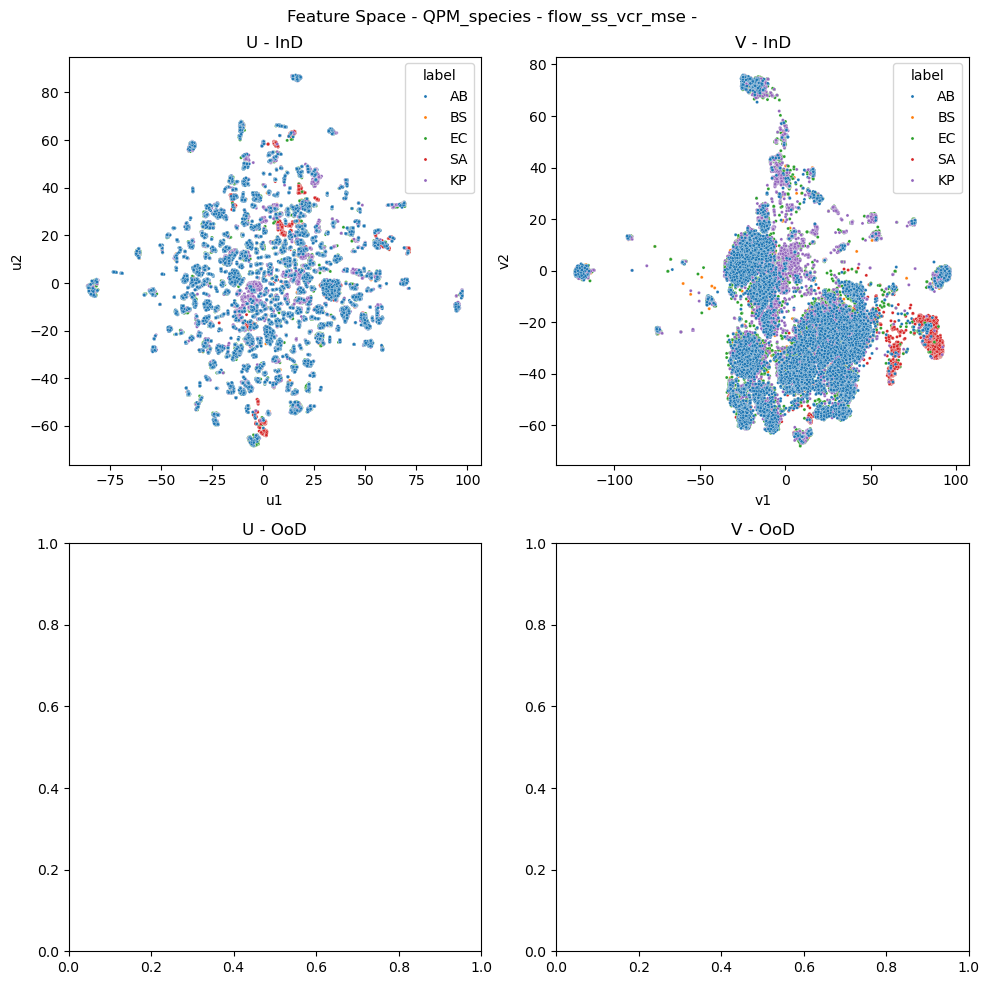

In [12]:
# plot feature space
ind_labels = [config.labels[i] for i in ind_tgt]
df_emb2d = pd.DataFrame()
u1, u2 = ind_e_u2d.T
v1, v2 = ind_e_v2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ind_labels, source="ind"))])

if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]
    u1, u2 = ood_e_u2d.T
    v1, v2 = ood_e_v2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ood_labels, source="ood"))])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
ax1.set_title("U - InD")
ax2.set_title("V - InD")
ax3.set_title("U - OoD")
ax4.set_title("V - OoD")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="u1", y="u2", hue="label", s=5, ax=ax1)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="v1", y="v2", hue="label", s=5, ax=ax2)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="u1", y="u2", hue="label", s=5, ax=ax3)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="v1", y="v2", hue="label", s=5, ax=ax4)
plt.tight_layout()
plt.show()

  0%|                                                                                                                                          | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████▌                                                                                                 | 1/4 [00:16<00:49, 16.53s/it]

 50%|█████████████████████████████████████████████████████████████████                                                                 | 2/4 [00:33<00:33, 16.56s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 3/4 [00:49<00:16, 16.66s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:07<00:00, 16.84s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:07<00:00, 16.75s/it]

  0%|                                                                                                                                          | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████▎                                                                                                | 1/4 [01:47<05:22, 107.59s/it]

 50%|████████████████████████████████████████████████████████████████▌                                                                | 2/4 [03:35<03:35, 107.67s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 3/4 [05:23<01:47, 107.76s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [07:11<00:00, 107.95s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [07:11<00:00, 107.86s/it]

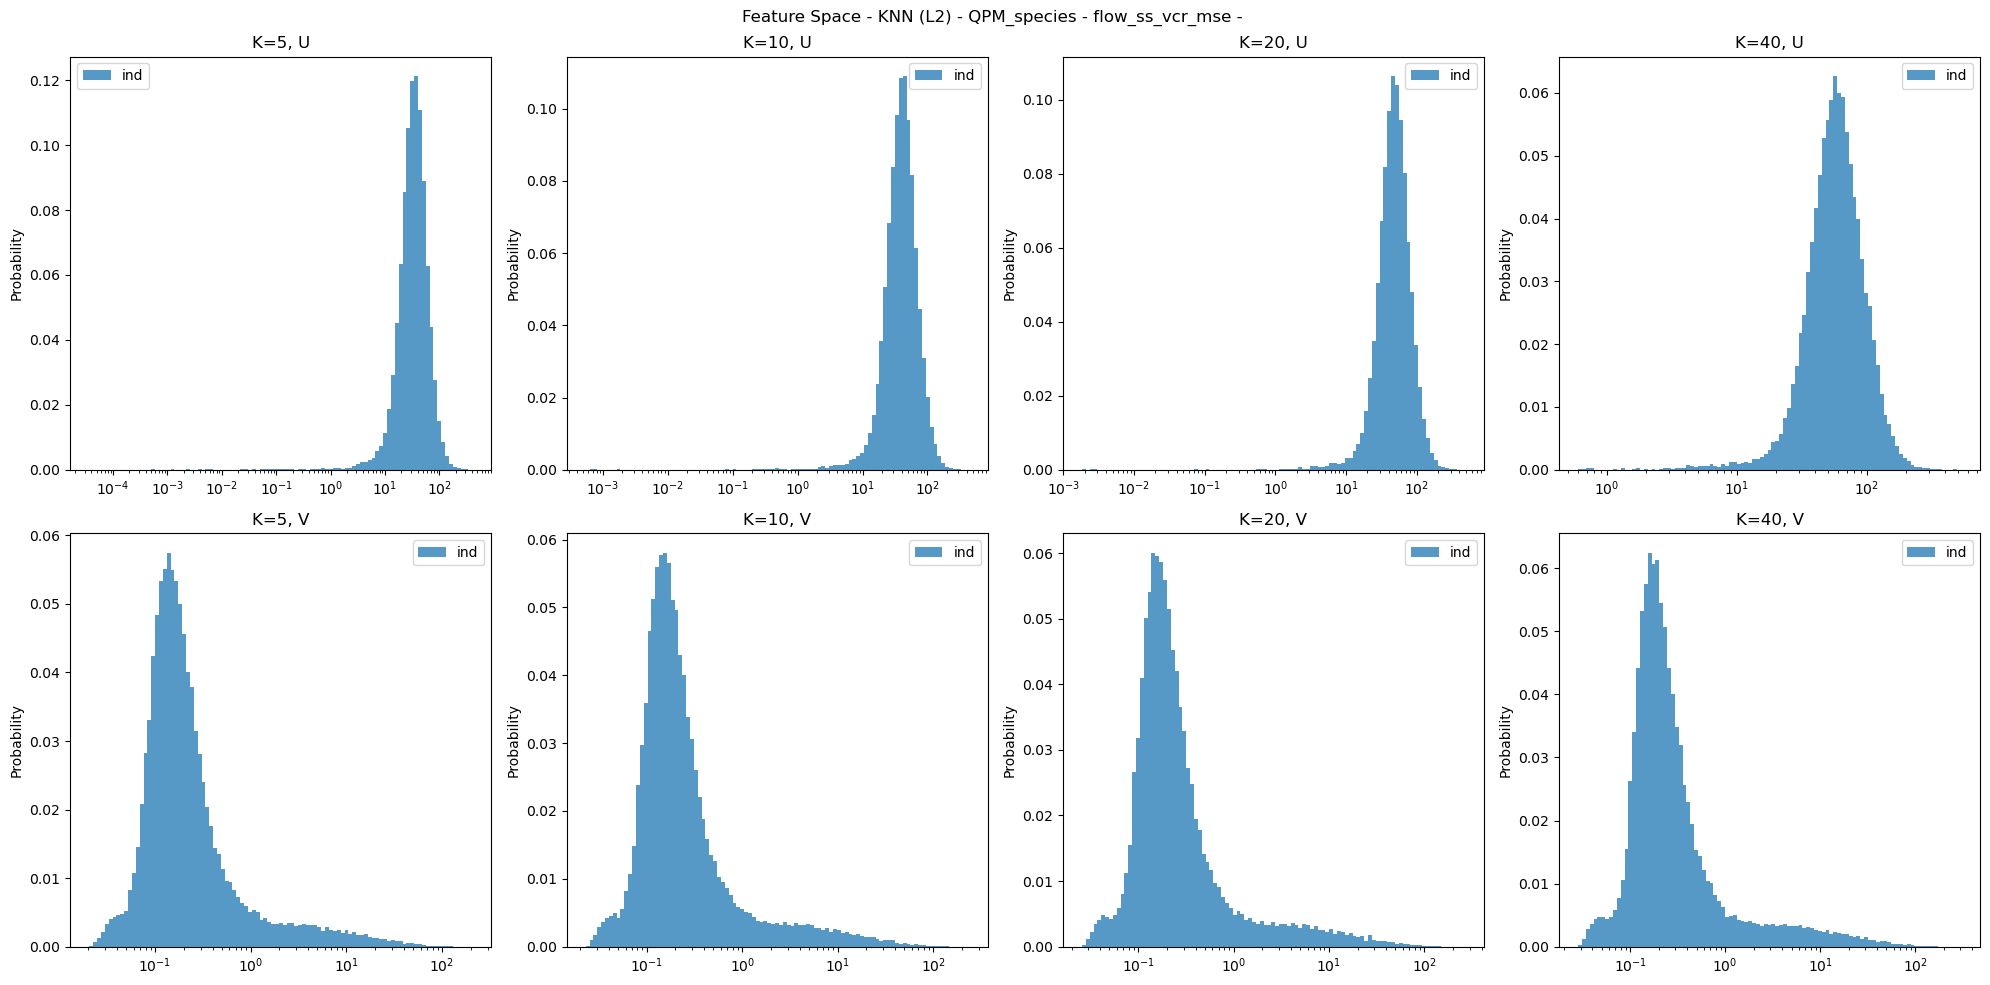

In [13]:
# plot knn to val data in feature space (L2)
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

index = faiss.IndexFlatL2(ind_e_u.shape[-1])
index.add(val_e_u)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_u, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_u, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[0][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, U")
    ax.set_xscale('log')
    ax.legend()

index = faiss.IndexFlatL2(ind_e_v.shape[-1])
index.add(val_e_v)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_v, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_v, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[1][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, V")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                          | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████▌                                                                                                 | 1/4 [00:16<00:48, 16.23s/it]

 50%|█████████████████████████████████████████████████████████████████                                                                 | 2/4 [00:32<00:32, 16.30s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 3/4 [00:49<00:16, 16.39s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:05<00:00, 16.56s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:05<00:00, 16.48s/it]

  0%|                                                                                                                                          | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████▎                                                                                                | 1/4 [01:47<05:21, 107.03s/it]

 50%|████████████████████████████████████████████████████████████████▌                                                                | 2/4 [03:34<03:34, 107.10s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 3/4 [05:21<01:47, 107.23s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [07:09<00:00, 107.45s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [07:09<00:00, 107.34s/it]

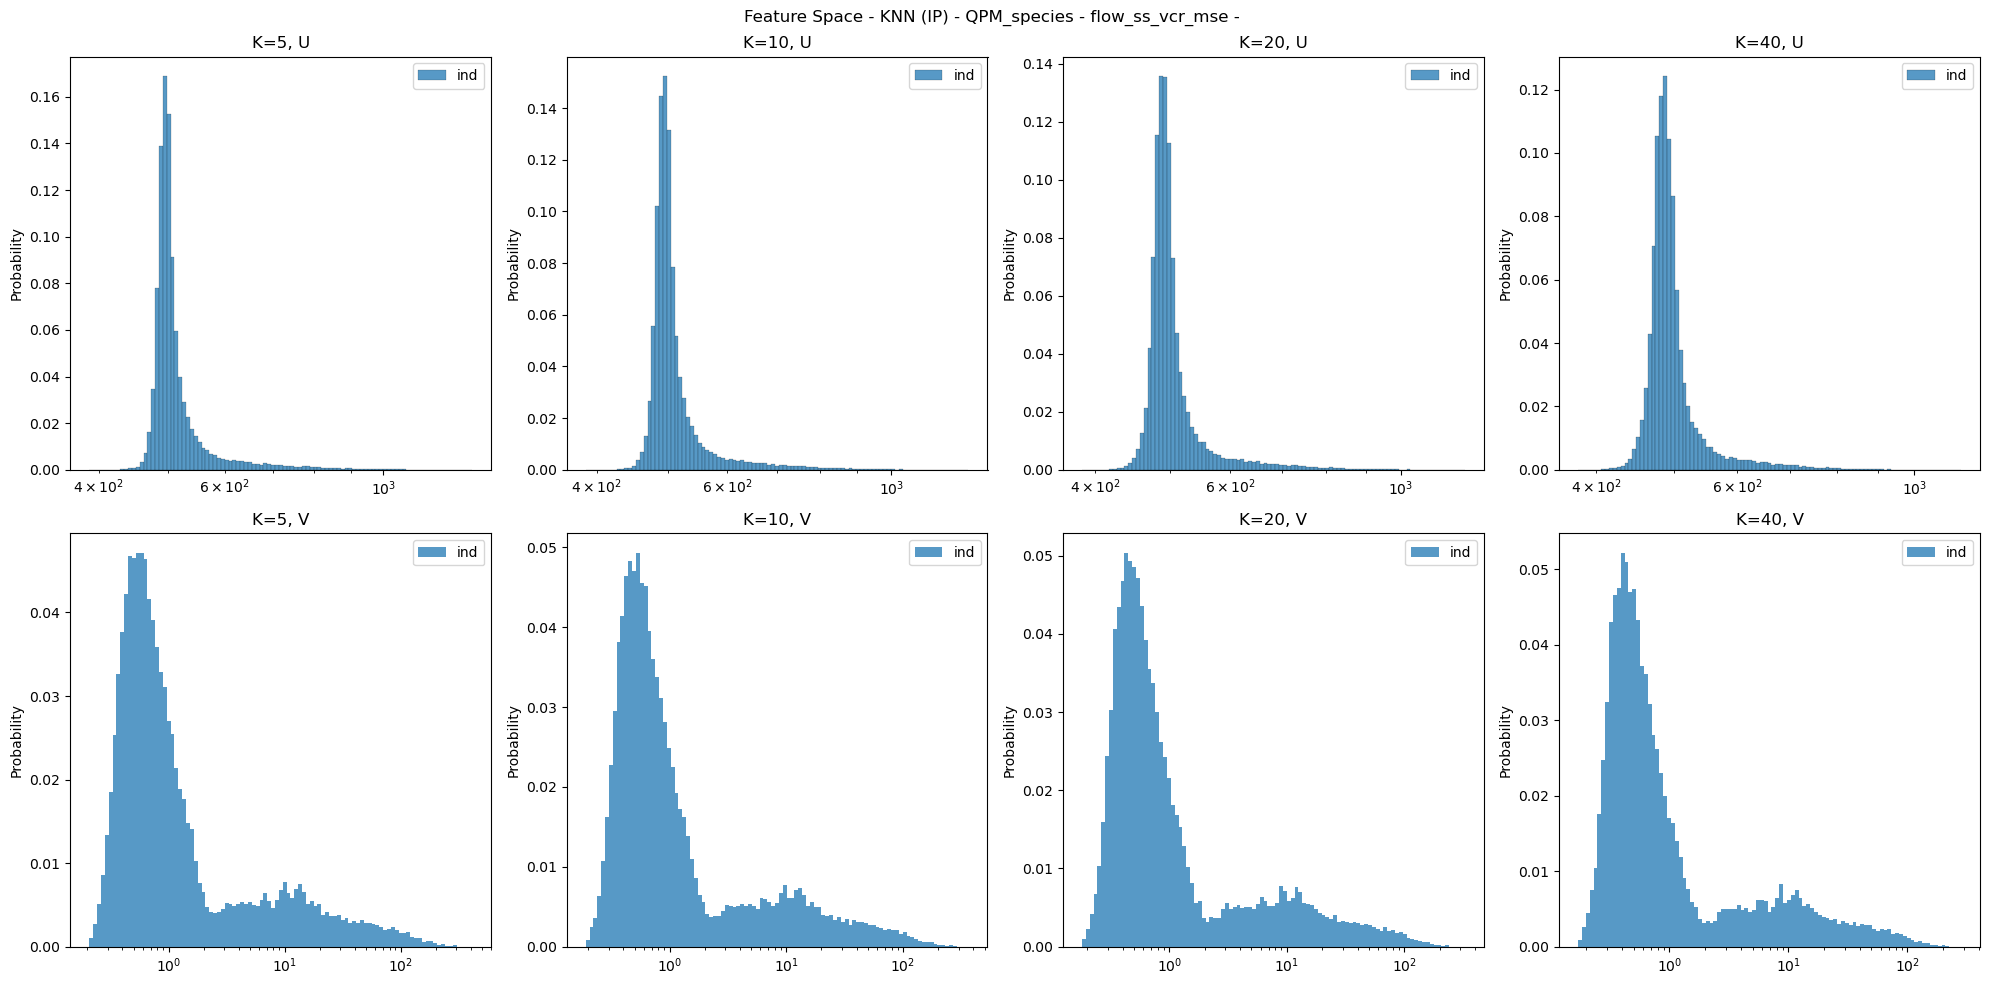

In [14]:
# plot knn to val data in feature space (IP)
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

index = faiss.IndexFlatIP(ind_e_u.shape[-1])
index.add(val_e_u)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_u, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_u, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[0][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, U")
    ax.set_xscale('log')
    ax.legend()

index = faiss.IndexFlatIP(ind_e_v.shape[-1])
index.add(val_e_v)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_v, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_v, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[1][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, V")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

In [15]:
# compute vector norms
trn_n_u = np.linalg.norm(trn_e_u, axis=-1)
trn_n_v = np.linalg.norm(trn_e_v, axis=-1)
val_n_u = np.linalg.norm(val_e_u, axis=-1)
val_n_v = np.linalg.norm(val_e_v, axis=-1)
ind_n_u = np.linalg.norm(ind_e_u, axis=-1)
ind_n_v = np.linalg.norm(ind_e_v, axis=-1)
if ood_str:
    ood_n_u = np.linalg.norm(ood_e_u, axis=-1)
    ood_n_v = np.linalg.norm(ood_e_v, axis=-1)
rnd_n_u = np.linalg.norm(rnd_e_u, axis=-1)
rnd_n_v = np.linalg.norm(rnd_e_v, axis=-1)

print(trn_n_u.mean(), trn_n_u.std(), trn_n_v.mean(), trn_n_v.std())
print(val_n_u.mean(), val_n_u.std(), val_n_v.mean(), val_n_v.std())
print(ind_n_u.mean(), ind_n_u.std(), ind_n_v.mean(), ind_n_v.std())
if ood_str:
    print(ood_n_u.mean(), ood_n_u.std(), ood_n_v.mean(), ood_n_v.std())
print(rnd_n_u.mean(), rnd_n_u.std(), rnd_n_v.mean(), rnd_n_v.std())

22.946756 0.901856 1.1398855 1.3923348
22.889233 0.8197141 1.0596936 1.2596544
22.995161 0.9976533 1.2165356 1.5436969
36.08451 1.0480405 54.154137 0.7570166


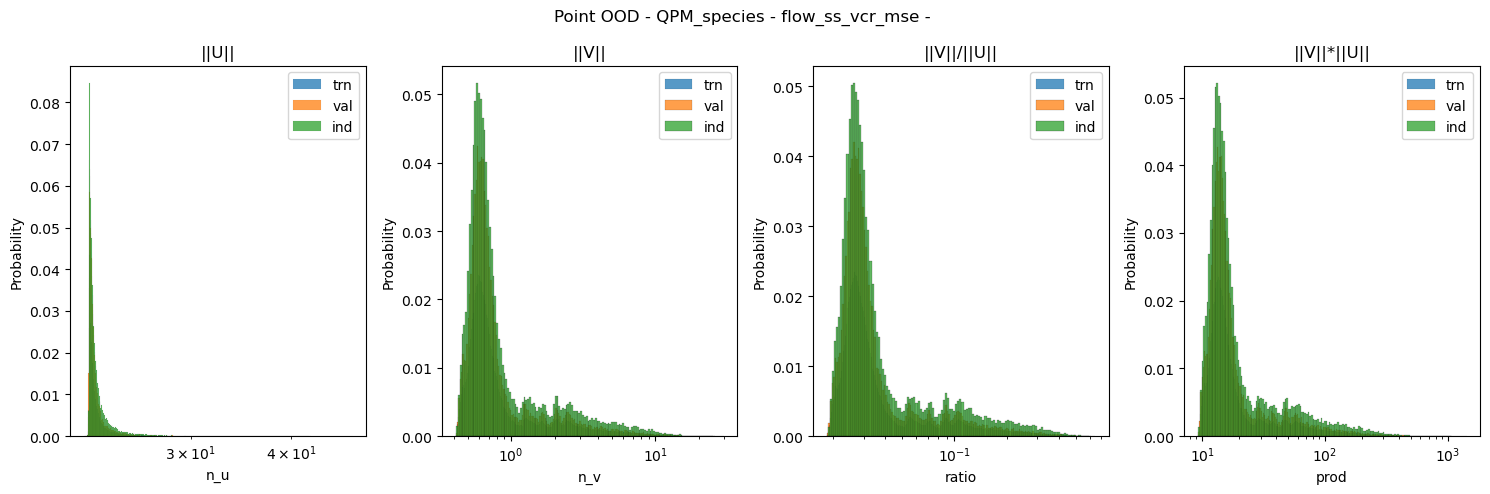

In [16]:
# plot pointwise ood metrics
df_trn = pd.DataFrame(dict(n_u=trn_n_u, n_v=trn_n_v, ratio=trn_n_v/trn_n_u, prod=trn_n_v*trn_n_u, target=trn_tgt))
df_val = pd.DataFrame(dict(n_u=val_n_u, n_v=val_n_v, ratio=val_n_v/val_n_u, prod=val_n_v*val_n_u, target=val_tgt))
df_ind = pd.DataFrame(dict(n_u=ind_n_u, n_v=ind_n_v, ratio=ind_n_v/ind_n_u, prod=ind_n_v*ind_n_u, target=ind_tgt))
if ood_str:
    df_ood = pd.DataFrame(dict(n_u=ood_n_u, n_v=ood_n_v, ratio=ood_n_v/ood_n_u, prod=ood_n_v*ood_n_u, target=ood_tgt))
df_rnd = pd.DataFrame(dict(n_u=rnd_n_u, n_v=rnd_n_v, ratio=rnd_n_v/rnd_n_u, prod=rnd_n_v*rnd_n_u))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 5))
fig.suptitle(f"Point OOD - {dataset_name} - {model_name} - {ood_str}")

def plot_row(prop, ax):
    sns.histplot(data=df_trn, x=prop, log_scale=True, fill=True, label='trn', stat='probability', ax=ax)
    sns.histplot(data=df_val, x=prop, log_scale=True, fill=True, label='val', stat='probability', ax=ax)
    sns.histplot(data=df_ind, x=prop, log_scale=True, fill=True, label='ind', stat='probability', ax=ax)
    if ood_str:
        sns.histplot(data=df_ood, x=prop, log_scale=True, fill=True, label='ood', stat='probability', ax=ax)
    # sns.histplot(data=df_rnd, x=prop, log_scale=True, fill=True, label='rnd', stat='probability', ax=ax)
    ax.legend()

plot_row("n_u", ax1)
plot_row("n_v", ax2)
plot_row("ratio", ax3)
plot_row("prod", ax4)
ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.tight_layout()
plt.show()

In [17]:
# organize data by class, aggregate groupwise
if ood_str:
    df_tst = pd.concat([df_ind, df_ood], axis=0)
else:
    df_tst = df_ind

all_targets = list(df_tst['target'].unique())
K = len(all_targets)
N = 128
rw, rh = 2, 0.75
colors = sns.color_palette(n_colors=K)

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(K):
    _trn = df_trn[df_trn['target'] == all_targets[i]]
    _val = df_val[df_val['target'] == all_targets[i]]
    _tst = df_tst[df_tst['target'] == all_targets[i]]
    pointwise_trn[i] = _trn.copy()
    pointwise_val[i] = _val.copy()
    pointwise_tst[i] = _tst.copy()
    groupwise_trn[i] = _trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = _val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = _tst.rolling(N).agg(['mean', 'std']).dropna().copy()


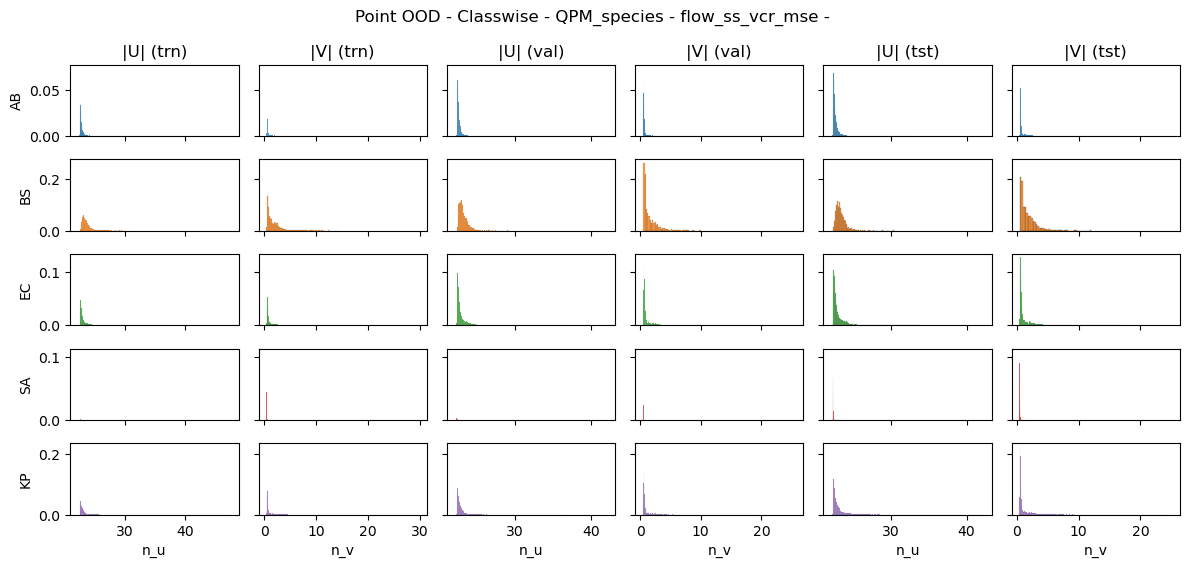

In [18]:
# plot per-class pointwise ood metrics
fig, axs = plt.subplots(K, 6, figsize=(6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Point OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in range(K):
    _trn = pointwise_trn[i]
    _val = pointwise_val[i]
    _tst = pointwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

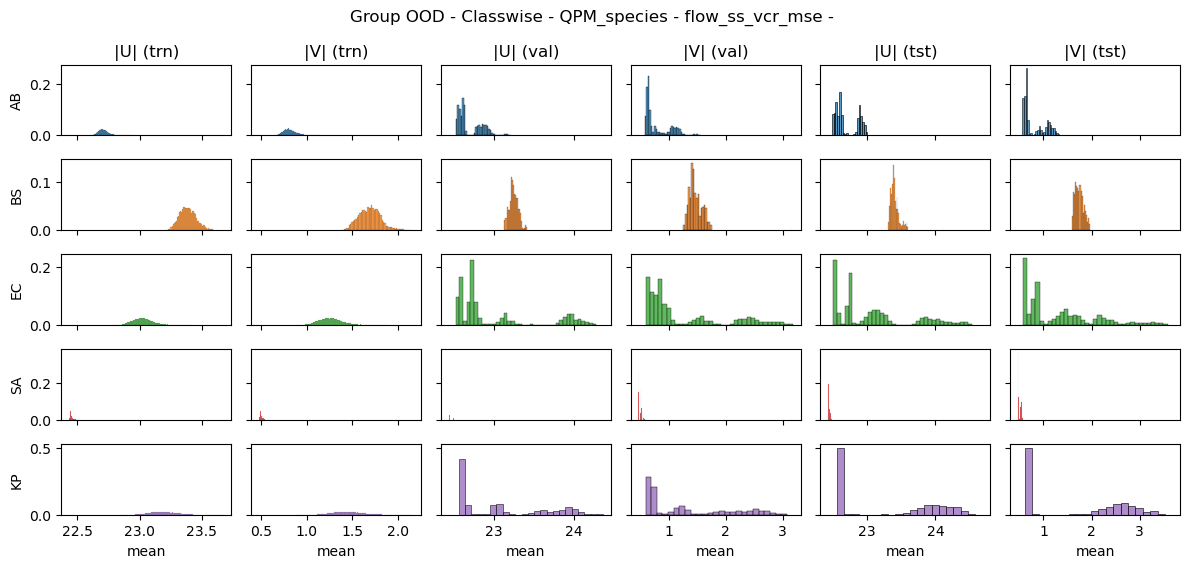

In [19]:
# plot per-class groupwise ood metrics
fig, axs = plt.subplots(K, 6, figsize = (6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Group OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in all_targets:
    _trn = groupwise_trn[i]
    _val = groupwise_val[i]
    _tst = groupwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

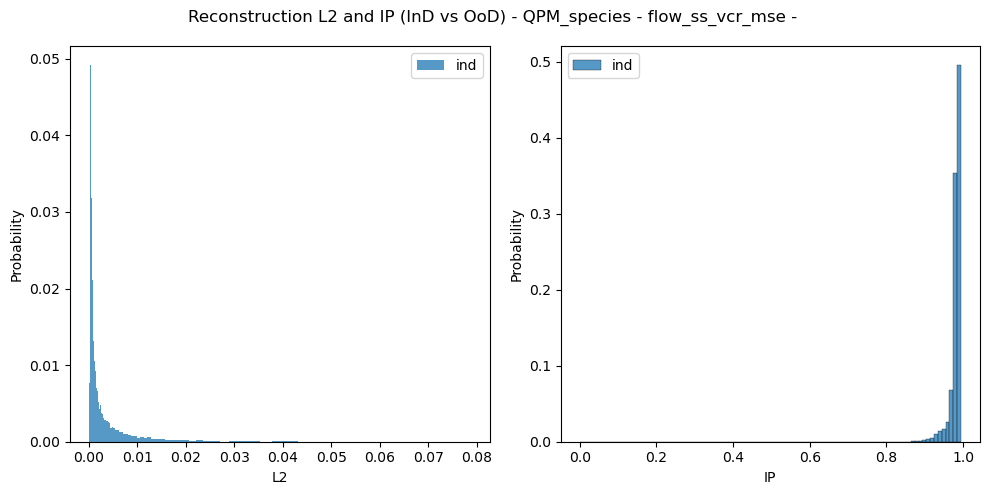

In [20]:
# plot reconstruction-based ood metrics
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

df_rstat = pd.DataFrame()
ni = ind_inp.shape[0]
si = (ni, -1)
# data
_ind_inp = ind_inp.reshape(si)
_ind_rcn = ind_rcn.reshape(si)
# unit vectors
_ind_inp_unit = _ind_inp / (np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7)
_ind_rcn_unit = _ind_rcn / (np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)
# store
_df = pd.DataFrame(dict(target=ind_tgt, rcn_l2=ind_rcn_l2, rcn_ip=ind_rcn_ip, source="ind"))
df_rstat = pd.concat([df_rstat, _df], ignore_index=True)

if ood_str:
    no = ood_inp.shape[0]
    so = (no, -1)
    # data
    _ood_inp = ood_inp.reshape(so)
    _ood_rcn = ood_rcn.reshape(so)
    # unit vectors
    _ood_inp_unit = _ood_inp / (np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7)
    _ood_rcn_unit = _ood_rcn / (np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)
    # store
    _df = pd.DataFrame(dict(target=ood_tgt, rcn_l2=ood_rcn_l2, rcn_ip=ood_rcn_ip, source="ood"))
    df_rstat = pd.concat([df_rstat, _df], ignore_index=True)
    
bins_rcn_l2 = np.logspace(np.log10(df_rstat['rcn_l2'].min() + 1e-7), np.log10(df_rstat['rcn_l2'].max()), 100)
bins_rcn_ip = np.linspace(df_rstat['rcn_ip'].min(), df_rstat['rcn_ip'].max(), 100)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="rcn_l2", label="ind", stat="probability", bins=bins_rcn_l2, ax=ax1)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="rcn_ip", label="ind", stat="probability", bins=bins_rcn_ip, ax=ax2)

if ood_str:
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="rcn_l2", label="ood", stat="probability", bins=bins_rcn_l2, ax=ax1)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="rcn_ip", label="ood", stat="probability", bins=bins_rcn_ip, ax=ax2)

ax1.legend()
ax2.legend()
ax1.set_xlabel("L2")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()